In order to run part 1 we need the following libraries:
* open3d
* numpy
In order to run part 2 we need the following libraries:
* vedo
* trimesh
* pymesh
In order to run part 3 we need the following library:
* pyngrok
and in order to run the the GUI we need a token
and in order to stop the GUI run this command in CMD: taskkill /IM ngrok.exe /F



In [117]:


# Standard library imports
import os
import io
import math
import csv
import random
import itertools
import ast
import statistics as stats
from collections import defaultdict, deque

# Data manipulation and scientific computing
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly
from tqdm import tqdm

# 3D mesh processing and visualization
import open3d as o3d
import vedo
import pymeshlab
from vtkmodules.vtkFiltersGeneral import vtkDensifyPolyData
from vtkmodules.vtkCommonDataModel import vtkPolyData
from vtkmodules.vtkCommonExecutionModel import vtkAlgorithm

# Machine learning and statistics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.stats import wasserstein_distance
from scipy.spatial import KDTree

# Flask for web applications
from flask import Flask, request, render_template, render_template_string, jsonify

# Other utilities
from pyngrok import ngrok


In [118]:
ng_rok_token = "YOUR TOKEN"

# Part 1

In [9]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"

def visualizer(mesh_path):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()

    vis_option = "wireframe_on_shaded"

    if vis_option == "smoothshade":
        o3d.visualization.draw_geometries([mesh], width=1280, height=720)

    elif vis_option == "wireframe_on_shaded":
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(mesh)
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        wireframe.paint_uniform_color([0, 0, 0])
        vis.add_geometry(wireframe)
        opt = vis.get_render_option()
        opt.mesh_show_back_face = True
        vis.run()
        vis.destroy_window()

    elif vis_option == "wireframe":
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        o3d.visualization.draw_geometries([wireframe], width=1280, height=720)

    elif vis_option == "world_axes":
        line_endpoints = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]]
        line_indices = [[0, 1], [0, 2], [0, 3]]
        world_axes = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(line_endpoints),
            lines=o3d.utility.Vector2iVector(line_indices),
        )
        o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)

    elif vis_option == "black_background":
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(mesh)
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])
        vis.run()
        vis.destroy_window()


In [8]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"

visualizer(mesh_path)

# Part 2

In [18]:

database_path = "./data/ShapeDatabase_INFOMR-master"

data = []

def statistics(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)

                    ms = pymeshlab.MeshSet()
                    ms.load_new_mesh(mesh_path)

                    faces = ms.current_mesh().face_matrix()
                    face_types = set()

                    for face in faces:
                        num_vertices_in_face = len(face)
                        if num_vertices_in_face == 3:
                            face_types.add("triangle")
                        elif num_vertices_in_face == 4:
                            face_types.add("quad")
                        else:
                            face_types.add(f"{num_vertices_in_face}-gon")
                            
                    if len(face_types) == 1:
                        face_type = f"Only {face_types.pop()}s"
                    else:
                        face_type = ', '.join(face_types)

                    mesh = o3d.io.read_triangle_mesh(mesh_path)
                    bounding_box = mesh.get_axis_aligned_bounding_box()
                    min_bound = bounding_box.min_bound
                    max_bound = bounding_box.max_bound

                    data.append({
                        'Shape Class': shape_class,
                        'Filename': filename,
                        'Number of Vertices': ms.current_mesh().vertex_number(),
                        'Number of Faces': ms.current_mesh().face_number(),
                        'Face Types': face_type,
                        'Bounding Box Min': min_bound,
                        'Bounding Box Max': max_bound
                    })
    return data

In [15]:

# Get statistics and create DataFrame
data = statistics(database_path)
df = pd.DataFrame(data)
df.to_csv("./statistics/shape_database_stats.csv",index=False)


In [16]:

def show_obj_stats(df, obj):
    obj_stats = df[df['Filename'] == obj]

    if obj_stats.empty:
        print(f"No object found with the name: {obj}")
    else:
        print(f"Statistics for {obj}:")
        print(obj_stats)

show_obj_stats(df, 'D00626.obj')


In [17]:
df = pd.read_csv("./statistics/shape_database_stats.csv")

def run_histograms (df):
    # Calculate average number of vertices and faces
    average_vertices = df['Number of Vertices'].mean()
    average_faces = df['Number of Faces'].mean()
    min_vertices = df['Number of Vertices'].min()
    min_faces = df['Number of Faces'].min()
    max_vertices = df['Number of Vertices'].max()
    max_faces = df['Number of Faces'].max()
    
    # Calculate standard deviation
    std_vertices = df['Number of Vertices'].std()
    std_faces = df['Number of Faces'].std()

    print(f"Average number of vertices: {average_vertices}")
    print(f"Average number of faces: {average_faces}")
    print(f"min number of vertices: {min_vertices}")
    print(f"min number of faces: {min_faces}")
    print(f"max number of vertices: {max_vertices}")
    print(f"max number of faces: {max_faces}")
    print(f"Standard deviation of vertices: {std_vertices}")
    print(f"Standard deviation of faces: {std_faces}")

    # Identify outliers
    vertices_outliers = df[(df['Number of Vertices'] > average_vertices + 2 * std_vertices) |
                          (df['Number of Vertices'] < average_vertices - 2 * std_vertices)]

    faces_outliers = df[(df['Number of Faces'] > average_faces + 2 * std_faces) |
                        (df['Number of Faces'] < average_faces - 2 * std_faces)]

    print("Outliers in vertices count:")
    print(vertices_outliers[['Filename', 'Number of Vertices', 'Shape Class']])
    print("\nOutliers in faces count:")
    print(faces_outliers[['Filename', 'Number of Faces', 'Shape Class']])

    # Filter for shapes with under 100 vertices and/or faces
    small_shapes_df = df[(df['Number of Vertices'] < 100) | (df['Number of Faces'] < 100)]

    print("Shapes with under 100 vertices and/or faces:")
    print(small_shapes_df[['Filename', 'Number of Vertices', 'Number of Faces', 'Shape Class']])


    # Calculate histograms
    vertices_hist, vertices_bins = np.histogram(df['Number of Vertices'], bins=50)
    faces_hist, faces_bins = np.histogram(df['Number of Faces'], bins=50)

    vertices_hist_df = pd.DataFrame({
        'Bin Start': vertices_bins[:-1],
        'Bin End': vertices_bins[1:],
        'Frequency': vertices_hist
    })

    faces_hist_df = pd.DataFrame({
        'Bin Start': faces_bins[:-1],
        'Bin End': faces_bins[1:],
        'Frequency': faces_hist
    })

    print("\nVertices Histogram:")
    print(vertices_hist_df)

    print("\nFaces Histogram:")
    print(faces_hist_df)

    # Plot histograms
    plt.figure(figsize=(60, 50))

    # Histogram of number of vertices
    plt.subplot(2, 2, 1)
    plt.hist(df['Number of Vertices'], bins=50, edgecolor='black')
    plt.axvline(average_vertices, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_vertices:.2f}')
    plt.axvline(average_vertices+std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: {std_vertices:.2f}')
    plt.axvline(average_vertices + 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_vertices:.2f}')
    plt.axvline(average_vertices - std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {-std_vertices:.2f}')
    plt.axvline(average_vertices - 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: { -2 * std_vertices:.2f}')
    plt.title('Histogram of Number of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of number of faces
    plt.subplot(2, 2, 2)
    plt.hist(df['Number of Faces'], bins=50, edgecolor='black')
    plt.axvline(average_faces, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_faces:.2f}')
    plt.axvline(average_faces + std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: { std_faces:.2f}')
    plt.axvline(average_faces + 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_faces:.2f}')
    plt.axvline(average_faces - std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {- std_faces:.2f}')
    plt.axvline(average_faces - 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: {- 2 * std_faces:.2f}')
    plt.title('Histogram of Number of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of shape classes
    plt.subplot(2, 2, 3)
    sns.countplot(data=df, x='Shape Class', order=df['Shape Class'].value_counts().index)
    plt.title('Histogram of Shape Classes',fontsize=30)
    plt.xlabel('Shape Class', fontsize=30)
    plt.ylabel('Count',fontsize=30)
    plt.xticks(rotation=45,fontsize=20)

    plt.tight_layout()
    plt.show()


In [ ]:
run_histograms(df)

## Resumpling the meshes

In [30]:

def resample_mesh(mesh_path, target_vertices=10000):
    mesh = vedo.load(mesh_path)
    prev_mesh=mesh

    initial_vertex_count = mesh.npoints
    resampled_vertex_count = initial_vertex_count

    # Close holes if there are any
    mesh.fill_holes(size=1)  
    mesh.clean()
    mesh.triangulate()
    mesh.compute_normals()

    if initial_vertex_count > target_vertices:
        # Subsampling: Decimate the mesh to reduce the number of vertices
        mesh = mesh.decimate(fraction=target_vertices/initial_vertex_count)
        resampled_vertex_count = mesh.npoints
        print(f"Subsampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")

    elif initial_vertex_count < target_vertices:

        # Supersampling: Subdivide the mesh until we reach the target vertex count
        iterations = 1
        while mesh.npoints < target_vertices and iterations <= 10:
            mesh = mesh.subdivide(method=4)  # Loop subdivision (method=1)  subdividing as ’centroid’
            iterations += 1
            resampled_vertex_count = mesh.npoints

        # After subdivision, we may overshoot the target, so decimate to exactly match the target
        if mesh.npoints > target_vertices:
            mesh = mesh.decimate(fraction=target_vertices/mesh.npoints)
        if mesh.npoints==0:
            print("here")
            mesh=vedo.load(mesh_path)
            resampled_vertex_count = mesh.npoints
        resampled_vertex_count = mesh.npoints
        print(f"Supersampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")

    mesh.compute_normals()
    resampled_mesh_path = ""
    if "query" not in mesh_path:
      resampled_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master", "ShapeDatabase_INFOMR-master_resumpled")
    else:
      resampled_mesh_path = mesh_path
    

    output_dir = os.path.dirname(resampled_mesh_path)
    os.makedirs(output_dir, exist_ok=True)
    vedo.write(mesh, resampled_mesh_path)
    print(f"Final resampled mesh saved to: {resampled_mesh_path}, Vertices: {resampled_vertex_count}")

    return resampled_mesh_path

## Resampling all the meshes

In [ ]:
def process_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"): 
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")
                    resample_mesh(mesh_path)


## Processing the Meshes

In [ ]:
base_path = "./data/ShapeDatabase_INFOMR-master"
process_all_meshes(base_path)

## Run statistics for the resumpled dataset

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
data = statistics(database_path)
df = pd.DataFrame(data)

# Save data to CSV
df.to_csv("./statistics/shape_database_stats_resumple.csv", index=False)

## Run the histogram after sampling

In [ ]:
df= pd.read_csv("./statistics/shape_database_stats_resumple.csv")
run_histograms(df)

## Normalizing the meshes

In [31]:
def ComputePCA(mesh):
    vertices = np.asarray(mesh.vertices)
    cov = np.cov(vertices, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
    eigencombined.sort(key=lambda x: x[0], reverse=True)

    eigenvalues = [item[0] for item in eigencombined]
    eigenvectors = [item[1] for item in eigencombined]

    if len(eigenvectors) > 2:
        eigenvectors.pop(2) 
        third_vector = np.cross(eigenvectors[0], eigenvectors[1])
        eigenvectors.append(third_vector / np.linalg.norm(third_vector))

    return eigenvalues, np.array(eigenvectors) 

In [32]:
def align_vertices(vertices,eigenvectors):
    aligned_vertices = np.zeros(vertices.shape)
    for i, p in enumerate(vertices):
        x_updated = np.dot(p, eigenvectors[0])  # Projection onto e1
        y_updated = np.dot(p, eigenvectors[1])  # Projection onto e2
        z_updated = np.dot(p, eigenvectors[2])  # Projection onto e3 (e1 x e2)
        # Store the updated vertex coordinates in the aligned vertices array
        aligned_vertices[i] = np.array([x_updated, y_updated, z_updated])
    return aligned_vertices

In [33]:
def compute_triangle_centroid(vertices, triangle):
    """Helper function to compute the centroid of a triangle."""
    v0 = vertices[triangle[0]]
    v1 = vertices[triangle[1]]
    v2 = vertices[triangle[2]]
    return (v0 + v1 + v2) / 3.0

In [34]:
def flip_mesh_by_volume(mesh):
    # Calculate the flipping values for each axis (x, y, z)
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        # Get the vertices of the face (triangle)
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        
        # Calculate the center of the triangle
        center = (v0 + v1 + v2) / 3
        
        # Add the center coordinates to the flipping values
        flipping_values += center

    # Determine the sign of each flipping value
    flipping_signs = np.sign(flipping_values)

    # Mirror along axes where flipping sign is negative
    for i, axis in enumerate("xyz"):
        if flipping_signs[i] < 0:
            mesh.mirror(axis=axis)

    return mesh


In [35]:
def normalize_shape(mesh_path):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return None

    # Step 1: Calculate the barycenter and translate the mesh to the origin
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)
    translated_vertices = np.asarray(mesh.vertices) - barycenter
    mesh.vertices = o3d.utility.Vector3dVector(translated_vertices)
    mesh.compute_vertex_normals()
    
    # Step 2: Align the mesh with principal axes using PCA
    eigenvalues, eigenvectors = ComputePCA(mesh)  # Ensure this function is defined
    aligned_vertices = align_vertices(translated_vertices, eigenvectors)  # Ensure this function is defined
    mesh.vertices = o3d.utility.Vector3dVector(aligned_vertices)
    mesh.compute_vertex_normals()
    
    # Save the translated and aligned mesh
    intermediate_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_intermediate")
    os.makedirs(os.path.dirname(intermediate_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(intermediate_mesh_path, mesh)
    
    # Load with Vedo for flipping
    vedo_mesh = vedo.Mesh(intermediate_mesh_path)
    
    # Step 3: Flip mesh along axes if needed
    flipped_mesh = flip_mesh_by_volume(vedo_mesh) 
    
    # Save the flipped mesh
    flipped_mesh.write(intermediate_mesh_path)

    # Load flipped mesh back into Open3D
    flipped_mesh_o3d = o3d.io.read_triangle_mesh(intermediate_mesh_path)
    flipped_mesh_o3d.compute_vertex_normals()

    # Step 4: Scale mesh to fit within a unit cube, centered at the origin
    bounds = flipped_mesh_o3d.get_axis_aligned_bounding_box()
    max_bound = bounds.get_max_bound()
    min_bound = bounds.get_min_bound()
    max_dimension = np.max(max_bound - min_bound)
    scale_factor = 1 / max_dimension
    flipped_mesh_o3d.scale(scale_factor, center=[0,0,0])

    # Compute normals after scaling
    flipped_mesh_o3d.compute_vertex_normals()
    # Step 5: Save the normalized mesh
    normalized_mesh_path = ""
    if "query" not in mesh_path:
      normalized_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_normalized")
    else:
      normalized_mesh_path = mesh_path
    os.makedirs(os.path.dirname(normalized_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(normalized_mesh_path, flipped_mesh_o3d)

    return normalized_mesh_path

## Normalizing all the meshes

In [36]:
def norm_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")
                    normalize_shape(mesh_path)

In [ ]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master_resumpled/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
normalize_shape(mesh_path)
mesh_path = r"./data/ShapeDatabase_INFOMR-master_normalized/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
mesh = o3d.io.read_triangle_mesh(mesh_path)
vedo_mesh = vedo.Mesh(mesh_path)
print(verify_translation(mesh),verify_scaling(mesh,mesh_path),verify_alignment(mesh),verify_flipping(vedo_mesh))


## Processing the Meshes

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
norm_all_meshes(database_path)

## Run statistics for the normalized dataset

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = statistics(database_path)
df = pd.DataFrame(data)

df.to_csv("./statistics/shape_database_stats_norm.csv", index=False)

## Validation

In [37]:
def verify_translation(mesh, threshold=2e-3):
    # Compute barycenter
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)

    # Distance from origin
    distance_to_origin = np.linalg.norm(barycenter)
    return distance_to_origin <= threshold, distance_to_origin

In [38]:
def verify_scaling(mesh,mesh_path ,margin=1e-4):
    bounding_box = mesh.get_axis_aligned_bounding_box()
    min_bound = bounding_box.get_min_bound()
    max_bound = bounding_box.get_max_bound()

    bbox_size = max_bound - min_bound
    bbox_x, bbox_y, bbox_z = bbox_size
    max_axis=max(bbox_x, bbox_y, bbox_z)
    if ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))==False:
        print("This mesh doesnot fit: ",mesh_path)

    return ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))

In [39]:
def verify_alignment(mesh, threshold=1e-4):
    vertices = np.asarray(mesh.vertices)
    eigenvalues, eigenvectors = ComputePCA(mesh)
    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])
    dot_x = np.abs(np.dot(eigenvectors[0], x_axis))
    dot_y = np.abs(np.dot(eigenvectors[1], y_axis))
    dot_z = np.abs(np.dot(eigenvectors[2], z_axis))
    aligned_x = dot_x >= threshold
    aligned_y = dot_y >= threshold
    aligned_z = dot_z >= threshold
    return aligned_x and aligned_y and aligned_z

In [40]:
def verify_flipping(mesh):
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        center = (v0 + v1 + v2) / 3
        flipping_values += center
    positive_check = np.all(flipping_values >= 0)
    return positive_check

In [41]:
def analyze_shapes(database_path):
    translation_results = []
    translation_distances = []
    scaling_results = []
    alingment_results = []
    flipping_results = []

    # Traverse through each shape class directory and process .obj files
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        vedo_mesh = vedo.Mesh(mesh_path)
                        translation_ok, distance_to_origin = verify_translation(mesh)
                        scaling_ok = verify_scaling(mesh,mesh_path)
                        aligning_ok = verify_alignment(mesh)
                        flip_ok = verify_flipping(vedo_mesh)
                        
                        translation_results.append(translation_ok)
                        translation_distances.append(distance_to_origin)
                        scaling_results.append(scaling_ok)
                        alingment_results.append(aligning_ok)
                        flipping_results.append(flip_ok)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return translation_results, translation_distances, scaling_results,alingment_results,flipping_results

In [42]:
def plot_histograms(translation_results, translation_distances, scaling_results, alignment_results, flipping_results):
    # Create histograms for translation
    plt.figure(figsize=(12, 6))

    # Histogram for translation (distance to origin)
    plt.subplot(1, 2, 1)
    plt.hist(translation_distances, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=2e-3, color='red', linestyle='--', label='Threshold')
    plt.title('Translation Check: Distance to Origin')
    plt.xlabel('Distance to Origin')
    plt.ylabel('Number of Shapes')
    plt.legend()

    # Success/Failure counts for translation
    plt.subplot(1, 2, 2)
    translation_results_numeric = [int(result) for result in translation_results]
    plt.hist(translation_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Translation Result: Barycenter at Origin')
    plt.xlabel('Translation Result')
    plt.ylabel('Number of Shapes')

    plt.tight_layout()
    plt.show()

    # Create histograms for scaling and alignment
    plt.figure(figsize=(12, 6))

    # Histogram for scaling (fit in unit cube)
    plt.subplot(1, 2, 1)
    scaling_results_numeric = [int(result) for result in scaling_results]
    plt.hist(scaling_results_numeric, bins=2, color='salmon', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Scaling Check: Fits in Unit Cube')
    plt.xlabel('Scaling Result')
    plt.ylabel('Number of Shapes')

    # Success/Failure counts for alignment
    plt.subplot(1, 2, 2)
    alignment_results_numeric = [int(result) for result in alignment_results]
    plt.hist(alignment_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Alignment Result: Align along the XYZ Axis')
    plt.xlabel('Alignment Result')
    plt.ylabel('Number of Shapes')
    plt.tight_layout()
    plt.show()

    # Success/Failure counts for flipping
    plt.figure(figsize=(6, 6))
    flipping_results_numeric = [int(result) for result in flipping_results]
    plt.hist(flipping_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Flipping Result: Flipped Shapes')
    plt.xlabel('Flipping Result')
    plt.ylabel('Number of Shapes')

    plt.tight_layout()
    plt.show()

In [ ]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
translation_results, translation_distances, scaling_results,alingment_results,flipping_results = analyze_shapes(database_path)
plot_histograms(translation_results, translation_distances, scaling_results,alingment_results,flipping_results)

In [ ]:
flipping_results.count(False)

## Adding some statistical tests for pose and flip normalizations:

In [43]:

def compute_principal_axes(mesh):
    vertices = np.asarray(mesh.vertices)
    eigenvalues, eigenvectors = ComputePCA(mesh)
    return eigenvectors 

def calculate_absolute_angle(v1, v2):
    v1_abs = np.abs(v1)
    v2_abs = np.abs(v2)
    
    cosine_angle = np.clip(np.dot(v1_abs, v2_abs) / (np.linalg.norm(v1_abs) * np.linalg.norm(v2_abs)), -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Function to compute and compare orientation angles
def compute_orientation_statistics(database_path, aligned=False):
    angles_x, angles_y, angles_z = [], [], []

    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])

    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        principal_axes = compute_principal_axes(mesh)
                        
                        angle_x = calculate_absolute_angle(principal_axes[0], x_axis)
                        angle_y = calculate_absolute_angle(principal_axes[1], y_axis)
                        angle_z = calculate_absolute_angle(principal_axes[2], z_axis)
                
                        angles_x.append(angle_x)
                        angles_y.append(angle_y)
                        angles_z.append(angle_z)
                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")
    
    std_x = np.std(angles_x)
    std_y = np.std(angles_y)
    std_z = np.std(angles_z)
    
    mean_x = np.mean(angles_x)
    mean_y = np.mean(angles_y)
    mean_z = np.mean(angles_z)

    label = "after alignment" if aligned else "before alignment"
    print(f"\nOrientation angles {label}:")
    print(f"Standard Deviation (X-Axis): {std_x:.2f}°")
    print(f"Mean (X-Axis): {mean_x:.2f}°")
    print(f"Standard Deviation (Y-Axis): {std_y:.2f}°")
    print(f"Mean (Y-Axis): {mean_y:.2f}°")
    print(f"Standard Deviation (Z-Axis): {std_z:.2f}°")
    print(f"Mean (Z-Axis): {mean_z:.2f}°")

mesh_list_before = "./data/ShapeDatabase_INFOMR-master"
mesh_list_after = "./data/ShapeDatabase_INFOMR-master_normalized"

# Compute statistics before alignment
compute_orientation_statistics(mesh_list_before, aligned=False)

# Compute statistics after alignment
compute_orientation_statistics(mesh_list_after, aligned=True)



Orientation angles before alignment:
Standard Deviation (X-Axis): 39.90°
Mean (X-Axis): 47.03°
Standard Deviation (Y-Axis): 37.61°
Mean (Y-Axis): 51.93°
Standard Deviation (Z-Axis): 38.34°
Mean (Z-Axis): 39.09°

Orientation angles after alignment:
Standard Deviation (X-Axis): 0.04°
Mean (X-Axis): 0.00°
Standard Deviation (Y-Axis): 0.07°
Mean (Y-Axis): 0.01°
Standard Deviation (Z-Axis): 0.06°
Mean (Z-Axis): 0.01°


In [44]:

# Function to calculate the angle (in degrees) between two vectors
def calculate_absolute_angle_flipping(v1, v2):
    cosine_angle = np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Function to apply flipping normalization (flipping along all axes)
def flip_mesh(mesh):
    # Flip the mesh by negating vertices along all axes
    mesh.vertices = o3d.utility.Vector3dVector(np.negative(np.asarray(mesh.vertices)))
    return mesh

# Function to compute and compare orientation angles before and after flipping
def compute_orientation_statistics(database_path):
    angles_x, angles_y, angles_z = [], [], []

    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])

    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        
                        principal_axes_before = compute_principal_axes(mesh)
                        
                        angle_x_before = calculate_absolute_angle_flipping(principal_axes_before[0], x_axis)
                        angle_y_before = calculate_absolute_angle_flipping(principal_axes_before[1], y_axis)
                        angle_z_before = calculate_absolute_angle_flipping(principal_axes_before[2], z_axis)
                
                        # Apply flipping normalization
                        flipped_mesh = flip_mesh(mesh)
                        
                        principal_axes_after = compute_principal_axes(flipped_mesh)
                        
                        angle_x_after = calculate_absolute_angle_flipping(principal_axes_after[0], x_axis)
                        angle_y_after = calculate_absolute_angle_flipping(principal_axes_after[1], y_axis)
                        angle_z_after = calculate_absolute_angle_flipping(principal_axes_after[2], z_axis)
                        
                        angles_x.append((angle_x_before, angle_x_after))
                        angles_y.append((angle_y_before, angle_y_after))
                        angles_z.append((angle_z_before, angle_z_after))
                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")
    
    # Compute statistics for each axis (before and after flipping)
    angles_x_before, angles_x_after = zip(*angles_x)
    angles_y_before, angles_y_after = zip(*angles_y)
    angles_z_before, angles_z_after = zip(*angles_z)
    
    std_x_before = np.std(angles_x_before)
    std_x_after = np.std(angles_x_after)
    
    std_y_before = np.std(angles_y_before)
    std_y_after = np.std(angles_y_after)
    
    std_z_before = np.std(angles_z_before)
    std_z_after = np.std(angles_z_after)
    
    mean_x_before = np.mean(angles_x_before)
    mean_x_after = np.mean(angles_x_after)
    
    mean_y_before = np.mean(angles_y_before)
    mean_y_after = np.mean(angles_y_after)
    
    mean_z_before = np.mean(angles_z_before)
    mean_z_after = np.mean(angles_z_after)

    print("\nOrientation angles before and after flipping:")
    print(f"Standard Deviation (X-Axis) Before: {std_x_before:.2f}° | After: {std_x_after:.2f}°")
    print(f"Mean (X-Axis) Before: {mean_x_before:.2f}° | After: {mean_x_after:.2f}°")
    print(f"Standard Deviation (Y-Axis) Before: {std_y_before:.2f}° | After: {std_y_after:.2f}°")
    print(f"Mean (Y-Axis) Before: {mean_y_before:.2f}° | After: {mean_y_after:.2f}°")
    print(f"Standard Deviation (Z-Axis) Before: {std_z_before:.2f}° | After: {std_z_after:.2f}°")
    print(f"Mean (Z-Axis) Before: {mean_z_before:.2f}° | After: {mean_z_after:.2f}°")

mesh_list_path = "./data/ShapeDatabase_INFOMR-master_resumpled"
compute_orientation_statistics(mesh_list_path)



Orientation angles before and after flipping:
Standard Deviation (X-Axis) Before: 41.84° | After: 41.84°
Mean (X-Axis) Before: 131.07° | After: 131.07°
Standard Deviation (Y-Axis) Before: 47.57° | After: 47.57°
Mean (Y-Axis) Before: 66.81° | After: 66.81°
Standard Deviation (Z-Axis) Before: 54.72° | After: 54.72°
Mean (Z-Axis) Before: 120.86° | After: 120.86°


## Check the bounding box sizes distribution (Mean and STD) before and after normalization

In [45]:
def b_box_size(mesh):
    bounding_box = mesh.get_axis_aligned_bounding_box()
    # Compute the size of the bounding box via its diagonal
    size = np.linalg.norm(bounding_box.get_max_bound() - bounding_box.get_min_bound())
    return size

In [46]:
def analyze_bounding_box_sizes(database_path):
    bounding_box_sizes = []

    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        size = b_box_size(mesh)
                        bounding_box_sizes.append(size)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return bounding_box_sizes

In [47]:
def plot_bounding_box_size_histogram(bounding_box_sizes):
    plt.figure(figsize=(8, 6))
    plt.hist(bounding_box_sizes, bins=20, color='lightblue', edgecolor='black')
    plt.title('Bounding Box Size Histogram')
    plt.xlabel('Bounding Box Size (Diagonal Length)')
    plt.ylabel('Number of Shapes')
    plt.axvline(x=np.mean(bounding_box_sizes), color='red', linestyle='--', label='Mean Size')
    plt.axvline(x=math.sqrt(3), color='green', linestyle='--', label='Diagonal of a unit cube')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
bounding_box_sizes = analyze_bounding_box_sizes(database_path)
plot_bounding_box_size_histogram(bounding_box_sizes)

In [48]:
def calculate_statistics(bounding_box_sizes):
    mean_size = np.mean(bounding_box_sizes)
    std_size = np.std(bounding_box_sizes)
    return mean_size, std_size

In [ ]:
# Calculate and print the mean and standard deviation
mean_size, std_size = calculate_statistics(bounding_box_sizes)
print(f"Mean Bounding Box Size: {mean_size}")
print(f"Standard Deviation of Bounding Box Sizes: {std_size}")

## Check the barycenter distances from its origin distribution (Mean and STD) before and after normalization

In [ ]:
mean_baryC_distance=np.mean(translation_distances)
std_baryC_distance=np.std(translation_distances)
print(f"Mean Barycenter Distance from Origin: {mean_baryC_distance}")
print(f"Standard Deviation of Barycenter Distances: {std_baryC_distance}")

## visualizing the mehses before and after normalization

In [49]:
def visualize_mesh_with_unit_bbox(mesh_path):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return

    # Step 1: Calculate the barycenter
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)

    # Compute the bounding box of the mesh
    mesh_bbox = mesh.get_axis_aligned_bounding_box()

    # Set the bounding box color to red (for the actual mesh bounding box)
    mesh_bbox.color = np.array([1, 0, 0])  # Red color

    # Create a unit cube representing the unit bounding box [-0.5, 0.5] in each dimension
    unit_bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=[-0.5, -0.5, -0.5], max_bound=[0.5, 0.5, 0.5])
    unit_bbox.color = np.array([0, 1, 0])  # Green color for the unit cube

    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Add the mesh, its bounding box, the unit cube, and the axes to the visualizer
    vis.add_geometry(mesh)
    vis.add_geometry(unit_bbox)
    vis.add_geometry(axis)
    # Slightly displace the wireframe mesh to avoid z-fighting (mimicking OpenGL offset)
    wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    wireframe.paint_uniform_color([0, 0, 0])
    vis.add_geometry(wireframe)

    vis.run()
    vis.destroy_window()

In [ ]:
mesh_path = "./data/ShapeDatabase_INFOMR-master_normalized/Bus/D00264.obj"
visualize_mesh_with_unit_bbox(mesh_path)

# Part 3

## Part 3.2.1

In [50]:
def compute_obb_volume(mesh):
    vertices = np.asarray(mesh.vertices)

    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)
   
    # Sort the eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    principal_axes = eigenvectors[:, sorted_indices]
    
    # Calculate the AABB in the new basis
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    
    # Calculate the extents of the OBB
    obb_extents = max_coords - min_coords
    
    # Compute the volume of the OBB
    obb_volume = np.prod(obb_extents)
    
    return obb_volume

In [51]:
def compute_diameter(mesh):

    vertices = np.array(mesh.vertices)
    distances = np.linalg.norm(vertices[:, np.newaxis] - vertices, axis=2)

    return np.max(distances)

In [52]:
def compute_eccentricity(mesh):
        
    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)

    return np.max(eigenvalues)/np.min(eigenvalues)

In [53]:
def compute_all_feature_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")
                    normalize_shape(mesh_path)

In [54]:
def compute_features(database_path):
    data = []
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    mesh = vedo.load(mesh_path)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    data.append({
                        "objectID": filename,
                        "area": mesh.area(),
                        "volume":mesh.volume(),
                        "compactness":pow(mesh.area(), 3) / (36 * np.pi * pow(mesh.volume(), 2)),
                        "rectangularity":mesh.volume() / compute_obb_volume(openmesh),
                        "convexity":mesh.volume() / vedo.ConvexHull(mesh).volume(),
                        "diameter":compute_diameter(mesh),
                        "eccentricity":compute_eccentricity(mesh)
                    })
    return data

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = compute_features(database_path)
df = pd.DataFrame(data)

df.to_csv("./statistics/shape_database_elementary_attributes.csv", index=False)

In [55]:

def validate_data(data_path):
    df = pd.read_csv(data_path)
    volume_check_array = df['convexity'] > 1
    return volume_check_array.tolist()


In [ ]:
database_path= "./statistics/shape_database_elementary_attributes.csv"
x = validate_data(database_path)
print(len(x), x.count(True), x.count(False))


## step 3.2.2
In this step we will calculate the descriptors of the shapes:
* a3 - we calculate the angles between 10,000 points.
* d1 - we calculate the distances between the barycenter and |vertices| random points on the mesh
* d2 - we calculate the distance between 10,000 random points
* d3 - we calculate the area of triangle made by three random points (100K)
* d4 - we calculate the volume of tetrahedron made by 4 random points (100K)

In [56]:
def calculate_angle(p1,p2,p3):
    # creating the angle between p1p2p3
    vec1 = p1 - p2
    vec2 = p3 - p2
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        cos_theta = 0
    else:
        cos_theta = np.dot(vec1, vec2) / (norm1 * norm2)
    theta = np.arccos(cos_theta)    
    return np.degrees(theta)

In [57]:
def get_random_points(point_list, number_of_points):
    num_points = len(point_list)
    idx_list = [random.randint(0, num_points-1) for n in range(0,number_of_points)]

    if len(set(idx_list)) < number_of_points:
        return get_random_points(point_list, number_of_points)
    
    return [point_list[a_idx] for a_idx in idx_list]

In [58]:
def a3(mesh):
    # within this function we are calculating the descriptor A3
    result = []
    points = np.asarray(mesh.vertices)
    sample_size = 10000
    for i in range(sample_size):
        r = get_random_points(points, 3)
        a = calculate_angle(*r)
        result.append(a)
    return result    
    

In [59]:
def calculate_distance(point1, point2):
    # Calculate Euclidean distance between two points in 3D space
    return math.sqrt(sum((p2 - p1) ** 2 for p1, p2 in zip(point1, point2)))    

In [60]:
def d1(mesh):
    # within this function we are calculating the descriptor D1
    result = []
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)
    sample_size = len(vertices)
    for i in range(sample_size):
        idx_p = random.randint(0, sample_size-1)
        result.append(calculate_distance(barycenter, vertices[idx_p]))
    return result

In [61]:
def d2(mesh):
    # within this function we are calculating the descriptor D2
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_distance(*get_random_points(vertices, 2)))
    return result

In [62]:
def calculate_triangle_area(p1, p2, p3):
    # Calculate vectors AB and AC
    vec_AB = np.array(p2) - np.array(p1)
    vec_AC = np.array(p3) - np.array(p1)

    # Calculate the cross product
    cross_product = np.cross(vec_AB, vec_AC)

    # Calculate the area (half the magnitude of the cross product)
    area = 0.5 * np.linalg.norm(cross_product)
    return area

In [63]:
def d3(mesh):
    # within this function we are calculating the descriptor D3
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_triangle_area(*get_random_points(vertices, 3)))
    return result

In [539]:
def calculate_tetrahedron_volume(point1, point2, point3, point4):
    # Create the matrix from the four points
    matrix = np.array([
        [point1[0], point1[1], point1[2], 1],
        [point2[0], point2[1], point2[2], 1],
        [point3[0], point3[1], point3[2], 1],
        [point4[0], point4[1], point4[2], 1]
    ])

    # Compute the determinant of the matrix
    determinant = np.linalg.det(matrix)

    # Calculate the volume (absolute value of the determinant divided by 6)
    volume = abs(determinant) / 6.0
    return volume

In [64]:
def d4(mesh):
    # within this function we are calculating the descriptor D4
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 100000
    for _ in range(sample_size):
        result.append(calculate_tetrahedron_volume(*get_random_points(vertices, 4)))
    return result

In [65]:
def compute_descriptors(database_path):
    data = []

    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    
                    data.append({
                        "objectID": filename,
                        "A3": a3(openmesh),
                        "D1": d1(openmesh),
                        "D2": d2(openmesh),
                        "D3": d3(openmesh),
                        "D4": d4(openmesh),
                    })
                    
    df = pd.DataFrame(data)
    global_min_max = return_global_min_max(df)
    Descriptor_features_df = replace_with_bins(df, global_min_max)
    
    return Descriptor_features_df,global_min_max

In [66]:
def plot_histogram(a3_values,key ,bins=30):
    plt.hist(a3_values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(f'{key} Descriptor Histogram')
    plt.xlabel('distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:

database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data,global_min_max = compute_descriptors(database_path)
df = pd.DataFrame(data)
df_global = pd.DataFrame(global_min_max)
# Save data to CSV
df.to_csv("./statistics/shape_database_descriptors_last_version.csv", index=False)
df_global.to_csv("./statistics/global_min_max_values.csv", index=False)

In [53]:
df_global

0           1
0  6.502146e-06  179.999988
1  1.758038e-04    1.020676
2  7.445614e-08    1.528759
3  0.000000e+00    0.648746
4  0.000000e+00    0.184384

In [67]:
def create_histogram(data, gmin, gmax, numOfBins=100):
    counts, bin_edges = np.histogram(data, bins=numOfBins, range=(gmin, gmax))
    return counts

In [68]:
def return_global_min_max(Descriptor_features_df):
    global_min_max = []

    for column_index in range(1, len(Descriptor_features_df.columns)):
        all_values = []

        for index in Descriptor_features_df.index: 
            value_list = Descriptor_features_df.iloc[index, column_index]

            if isinstance(value_list, list):
                all_values.extend(value_list)
            else:
                print(f"Unexpected format in row {index}, column {column_index}: {value_list}")

        if all_values:
            global_min = min(all_values)
            global_max = max(all_values)
            global_min_max.append([global_min, global_max])
        else:
            global_min_max.append([None, None])

    return global_min_max

In [545]:

def replace_with_bins(Descriptor_features_df, global_min_max):
    histogram_df = Descriptor_features_df.copy()
    print("global min_max len:", len(global_min_max))
    print("Descriptor_features_df len:", len(Descriptor_features_df.columns))

    for column_index in range(1, len(Descriptor_features_df.columns)):
        for index in Descriptor_features_df.index:
            value_str = Descriptor_features_df.iloc[index, column_index]
            
            # If the value is a string, parse it as a list
            if isinstance(value_str, str):
                value_list = ast.literal_eval(value_str)
            else:
                value_list = value_str
            
            # Retrieve the min and max for the current column from global_min_max DataFrame
            min_val = global_min_max.iloc[column_index - 1, 0]
            max_val = global_min_max.iloc[column_index - 1, 1]
            
            # Create the histogram with the correct min and max
            histogram = create_histogram(value_list, min_val, max_val)

            histogram_df.iloc[index, column_index] = histogram

    return histogram_df

In [47]:

database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
database_stats


Shape Class    Filename  Number of Vertices  Number of Faces  \
0     AircraftBuoyant   m1337.obj                 201              340   
1     AircraftBuoyant   m1338.obj                8761            16960   
2     AircraftBuoyant   m1339.obj                1878             6173   
3     AircraftBuoyant   m1340.obj                 778             1457   
4     AircraftBuoyant   m1341.obj                 425              824   
...               ...         ...                 ...              ...   
2478       WheelChair  D00687.obj                8188            16268   
2479       WheelChair  D00720.obj               43966            83378   
2480       WheelChair  D00782.obj                1144             1940   
2481       WheelChair  D00821.obj                8188            16268   
2482       WheelChair  D00846.obj                8834            17196   

          Face Types                       Bounding Box Min  \
0     Only triangles                    [0.025 0.025 0.025]   
1     Only triangles                    [0.025 0.025 0.025]   
2     Only triangles                    [0.025 0.025 0.025]   
3     Only triangles                    [0.025 0.025 0.025]   
4     Only triangles                    [0.025 0.025 0.025]   
...              ...                                    ...   
2478  Only triangles  [-0.832973   -0.38382101 -0.446596  ]   
2479  Only triangles  [-1.25623    -0.51129597 -0.426438  ]   
2480  Only triangles  [-1.18256998 -0.42522299 -0.59610301]   
2481  Only triangles  [-0.82490599 -0.346825   -0.468272  ]   
2482  Only triangles  [-0.91515499 -0.56032503 -0.62717599]   

                        Bounding Box Max  
0     [0.88923401 0.97500002 0.88923401]  
1     [0.93305802 0.97500002 0.93790102]  
2     [0.607072   0.97500002 0.62681198]  
3     [0.367686   0.97500002 0.36768901]  
4     [0.37957501 0.97500002 0.37957501]  
...                                  ...  
2478  [0.99701399 0.54519498 0.52508998]  
2479  [0.625036   0.625521   0.52399403]  
2480  [0.70089    0.70241803 0.61337   ]  
2481  [1.00177002 0.52897298 0.50854701]  
2482  [0.94955099 0.51941502 0.53805602]  

[2483 rows x 7 columns]

In [139]:
Descriptor_features_df

objectID                                                 A3  \
0      m1337.obj  [ 12  41  61  87 107 122 144 120 169 164 146 1...   
1      m1338.obj  [  9  25  52  63  71  94  79  97 111 131 127 1...   
2      m1339.obj  [ 76 118 172 184 193 213 203 193 199 243 204 1...   
3      m1340.obj  [153 175 286 306 330 271 205 174 156 156 141 1...   
4      m1341.obj  [148 308 394 389 376 396 356 314 269 200 174 1...   
...          ...                                                ...   
2478  D00687.obj  [ 85 123 151 125 150 130 121 140 156 158 172 1...   
2479  D00720.obj  [ 42  89 107 114  93 121 117 159 132 165 169 1...   
2480  D00782.obj  [167 175 131  85  77  92  99 102 108 139 157 1...   
2481  D00821.obj  [ 87 125 127 119 124 140 153 128 161 136 152 1...   
2482  D00846.obj  [ 69 109  96  93  98  91 110 144 128 141 151 1...   

                                                     D1  \
0     [  0   0   0   0   0   0   0   0   0   0   0  ...   
1     [   0    0    0    0    0    0    0    0    0 ...   
2     [384 444 332  86 180 191 112  58  34  56  63 2...   
3     [  0   0   0   0   0   0   0  10  13  10 531 9...   
4     [  0   0   0   0   0   0 287 109  78 136  52  ...   
...                                                 ...   
2478  [  0   0   0   0   0   4   5  13  26  46  54  ...   
2479  [  0  10  12  16  28  42  27  58  59  98  76  ...   
2480  [  17   65   57   77   76   21   19   20   19 ...   
2481  [  0   0   0   0   0   2  11  29  37  58  48  ...   
2482  [  0   0   0   0   9  12  24  23  73  87 116  ...   

                                                     D2  \
0     [  5  17  29  46  38  47  63  75  86 111 104 1...   
1     [  1   7  15  15  28  36  42  51  44  68  54  ...   
2     [ 85 191 123 155 153 191 223 356 454 548 445 3...   
3     [ 133  264  388  445  470  512  611  778 1210 ...   
4     [ 45 147 211 320 338 410 467 517 490 406 292 2...   
...                                                 ...   
2478  [ 44  66  83 103  83  84  92  95  88  91 120 1...   
2479  [ 20  41  65  55  71  95 116 115 136 127 168 1...   
2480  [ 98 259 133  64  37  41  45  43  48  64  64  ...   
2481  [ 36  71  80  83 113  90  77  86  81  95 105 1...   
2482  [ 34  61  93  87  60  58  57  51  67  76  88  ...   

                                                     D3  \
0     [216 312 388 370 399 372 349 397 323 348 367 3...   
1     [100 154 187 218 262 263 286 279 267 291 275 2...   
2     [2025 1844 1384  908  626  561  455  382  291 ...   
3     [4390 1231  578  713  725  644  565  392  221 ...   
4     [2637 2033 1698 1214  918  560  337  231  144 ...   
...                                                 ...   
2478  [775 744 685 592 684 678 646 550 568 571 552 4...   
2479  [581 775 826 795 805 738 697 640 615 545 537 4...   
2480  [1265  584  385  386  391  450  632  685  521 ...   
2481  [775 773 705 642 613 694 637 606 550 620 546 4...   
2482  [474 519 455 472 508 494 540 570 563 563 504 5...   

                                                     D4  
0     [27125 15474 11141  8723  6772  5608  4440  38...  
1     [16767 12402 10246  8826  7484  6565  5717  50...  
2     [85063  8761  3067  1397   746   422   233   1...  
3     [96096  3345   459    85    13     2     0    ...  
4     [98464  1393   113    20     8     2     0    ...  
...                                                 ...  
2478  [57207 19201 10634  6193  3389  1713   884   4...  
2479  [57976 20513 10642  5642  2793  1305   617   3...  
2480  [52339 13703 11015  7087  5621  3222  2667  14...  
2481  [56988 19489 10572  6115  3462  1672   922   4...  
2482  [42839 19024 12753  8538  5733  3841  2542  18...  

[2483 rows x 6 columns]

In [ ]:
Descriptor_features_df_for_visual = Descriptor_features_df.merge(
    database_stats[['Filename', 'Shape Class']],  
    left_on='objectID',
    right_on='Filename',
    how='left'
)

Descriptor_features_df_for_visual = Descriptor_features_df_for_visual.rename(columns={'Shape Class': 'mesh_class'})
Descriptor_features_df_for_visual
Descriptor_features_df_for_visual = Descriptor_features_df_for_visual.drop(columns=['Filename'])

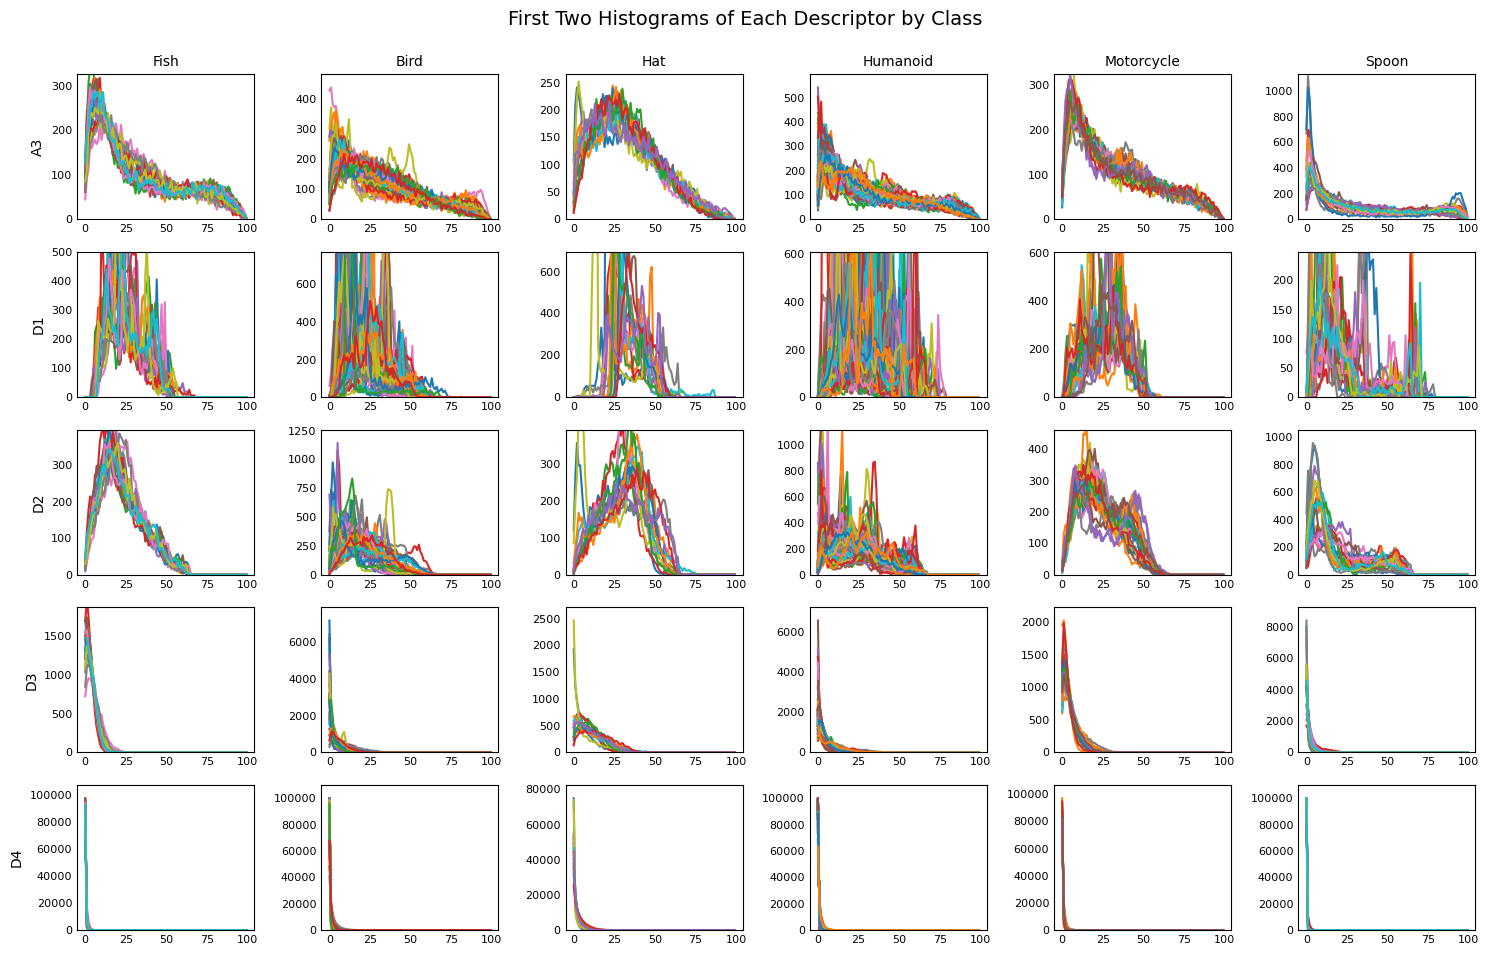

In [102]:
import matplotlib.pyplot as plt

def plot_descriptors_for_classes(df):
    target_classes = ['Fish','Bird','Hat','Humanoid','Motorcycle','Spoon']
    hist_keys = ["A3", "D1", "D2", "D3", "D4"]
    
    fig, axes = plt.subplots(len(hist_keys), len(target_classes), figsize=(15, 10))
    
    # Iterate over each descriptor (A3, D1, D2, etc.)
    for row_idx, hist_key in enumerate(hist_keys):
        for col_idx, class_name in enumerate(target_classes):
            selected_rows = df[(df['mesh_class'] == class_name)][['mesh_class', hist_key]]
            
            histograms = []
            
            # Convert each descriptor data to a list if necessary
            for _, row in selected_rows.iterrows():
                histogram = row[hist_key]
                if isinstance(histogram, str):  # Convert string to list of floats if needed
                    histogram = [float(x) for x in histogram.strip("[]").split()]
                histograms.append(histogram)
            
            ax = axes[row_idx, col_idx]
            for idx, histogram in enumerate(histograms, start=1):
                ax.plot(histogram, label=f"{class_name} - Histogram {idx}", linewidth=1.5)
            
            if col_idx == 0:
                ax.set_ylabel(f"{hist_key}", fontsize=10)
            if row_idx == 0:
                ax.set_title(class_name, fontsize=10)
            
            ax.set_ylim(0, max(max(histograms, default=[0])) * 1.1 if histograms else 1)  # Adjust y-scale based on histogram values
            ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("First Two Histograms of Each Descriptor by Class", fontsize=14)
    plt.show()

plot_descriptors_for_classes(df)

In [ ]:
def plot_first_two_A3_histograms(df):
    # Filter the DataFrame for the 'A3' column and select the first two rows for the 'Jet' class
    first_two_rows = df[df['mesh_class'] == 'Jet'][['mesh_class',  "A3"]]
    
    histograms = []
    class_names = []
    
    for _, row in first_two_rows.iterrows():
        histogram = row[ "A3"]
        if isinstance(histogram, str):  # Check if it's a string
            histogram = [float(x) for x in histogram.strip("[]").split()]
        
        histograms.append(histogram)
        class_names.append(row['mesh_class'])  # Store the class name
    
    # Plot the histograms
    plt.figure(figsize=(8, 5))
    for idx, (histogram, class_name) in enumerate(zip(histograms, class_names), start=1):
        plt.plot(histogram, label=f"{class_name} - Histogram {idx}", linewidth=1.5)
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    plt.title("First Two Histograms of 'A3' Descriptor")
    plt.ylim(0, max(max(histograms)) * 1.1) 
    plt.show()

plot_first_two_A3_histograms(df)

# Step 4: Querying

In [81]:
def read_elementary_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [82]:
def Standarize_el_features(el_Features_df):
    cols_to_normalize = el_Features_df.columns[1:]
    
    scaler = StandardScaler()
    
    el_Features_df[cols_to_normalize] = scaler.fit_transform(el_Features_df[cols_to_normalize])
    
    return el_Features_df

In [83]:
def read_descriptor_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [84]:
def calculate_emd(histogram1, histogram2):
  """
  Calculates the Earth Mover's Distance (EMD) between two histograms.

  Args:
    histogram1: A NumPy array representing the first histogram.
    histogram2: A NumPy array representing the second histogram.

  Returns:
    The EMD between the two histograms.
  """
  emd = wasserstein_distance(histogram1, histogram2)
  return emd

In [85]:
def emd_dist_of_descriptors(histogram_norm_df):
    histogram_features_distances = histogram_norm_df.copy()

    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in range(histogram_norm_df.shape[0]):
            Query_hist = histogram_norm_df.iloc[0, column_index]
            Db_hist = histogram_norm_df.iloc[index, column_index]

            if isinstance(Query_hist, str):
                Query_hist = np.fromiter(Query_hist[1:-1].split(), dtype=float)
            if isinstance(Db_hist, str):
                Db_hist = np.fromiter(Db_hist[1:-1].split(), dtype=float)

            # Calculate EMD or set to 0 if same
            emd_distance = 0.0 if np.array_equal(Query_hist, Db_hist) else np.abs(calculate_emd(Query_hist, Db_hist))
            histogram_features_distances.iloc[index, column_index] = emd_distance

    
    return histogram_features_distances

In [86]:
def norm_descriptors_distances(histogram_features_distances):
    cols_to_normalize = histogram_features_distances.columns[1:]

    scaler = StandardScaler()

    histogram_features_distances_stand = histogram_features_distances.copy()
    histogram_features_distances_stand[cols_to_normalize] = scaler.fit_transform(histogram_features_distances[cols_to_normalize])
    
    return histogram_features_distances_stand

In [87]:

def area_norm_bins(histogram_df):
    histogram_norm_df = histogram_df.copy()
    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in histogram_norm_df.index:
            value = histogram_df.iloc[index, column_index]

            if isinstance(value, np.ndarray):
                array_sum = np.sum(value)
                
                histogram_norm_df.iloc[index, column_index] = value / array_sum

            elif isinstance(value, str):
                try:
                    value = value.replace("[", "").replace("]", "")
                    value = value.split()
                    value = np.array(value, dtype=float)
                    array_sum = np.sum(value)
                    histogram_norm_df.iloc[index, column_index] = value / array_sum
                except (ValueError, TypeError) as e:
                    print(f"Error converting string to float array: {e}")

    return histogram_norm_df

In [88]:
def euclidean_distance(row1, row2):
  """
  Calculates the Euclidean distance between two feature vectors.

  Args:
    row1: A pandas Series representing the first feature vector.
    row2: A pandas Series representing the second feature vector.

  Returns:
    The Euclidean distance between the two vectors.
  """
  features1 = row1.iloc[1:].values
  features2 = row2.iloc[1:].values
  distance = np.sqrt(np.sum((features1 - features2)**2))
  return distance

In [90]:

def calculate_ef_distances(el_features_df, histogram_features_distances_stand):
    ef_distances = []
    All_features_dist = histogram_features_distances_stand.copy()

    Query_hist = el_features_df.iloc[0]

    # Calculate Euclidean distances and store in list
    for index in range(el_features_df.shape[0]):
        Db_hist = el_features_df.iloc[index]
        ef_distance = euclidean_distance(Query_hist, Db_hist)
        ef_distances.append(ef_distance)

    All_features_dist['elementary_f_dist'] = ef_distances

    # Filter for numeric columns only to avoid issues during summation
    numeric_columns = All_features_dist.select_dtypes(include=['number']).columns

    # Calculate and add 'Total_distance' column
    All_features_dist['Total_distance'] = All_features_dist[numeric_columns].sum(axis=1)
    return All_features_dist

In [91]:
def get_shape_class(object_name, df):
    """
    Takes an object name and a CSV file path, and returns the corresponding
    value in the 'Shape Class' column for the given object.
    
    Parameters:
        object_name (str): The name of the object to search for.
        csv_file (str): The path to the CSV file.
        
    Returns:
        str or None: The shape class for the object if found, otherwise None.
    """
    row = df[df['Filename'] == object_name]
    
    if not row.empty:
        return row['Shape Class'].values[0]
    else:
        return None

In [92]:
def compute_features_for_query(file_name,mesh_path,database_stats):
    data = []
    mesh = vedo.load(mesh_path)
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    data.append({
        "objectID": file_name,
        "area": mesh.area(),
        "volume": mesh.volume(),
        "compactness": (mesh.area() ** 3) / (36 * np.pi * (mesh.volume() ** 2)),
        "rectangularity": mesh.volume() / compute_obb_volume(openmesh),
        "convexity": mesh.volume() / vedo.ConvexHull(mesh).volume(),
        "diameter": compute_diameter(mesh),
        "eccentricity": compute_eccentricity(mesh)
    })

    return data

In [93]:
def compute_descriptors_for_query(file_name, mesh_path, global_min_max):
    data = []
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    
    # Calculate descriptors for the single object
    data.append({
        "objectID": file_name,
        "A3": a3(openmesh),
        "D1": d1(openmesh),
        "D2": d2(openmesh),
        "D3": d3(openmesh),
        "D4": d4(openmesh),
    })
    
    df = pd.DataFrame(data)
    
    Descriptor_features_df = replace_with_bins(df, global_min_max)
    
    return Descriptor_features_df

In [94]:
def verify_descriptor_data(histogram_norm_df):
    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in range(histogram_norm_df.shape[0]):
            value = histogram_norm_df.iloc[index, column_index]
            
            if isinstance(value, str):
                try:
                    parsed_value = np.fromiter(value[1:-1].split(), dtype=float)
                    print(f"Row {index}, Column {column_index} parsed correctly as {parsed_value}")
                except ValueError:
                    print(f"Error parsing Row {index}, Column {column_index}: {value}")
            elif isinstance(value, (np.ndarray, list)):
                print(f"Row {index}, Column {column_index} is already an array: {value}")
            else:
                print(f"Unexpected format at Row {index}, Column {column_index}: {value}")

## GUI To Upload a File

In [546]:

app = Flask(__name__)
UPLOAD_FOLDER = './query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = ng_rok_token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df =read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
        database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
        global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")
        
        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            
            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,filepath,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,filepath,global_min_max)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
            
            el_Features_df = Standarize_el_features(el_Features_df)
            print("before norm bins:",Descriptor_features_df)
            histogram_norm_df = area_norm_bins(Descriptor_features_df)
            print("after norm bins:",histogram_norm_df)
            histogram_features_distances = emd_dist_of_descriptors(histogram_norm_df)
            print("before:",histogram_features_distances)
            histogram_features_distances_stand = norm_descriptors_distances(histogram_features_distances)
            print("before:",histogram_features_distances_stand)
            #histogram_features_distances_stand = histogram_features_distances_stand.apply(pd.to_numeric, errors='coerce')

            # Bonus part Additional weghting:

            # Weights for each column
            # weights = {
            #     1: 0.70 / 3,  # Column 1: 80% / 3 = ~26.67%
            #     2: 0.70 / 3,  # Column 2: 80% / 3 = ~26.67%
            #     3: 0.70 / 3,  # Column 3: 80% / 3 = ~26.67%
            #     4: 0.15,      # Column 4: 15%
            #     5: 0.15       # Column 5: 5%
            # }

            # # Apply weights to the DataFrame
            # #weighted_df = df.copy()  # Create a copy to avoid modifying the original
            # for col, weight in weights.items():
            #     histogram_features_distances_stand.iloc[:, col] *= weight



            #histogram_features_distances_stand = histogram_features_distances_stand.apply(pd.to_numeric, errors='coerce')

            # Get top 10 similar meshes and their distances
            All_features_dist = calculate_ef_distances(el_Features_df, histogram_features_distances_stand)
            print("All features dist unsorted:",All_features_dist)
            All_features_dist=All_features_dist.iloc[1:].sort_values(by=['Total_distance'])
            min_max_scaler = MinMaxScaler()
            All_features_dist['Total_distance'] = min_max_scaler.fit_transform(All_features_dist[['Total_distance']])

            # Get top 10 similar meshes and their distances, excluding the row where objectID == filename
            top_5_filtered = All_features_dist[All_features_dist['objectID'] != filename]

            # Get top 10 similar meshes and their distances
            top_5_ids = top_5_filtered.iloc[:10, 0].tolist()
            distances = top_5_filtered.iloc[:10]['Total_distance'].tolist()
            query_mesh = filepath
            mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids if obj_id != filename]

            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]
            if os.path.exists(filepath):
                os.remove(filepath)

            return render_template('mesh_visualization.html', original_plot=original_plot, similar_plots=zip(similar_plots, top_5_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'), title=f"Distance: {distance}" if distance else "Original Object")

    return plot.to_html()

public_url = ngrok.connect(5000).public_url
print(f" * Running on {public_url}")

app.run(host='0.0.0.0', port=5000)


 * Running on https://73e3-143-177-169-121.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.81:5000
Press CTRL+C to quit
192.168.1.81 - - [15/Nov/2024 01:53:30] "GET / HTTP/1.1" 200 -


Supersampling done. Initial vertices: 9900, Resampled vertices: 10068
Final resampled mesh saved to: ./query\m242.obj, Vertices: 10068
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
global min_max len: 5
Descriptor_features_df len: 6
before norm bins:         objectID                                                 A3  \
0      query.obj  [130, 238, 266, 246, 249, 243, 240, 191, 217, ...   
1      m1337.obj  [ 12  41  61  87 107 122 144 120 169 164 146 1...   
2      m1338.obj  [  9  25  52  63  71  94  79  97 111 131 127 1...   
3      m1339.obj  [ 76 118 172 184 193 213 203 193 199 243 204 1...   
4      m1340.obj  [153 175 286 306 330 271 205 174 156 156 141 1...   
...          ...                                                ...   
2479  D00687.obj  [ 85 123 151 125 150 130 121 140 156 158 172 1...   
2480  D00720.obj  [ 42  89 107 114  93 121 117 159 132 165 169 1...   
2481  D00782.obj  [167 175 131  85

192.168.1.81 - - [15/Nov/2024 01:53:50] "POST / HTTP/1.1" 200 -


# Step 5: Scalability

In [95]:
def expand_column(df, col_name):
    # Remove brackets and split values
    expanded = df[col_name].str.strip("[]").str.split(expand=True)
    # Rename columns for uniqueness
    expanded.columns = [f"{col_name}_{i+1}" for i in range(expanded.shape[1])]
    return expanded


## GUI To Upload a File

In [551]:
app = Flask(__name__)
UPLOAD_FOLDER = './query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = ng_rok_token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df =read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
        database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
        global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")
        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            
            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,filepath,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,filepath,global_min_max)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
            el_Features_df = Standarize_el_features(el_Features_df)
            # Rename 'Filename' to 'objectID' in database_stats for merging
            histogram_norm_df = area_norm_bins(Descriptor_features_df)
            histogram_norm_df.to_csv("./statistics/normhist.csv", index=False)
            histogram_norm_df=pd.read_csv("./statistics/normhist.csv")

            #print("after read csvvvvvvvvvvvvvvvvvvvvvvv",histogram_norm_df)
            

            
            # Apply the function to each of the target columns and concatenate back to the dataframe
            expanded_dfs = [expand_column(histogram_norm_df, col) for col in histogram_norm_df.columns[1:]]  # Skip 'objectID'
            expanded_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
           # expanded_df.to_csv("C:/Users/panos/Downloads/expanded.csv", index=False)
            

           # histogram_norm_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
            histogram_norm_df = expanded_df
            print("Expandedddddddddddddddddddddddddddddddddddddddd",histogram_norm_df.head(5))



            # Merge the DataFrames
            merged_df = pd.merge(el_Features_df, histogram_norm_df, on='objectID', how='inner')


            merged_df = merged_df.drop('objectID', axis=1)
            print("print after dropppppppppppppppppppppppppppppppppppppppppppppppppppppppppp",merged_df)

            feature_total=merged_df.to_numpy()[1:,:]

            # Combine features for KDTree


            tree = sp.spatial.KDTree(feature_total)#skip first
            feature_query = merged_df.to_numpy()[0, :]

            print(feature_query)
            # Find 6 nearest neighbors (5 most similar + 1 query itself)
            dist, indices = tree.query(feature_query, k=10)

            print("indicessssssssssss:",indices)

            similar_objects=[]
            # similar_objects = el_Features_df.index[indices]

            for i in indices:
              if el_Features_df.iloc[i]['objectID']!=filename:
               similar_objects.append(el_Features_df.iloc[i,0])



            print("similar objects:",similar_objects)
            # Get top 5 similar meshes and their distances
            top_5_ids = similar_objects
            distances = dist
            query_mesh = filepath
            # Paths for original and similar meshes

            mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids]

            # Generate plots
            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]
            if os.path.exists(filepath):
                os.remove(filepath)
            # Render HTML with original and similar objects
            return render_template('mesh_visualization.html', original_plot=original_plot, similar_plots=zip(similar_plots, top_5_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'), title=f"Distance: {distance}" if distance else "Original Object")

    # Convert plot to HTML string
    return plot.to_html()


# Expose Flask app with ngrok
public_url = ngrok.connect(5000).public_url
print(f" * Running on {public_url}")

app.run(host='0.0.0.0', port=5000)


 * Running on https://9495-143-177-169-121.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.81:5000
Press CTRL+C to quit
192.168.1.81 - - [15/Nov/2024 02:01:24] "GET / HTTP/1.1" 200 -


Final resampled mesh saved to: ./query\m235.obj, Vertices: 10000
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
global min_max len: 5
Descriptor_features_df len: 6
Expandedddddddddddddddddddddddddddddddddddddddd     objectID    A3_1    A3_2    A3_3    A3_4    A3_5    A3_6    A3_7    A3_8  \
0  query.obj  0.0076  0.0135  0.0208  0.0229  0.0224  0.0223  0.0235  0.0225   
1  m1337.obj  0.0012  0.0041  0.0061  0.0087  0.0107  0.0122  0.0144   0.012   
2  m1338.obj  0.0009  0.0025  0.0052  0.0063  0.0071  0.0094  0.0079  0.0097   
3  m1339.obj  0.0076  0.0118  0.0172  0.0184  0.0193  0.0213  0.0203  0.0193   
4  m1340.obj  0.0153  0.0175  0.0286  0.0306   0.033  0.0271  0.0205  0.0174   

     A3_9  ...       D4_91       D4_92       D4_93       D4_94       D4_95  \
0  0.0204  ...  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00   
1  0.0169  ...  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  

192.168.1.81 - - [15/Nov/2024 02:01:44] "POST / HTTP/1.1" 200 -


## Part 5.2

In [99]:
def expand_column(df, col_name):
    # Remove brackets and split values
    expanded = df[col_name].str.strip("[]").str.split(expand=True)
    # Rename columns for uniqueness
    expanded.columns = [f"{col_name}_{i+1}" for i in range(expanded.shape[1])]
    return expanded

In [100]:
# Read descriptor, elementary feature, and database stats data
Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
el_Features_df = read_descriptor_features(r"./statistics/shape_database_elementary_attributes.csv")
database_stats = read_descriptor_features(r"./statistics/shape_database_stats.csv")

# Rename 'Filename' to 'objectID' in database_stats for merging
database_stats = database_stats.rename(columns={'Filename': 'objectID'})

# Expand each target column in Descriptor_features_df and concatenate back to the DataFrame
expanded_dfs = [expand_column(Descriptor_features_df, col) for col in Descriptor_features_df.columns[1:]]
expanded_df = pd.concat([Descriptor_features_df[['objectID']]] + expanded_dfs, axis=1)

# Merge expanded_df with el_Features_df on 'objectID' to add columns from el_Features_df
expanded_df = expanded_df.merge(el_Features_df, on='objectID', how='left')

# Merge the Shape Class from database_stats into expanded_df
expanded_df = expanded_df.merge(database_stats[['objectID', 'Shape Class']], on='objectID', how='left')

# Reorder columns to place 'Shape Class' as the second column
cols = ['objectID', 'Shape Class'] + [col for col in expanded_df.columns if col not in ['objectID', 'Shape Class']]
expanded_df = expanded_df[cols]

expanded_df.head()

objectID      Shape Class A3_1 A3_2 A3_3 A3_4 A3_5 A3_6 A3_7 A3_8  ...  \
0  m1337.obj  AircraftBuoyant   12   41   61   87  107  122  144  120  ...   
1  m1338.obj  AircraftBuoyant    9   25   52   63   71   94   79   97  ...   
2  m1339.obj  AircraftBuoyant   76  118  172  184  193  213  203  193  ...   
3  m1340.obj  AircraftBuoyant  153  175  286  306  330  271  205  174  ...   
4  m1341.obj  AircraftBuoyant  148  308  394  389  376  396  356  314  ...   

  D4_98 D4_99 D4_100      area    volume compactness rectangularity convexity  \
0     0     0      0  2.770102  0.335257    1.672161       0.410810  0.888407   
1     0     0      0  3.598979  0.369862    3.013054       0.407566  0.862189   
2     0     0      0  2.756522  0.093257   21.294764       0.241328  0.553637   
3     0     0      0  0.561354  0.027847    2.017036       0.221579  0.611325   
4     0     0      0  0.671116  0.035075    2.172435       0.253718  0.684318   

   diameter eccentricity  
0  1.020280     2.619286  
1  1.046716     1.895304  
2  1.000033     5.680690  
3  1.000039    26.449918  
4  1.000000    34.460033  

[5 rows x 509 columns]

In [101]:
def get_all_features_for_part_5(df, exclude=None):
    total_features = []
    labels = []
    paths = []

    for i, row in df.iterrows():
        object_id = row['objectID']
        label = row['Shape Class']
        
        if exclude and object_id == exclude:
            continue
            
        features = row.drop(['objectID', 'Shape Class']).values
        features = [float(feature) for feature in features if feature != " "]
        
        total_features.append(features)
        labels.append(label)
        paths.append(f"/{label}/{object_id}")
    
    return np.array(total_features), labels, paths

In [102]:
def get_all_features(features_path, exclude=None):
    total_features = []
    labels = []
    paths = []
    with open(features_path, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=';', quotechar='|')
        
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue # Skip header row
            filepath = row[0]
            if exclude and filepath == exclude:
                continue # Exclude shape from returned features list if specified
            label = row.pop(1)
            row.pop(0)
            features = [float(feature.replace(" ", "")) for feature in row if feature != " "]
            total_features.append(features)
            labels.append(label)
            paths.append(filepath)
    
    return np.array(total_features), labels, paths

In [571]:
param_grid = {
    'perplexity': list(range(5, 61, 5)),
    'learning_rate': [12, 15, 20, 30, 50, 100],
    'early_exaggeration': [4, 6, 10, 12, 18, 20, 50],
    'n_iter': [500, 800, 1000, 3000, 5000, 10000],
    'init': ['pca', 'random'],
    'metric': ['euclidean', 'cosine', 'manhattan', 'chebyshev'],
}

def grid_search_tsne(feature_query, labels, param_grid):
    best_score = float('-inf')
    best_params = None
    best_embedding = None
    
    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for params in param_combinations:
        
        # Initialize TSNE with current parameters
        tsne = TSNE(
            n_components=2,
            perplexity=params['perplexity'],
            n_iter=params['n_iter'],
            learning_rate=params['learning_rate'],
            init=params['init'],
            early_exaggeration=params['early_exaggeration'],
            metric=params['metric']
        )
        
        embedding = tsne.fit_transform(feature_query)
        
        # Calculate silhouette score (assuming `labels` are the shape class labels)
        score = silhouette_score(embedding, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
            best_embedding = embedding
    
    print("Best Parameters:", best_params)
    print("Best Silhouette Score:", best_score)
    return best_embedding, best_params
features_total, labels, paths = get_all_features_for_part_5(expanded_df)
grid_search_tsne(features_total, labels, param_grid)

Best Parameters: {'perplexity': 5, 'learning_rate': 50, 'early_exaggeration': 12, 'n_iter': 5000, 'init': 'pca', 'metric': 'euclidean'}
Best Silhouette Score: -0.34419522


(array([[  4.6569595, 156.04552  ],
        [-14.454842 , 155.99522  ],
        [ -9.111774 , -16.51847  ],
        ...,
        [  8.899059 ,  75.84111  ],
        [-12.155308 ,  53.087734 ],
        [ 57.962    ,  94.34703  ]], dtype=float32),
 {'perplexity': 5,
  'learning_rate': 50,
  'early_exaggeration': 12,
  'n_iter': 5000,
  'init': 'pca',
  'metric': 'euclidean'})

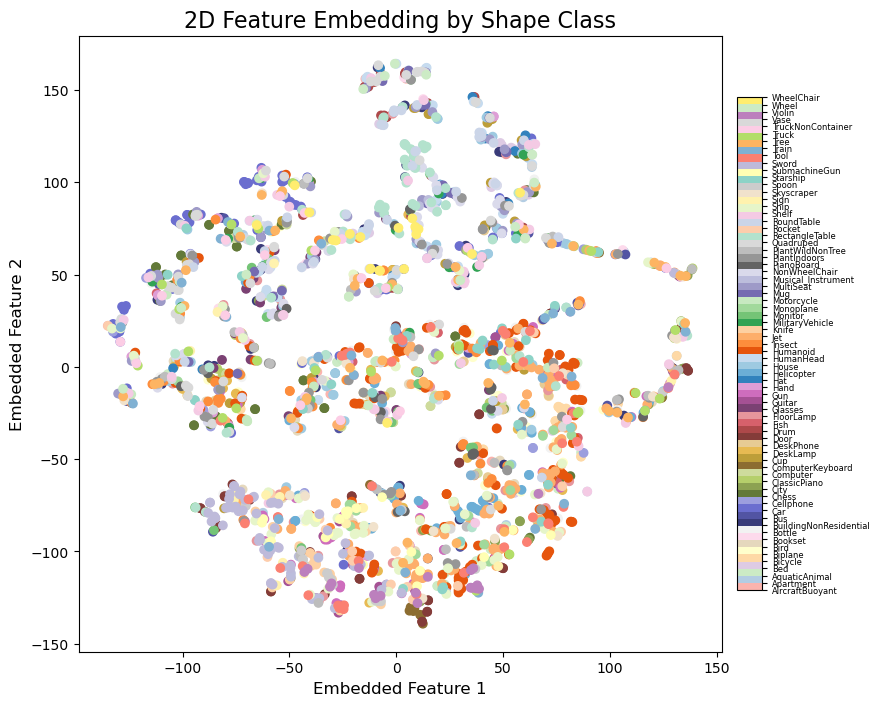

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE


def main(expanded_df):
    # Extract feature vectors, labels, and paths
    features_total, labels, paths = get_all_features_for_part_5(expanded_df)
    
    # Run the optimal t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=5,
        learning_rate=50,
        n_iter=5000,
        init='pca',
        metric='euclidean',
        early_exaggeration=12
    )
    features_embedded = tsne.fit_transform(features_total)
    
    # Define the colormap you want to use
    cmap1 = list(plt.cm.Pastel1.colors)
    cmap2 = list(plt.cm.tab20b.colors)
    cmap3 = list(plt.cm.tab20c.colors)
    cmap4 = list(plt.cm.Pastel2.colors)
    cmap5 = list(plt.cm.Set3.colors)     
    combined_cmap = cmap1 + cmap2 + cmap3 + cmap4 + cmap5
    
    cmap = plt.cm.colors.ListedColormap(combined_cmap)
    unique_labels = sorted(set(labels))
    colors_map = {label: i for i, label in enumerate(unique_labels)}
    colors = np.array([colors_map[label] for label in labels])

    def plot_tsne():
            fig, ax = plt.subplots(figsize=(10, 8))
            scatter = ax.scatter(features_embedded[:, 0], features_embedded[:, 1], c=colors, cmap=cmap)
            ax.set_title("2D Feature Embedding by Shape Class", fontsize=16)
            
            ax.set_xlabel("Embedded Feature 1", fontsize=12)
            ax.set_ylabel("Embedded Feature 2", fontsize=12)
            
            cbar = plt.colorbar(scatter, ticks=np.arange(len(unique_labels)), orientation='vertical', shrink=0.8, pad=0.02)
            cbar.ax.set_yticklabels(unique_labels, fontsize=6, wrap=True)
    
            plt.show()

    plot_tsne()

main(expanded_df)

# Step 6: Evaluation

In [105]:
def compute_evaluation_data(database_path):
    res = []
    el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
    Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
    database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
    global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")

    shape_classes = [f for f in os.listdir(database_path) if os.path.isdir(os.path.join(database_path, f))]
    
    for shape_class in tqdm(shape_classes, desc="Processing Shape Classes", unit="class"):
        shape_class_path = os.path.join(database_path, shape_class)
        
        # Get the number of objects in the current class (for `k`)
        class_files = [f for f in os.listdir(shape_class_path) if f.endswith(".obj")]
        k = len(class_files)

        # Iterate through each file in the current shape class
        for filename in tqdm(class_files, desc=f"Processing {shape_class}", unit="file", leave=False):
            mesh_path = os.path.join(shape_class_path, filename)

            # Compute query results with the number of class objects as `k`
            query_results = compute_query_from_step_4(filename, mesh_path, el_Features_df, Descriptor_features_df, database_stats, global_min_max, k)

            # Determine class labels for each result
            class_names_of_res = [
                1 if get_shape_class(result, database_stats) == shape_class else 0
                for result in query_results
            ]

            res.append({
                "objectID": filename,
                "evaluated": class_names_of_res
            })
    
    return res


In [106]:
def compute_query_from_step_4(filename, mesh_path, el_Features_df, Descriptor_features_df, database_stats, global_min_max, k):
    # Step 1: Extract query mesh features
    query_features = compute_features_for_query(filename, mesh_path, database_stats)
    query_hist_features = compute_descriptors_for_query(filename, mesh_path, global_min_max)
    
    # Step 2: Prepare query feature dataframes
    query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
    query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
    
    # Step 3: Prepend query features to the existing feature dataframes
    el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
    Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
    
    # Step 4: Label the query object
    el_Features_df.loc[0, 'objectID'] = "query.obj"
    Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
    
    # Step 5: Standardize the features
    el_Features_df = Standarize_el_features(el_Features_df)
    
    # Step 6: Normalize the histogram features and compute distance metrics
    histogram_norm_df = area_norm_bins(Descriptor_features_df)
    histogram_features_distances = emd_dist_of_descriptors(histogram_norm_df)
    histogram_features_distances_stand = norm_descriptors_distances(histogram_features_distances)
    
    # Step 7: Calculate the distances between features and normalize
    All_features_dist = calculate_ef_distances(el_Features_df, histogram_features_distances_stand)
    All_features_dist = All_features_dist.iloc[1:].sort_values(by=['Total_distance'])
    
    # Normalize the total distance column
    min_max_scaler = MinMaxScaler()
    All_features_dist['Total_distance'] = min_max_scaler.fit_transform(All_features_dist[['Total_distance']])
    
    # Step 8: Get top k similar meshes and their distances
    top_k = All_features_dist.iloc[:k, 0].tolist()
    
    return top_k


In [107]:
def compute_query_from_step_5(filename, mesh_path, el_Features_df, Descriptor_features_df, database_stats, global_min_max, k):
    # Step 1: Extract query mesh features
    query_features = compute_features_for_query(filename, mesh_path, database_stats)
    query_hist_features = compute_descriptors_for_query(filename, mesh_path, global_min_max)
    
    # Step 2: Prepare query feature dataframes
    query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
    query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
    
    # Step 3: Prepend query features to the existing feature dataframes
    el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
    Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
    
    # Step 4: Label the query object
    el_Features_df.loc[0, 'objectID'] = "query.obj"
    Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
    
    # Step 5: Standardize the features
    el_Features_df = Standarize_el_features(el_Features_df)
    
    # Step 6: Normalize the histogram features and compute distance metrics
    histogram_norm_df = area_norm_bins(Descriptor_features_df)
    histogram_norm_df.to_csv("./statistics/normhist.csv", index=False)
    histogram_norm_df=pd.read_csv("./statistics/normhist.csv")
    # Apply the function to each of the target columns and concatenate back to the dataframe
    expanded_dfs = [expand_column(histogram_norm_df, col) for col in histogram_norm_df.columns[1:]]  # Skip 'objectID'
    expanded_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
    histogram_norm_df = expanded_df
    merged_df = pd.merge(el_Features_df, histogram_norm_df, on='objectID', how='inner')
    merged_df = merged_df.drop('objectID', axis=1)
    feature_total=merged_df.to_numpy()[1:,:]
    tree = sp.spatial.KDTree(feature_total)#skip first
    feature_query = merged_df.to_numpy()[0, :]
    dist, indices = tree.query(feature_query, k=k)
    top_k = []
    for i in indices:
        top_k.append(el_Features_df.iloc[i,0])
    return top_k

In [108]:
def compute_query_from_step_4_bonus(filename, mesh_path, el_Features_df, Descriptor_features_df, database_stats, global_min_max, k):
    # Step 1: Extract query mesh features
    query_features = compute_features_for_query(filename, mesh_path, database_stats)
    query_hist_features = compute_descriptors_for_query(filename, mesh_path, global_min_max)
    
    # Step 2: Prepare query feature dataframes
    query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
    query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
    
    # Step 3: Prepend query features to the existing feature dataframes
    el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
    Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
    
    # Step 4: Label the query object
    el_Features_df.loc[0, 'objectID'] = "query.obj"
    Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
    
    # Step 5: Standardize the features
    el_Features_df = Standarize_el_features(el_Features_df)
    
    # Step 6: Normalize the histogram features and compute distance metrics
    histogram_norm_df = area_norm_bins(Descriptor_features_df)
    histogram_features_distances = emd_dist_of_descriptors(histogram_norm_df)
    histogram_features_distances_stand = norm_descriptors_distances(histogram_features_distances)
    
    weights = {
                1: 0.70 / 3,  # Column 1: 80% / 3 = ~26.67%
                2: 0.70 / 3,  # Column 2: 80% / 3 = ~26.67%
                3: 0.70 / 3,  # Column 3: 80% / 3 = ~26.67%
                4: 0.15,      # Column 4: 15%
                5: 0.15       # Column 5: 5%
    }
    
            # Apply weights to the DataFrame
            #weighted_df = df.copy()  # Create a copy to avoid modifying the original
    for col, weight in weights.items():
        histogram_features_distances_stand.iloc[:, col] *= weight
    
    # Step 7: Calculate the distances between features and normalize
    All_features_dist = calculate_ef_distances(el_Features_df, histogram_features_distances_stand)
    All_features_dist = All_features_dist.iloc[1:].sort_values(by=['Total_distance'])
    
    # Normalize the total distance column
    min_max_scaler = MinMaxScaler()
    All_features_dist['Total_distance'] = min_max_scaler.fit_transform(All_features_dist[['Total_distance']])
    
    # Step 8: Get top k similar meshes and their distances
    top_k = All_features_dist.iloc[:k, 0].tolist()
    return top_k


In [ ]:
evaluation_dataset = "./data/ShapeDatabase_INFOMR-master_normalized/"
evaluation_df = compute_evaluation_data(evaluation_dataset)
# evaluation_df.to_csv("./statistics/evaluation_data.csv", index=False)


In [ ]:
evaluation_df.to_csv("./statistics/evaluation_data.csv", index=False)

In [ ]:
evaluation_df

In [134]:
# Specify the output file name
output_file = './statistics/evaluation_data_part_4.csv'

# Open the file for writing
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(['objectID', 'evaluated'])
    
    # Write data rows
    for entry in data:
        # Convert the evaluated list to a string
        evaluated_str = str(entry['evaluated'])
        writer.writerow([entry['objectID'], evaluated_str])

print(f'Data successfully exported to {output_file}')

Data successfully exported to ./statistics/evaluation_data_part_4.csv


In [ ]:
expanded_df.merge(database_stats[['objectID', 'Shape Class']], on='objectID', how='left')

In [136]:
data_df = pd.DataFrame(evaluation_df)
merged_df = data_df.merge(database_stats[['objectID', 'Shape Class']], on='objectID', how='left')
# Convert 'evaluated' list to string format for CSV export
merged_df['evaluated'] = merged_df['evaluated'].apply(str)

In [138]:
merged_df.head(6)

objectID                                         evaluated  \
0  m1337.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
1  m1338.obj  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2  m1339.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3  m1340.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   
4  m1341.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
5  m1342.obj  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

       Shape Class  
0  AircraftBuoyant  
1  AircraftBuoyant  
2  AircraftBuoyant  
3  AircraftBuoyant  
4  AircraftBuoyant  
5  AircraftBuoyant

In [140]:
output_file = './statistics/evaluation_data_part_4.csv'
merged_df.to_csv(output_file, index=False, columns=['objectID', 'Shape Class', 'evaluated'])
print(f'Data successfully exported to {output_file}')

Data successfully exported to ./statistics/evaluation_data_part_4.csv


In [173]:
#checking that all the values are binary in our database
df = merged_df
output = []
for i in range(len(df.columns)):
    for x in df['evaluated'][i]:
        if x not in output:
            output.append(x)
print(output)


[1, 0]


In [182]:
merged_df['Shape Class'].unique()

array(['AircraftBuoyant', 'Apartment', 'AquaticAnimal', 'Bed', 'Bicycle',
       'Biplane', 'Bird', 'Bookset', 'Bottle', 'BuildingNonResidential',
       'Bus', 'Car', 'Cellphone', 'Chess', 'City', 'ClassicPiano',
       'Computer', 'ComputerKeyboard', 'Cup', 'DeskLamp', 'DeskPhone',
       'Door', 'Drum', 'Fish', 'FloorLamp', 'Glasses', 'Guitar', 'Gun',
       'Hand', 'Hat', 'Helicopter', 'House', 'HumanHead', 'Humanoid',
       'Insect', 'Jet', 'Knife', 'MilitaryVehicle', 'Monitor',
       'Monoplane', 'Motorcycle', 'Mug', 'MultiSeat',
       'Musical_Instrument', 'NonWheelChair', 'PianoBoard',
       'PlantIndoors', 'PlantWildNonTree', 'Quadruped', 'RectangleTable',
       'Rocket', 'RoundTable', 'Shelf', 'Ship', 'Sign', 'Skyscraper',
       'Spoon', 'Starship', 'SubmachineGun', 'Sword', 'Tool', 'Train',
       'Tree', 'Truck', 'TruckNonContainer', 'Vase', 'Violin', 'Wheel',
       'WheelChair'], dtype=object)

In [ ]:
Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_with_bins.csv")
Descriptor_features_df

In [128]:
Descriptor_features_df

objectID                                                 A3  \
0      m1337.obj  [ 12  41  61  87 107 122 144 120 169 164 146 1...   
1      m1338.obj  [  9  25  52  63  71  94  79  97 111 131 127 1...   
2      m1339.obj  [ 76 118 172 184 193 213 203 193 199 243 204 1...   
3      m1340.obj  [153 175 286 306 330 271 205 174 156 156 141 1...   
4      m1341.obj  [148 308 394 389 376 396 356 314 269 200 174 1...   
...          ...                                                ...   
2478  D00687.obj  [ 85 123 151 125 150 130 121 140 156 158 172 1...   
2479  D00720.obj  [ 42  89 107 114  93 121 117 159 132 165 169 1...   
2480  D00782.obj  [167 175 131  85  77  92  99 102 108 139 157 1...   
2481  D00821.obj  [ 87 125 127 119 124 140 153 128 161 136 152 1...   
2482  D00846.obj  [ 69 109  96  93  98  91 110 144 128 141 151 1...   

                                                     D1  \
0     [  0   0   0   0   0   0   0   0   0   0   0  ...   
1     [   0    0    0    0    0    0    0    0    0 ...   
2     [384 444 332  86 180 191 112  58  34  56  63 2...   
3     [  0   0   0   0   0   0   0  10  13  10 531 9...   
4     [  0   0   0   0   0   0 287 109  78 136  52  ...   
...                                                 ...   
2478  [  0   0   0   0   0   4   5  13  26  46  54  ...   
2479  [  0  10  12  16  28  42  27  58  59  98  76  ...   
2480  [  17   65   57   77   76   21   19   20   19 ...   
2481  [  0   0   0   0   0   2  11  29  37  58  48  ...   
2482  [  0   0   0   0   9  12  24  23  73  87 116  ...   

                                                     D2  \
0     [  5  17  29  46  38  47  63  75  86 111 104 1...   
1     [  1   7  15  15  28  36  42  51  44  68  54  ...   
2     [ 85 191 123 155 153 191 223 356 454 548 445 3...   
3     [ 133  264  388  445  470  512  611  778 1210 ...   
4     [ 45 147 211 320 338 410 467 517 490 406 292 2...   
...                                                 ...   
2478  [ 44  66  83 103  83  84  92  95  88  91 120 1...   
2479  [ 20  41  65  55  71  95 116 115 136 127 168 1...   
2480  [ 98 259 133  64  37  41  45  43  48  64  64  ...   
2481  [ 36  71  80  83 113  90  77  86  81  95 105 1...   
2482  [ 34  61  93  87  60  58  57  51  67  76  88  ...   

                                                     D3  \
0     [216 312 388 370 399 372 349 397 323 348 367 3...   
1     [100 154 187 218 262 263 286 279 267 291 275 2...   
2     [2025 1844 1384  908  626  561  455  382  291 ...   
3     [4390 1231  578  713  725  644  565  392  221 ...   
4     [2637 2033 1698 1214  918  560  337  231  144 ...   
...                                                 ...   
2478  [775 744 685 592 684 678 646 550 568 571 552 4...   
2479  [581 775 826 795 805 738 697 640 615 545 537 4...   
2480  [1265  584  385  386  391  450  632  685  521 ...   
2481  [775 773 705 642 613 694 637 606 550 620 546 4...   
2482  [474 519 455 472 508 494 540 570 563 563 504 5...   

                                                     D4  
0     [27125 15474 11141  8723  6772  5608  4440  38...  
1     [16767 12402 10246  8826  7484  6565  5717  50...  
2     [85063  8761  3067  1397   746   422   233   1...  
3     [96096  3345   459    85    13     2     0    ...  
4     [98464  1393   113    20     8     2     0    ...  
...                                                 ...  
2478  [57207 19201 10634  6193  3389  1713   884   4...  
2479  [57976 20513 10642  5642  2793  1305   617   3...  
2480  [52339 13703 11015  7087  5621  3222  2667  14...  
2481  [56988 19489 10572  6115  3462  1672   922   4...  
2482  [42839 19024 12753  8538  5733  3841  2542  18...  

[2483 rows x 6 columns]

In [ ]:
filepath = "./data/ShapeDatabase_INFOMR-master_normalized/AircraftBuoyant/m1337.obj"
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
query_hist_features = compute_descriptors_for_query("m1337.obj",filepath,database_stats)
query_hist_features

In [ ]:
def compute_descriptors_for_query(file_name,mesh_path,database_stats):
    data = []
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    data.append({
        "objectID": file_name,
        "A3": a3(openmesh),
        "D1": d1(openmesh),
        "D2": d2(openmesh),
        "D3": d3(openmesh),
        "D4": d4(openmesh),
    })
    df = pd.DataFrame(data)
    global_min_max=return_global_min_max(df)
    Descriptor_features_df = replace_with_bins(df,global_min_max)
    return Descriptor_features_df

In [ ]:
Descriptor_features_df.iloc[0] =query_hist_features

In [ ]:
Descriptor_features_df

## Queries for using part 5:

In [190]:
def compute_evaluation_data_part_5(database_path):
    res = []
    # Read the database statistics once, instead of reading it every time in the loop
    el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
    Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
    database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
    global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")

    # Traverse through all folders in the database with progress bar
    shape_classes = [f for f in os.listdir(database_path) if os.path.isdir(os.path.join(database_path, f))]
    
    for shape_class in tqdm(shape_classes, desc="Processing Shape Classes", unit="class"):
        shape_class_path = os.path.join(database_path, shape_class)
        
        # Get the number of objects in the current class (for `k`)
        class_files = [f for f in os.listdir(shape_class_path) if f.endswith(".obj")]
        k = len(class_files)

        # Iterate through each file in the current shape class
        for filename in tqdm(class_files, desc=f"Processing {shape_class}", unit="file", leave=False):
            # Full path to the mesh file
            mesh_path = os.path.join(shape_class_path, filename)

            # Compute query results with the number of class objects as `k`
            query_results = compute_query_from_step_5(filename, mesh_path, el_Features_df, Descriptor_features_df, database_stats, global_min_max, k)

            # Determine class labels for each result
            class_names_of_res = [
                1 if get_shape_class(result, database_stats) == shape_class else 0
                for result in query_results
            ]

            # Append the result to the final list
            res.append({
                "objectID": filename,
                "evaluated": class_names_of_res
            })
    
    return res

In [191]:
evaluation_dataset = "./data/ShapeDatabase_INFOMR-master_normalized/"
evaluation_df = compute_evaluation_data_part_5(evaluation_dataset)

Processing AircraftBuoyant:   0%|                                                                                  | 0/16 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:   6%|████▋                                                                     | 1/16 [00:12<03:03, 12.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  12%|█████████▎                                                                | 2/16 [00:24<02:49, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  19%|█████████████▉                                                            | 3/16 [00:34<02:26, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  25%|██████████████████▌                                                       | 4/16 [00:46<02:18, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  31%|███████████████████████▏                                                  | 5/16 [00:58<02:08, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  38%|███████████████████████████▊                                              | 6/16 [01:10<01:56, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  44%|████████████████████████████████▍                                         | 7/16 [01:22<01:48, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  50%|█████████████████████████████████████                                     | 8/16 [01:34<01:35, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  56%|█████████████████████████████████████████▋                                | 9/16 [01:46<01:23, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  62%|█████████████████████████████████████████████▋                           | 10/16 [01:58<01:12, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  69%|██████████████████████████████████████████████████▏                      | 11/16 [02:10<01:00, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  75%|██████████████████████████████████████████████████████▊                  | 12/16 [02:23<00:48, 12.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  81%|███████████████████████████████████████████████████████████▎             | 13/16 [02:34<00:35, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  88%|███████████████████████████████████████████████████████████████▉         | 14/16 [02:46<00:23, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AircraftBuoyant:  94%|████████████████████████████████████████████████████████████████████▍    | 15/16 [02:57<00:11, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:   0%|                                                                                        | 0/23 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:   4%|███▍                                                                            | 1/23 [00:12<04:25, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:   9%|██████▉                                                                         | 2/23 [00:24<04:13, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  13%|██████████▍                                                                     | 3/23 [00:36<04:02, 12.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  17%|█████████████▉                                                                  | 4/23 [00:47<03:44, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  22%|█████████████████▍                                                              | 5/23 [00:56<03:13, 10.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  26%|████████████████████▊                                                           | 6/23 [01:08<03:09, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  30%|████████████████████████▎                                                       | 7/23 [01:20<03:03, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  35%|███████████████████████████▊                                                    | 8/23 [01:31<02:51, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  39%|███████████████████████████████▎                                                | 9/23 [01:41<02:32, 10.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  43%|██████████████████████████████████▎                                            | 10/23 [01:50<02:14, 10.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  48%|█████████████████████████████████████▊                                         | 11/23 [02:02<02:09, 10.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  52%|█████████████████████████████████████████▏                                     | 12/23 [02:13<02:00, 10.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  57%|████████████████████████████████████████████▋                                  | 13/23 [02:25<01:51, 11.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  61%|████████████████████████████████████████████████                               | 14/23 [02:37<01:43, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  65%|███████████████████████████████████████████████████▌                           | 15/23 [02:48<01:31, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  70%|██████████████████████████████████████████████████████▉                        | 16/23 [03:00<01:20, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  74%|██████████████████████████████████████████████████████████▍                    | 17/23 [03:13<01:10, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  78%|█████████████████████████████████████████████████████████████▊                 | 18/23 [03:24<00:58, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  83%|█████████████████████████████████████████████████████████████████▎             | 19/23 [03:34<00:44, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  87%|████████████████████████████████████████████████████████████████████▋          | 20/23 [03:45<00:33, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  91%|████████████████████████████████████████████████████████████████████████▏      | 21/23 [03:57<00:22, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Apartment:  96%|███████████████████████████████████████████████████████████████████████████▌   | 22/23 [04:10<00:11, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:   0%|                                                                                    | 0/29 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:   3%|██▌                                                                         | 1/29 [00:12<05:56, 12.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:   7%|█████▏                                                                      | 2/29 [00:25<05:48, 12.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  10%|███████▊                                                                    | 3/29 [00:38<05:35, 12.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  14%|██████████▍                                                                 | 4/29 [00:50<05:15, 12.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  17%|█████████████                                                               | 5/29 [01:03<05:04, 12.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  21%|███████████████▋                                                            | 6/29 [01:15<04:47, 12.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  24%|██████████████████▎                                                         | 7/29 [01:23<04:03, 11.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  28%|████████████████████▉                                                       | 8/29 [01:35<03:58, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  31%|███████████████████████▌                                                    | 9/29 [01:47<03:51, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  34%|█████████████████████████▊                                                 | 10/29 [01:59<03:42, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  38%|████████████████████████████▍                                              | 11/29 [02:12<03:32, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  41%|███████████████████████████████                                            | 12/29 [02:23<03:21, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  45%|█████████████████████████████████▌                                         | 13/29 [02:36<03:10, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  48%|████████████████████████████████████▏                                      | 14/29 [02:47<02:58, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  52%|██████████████████████████████████████▊                                    | 15/29 [03:00<02:49, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  55%|█████████████████████████████████████████▍                                 | 16/29 [03:12<02:35, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  59%|███████████████████████████████████████████▉                               | 17/29 [03:23<02:22, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  62%|██████████████████████████████████████████████▌                            | 18/29 [03:35<02:10, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  66%|█████████████████████████████████████████████████▏                         | 19/29 [03:47<01:58, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  69%|███████████████████████████████████████████████████▋                       | 20/29 [03:59<01:46, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  72%|██████████████████████████████████████████████████████▎                    | 21/29 [04:11<01:35, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  76%|████████████████████████████████████████████████████████▉                  | 22/29 [04:22<01:22, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  79%|███████████████████████████████████████████████████████████▍               | 23/29 [04:34<01:10, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  83%|██████████████████████████████████████████████████████████████             | 24/29 [04:46<00:58, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  86%|████████████████████████████████████████████████████████████████▋          | 25/29 [04:58<00:47, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  90%|███████████████████████████████████████████████████████████████████▏       | 26/29 [05:10<00:35, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  93%|█████████████████████████████████████████████████████████████████████▊     | 27/29 [05:21<00:23, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing AquaticAnimal:  97%|████████████████████████████████████████████████████████████████████████▍  | 28/29 [05:34<00:11, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:   0%|                                                                                              | 0/27 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:   4%|███▏                                                                                  | 1/27 [00:11<05:08, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:   7%|██████▎                                                                               | 2/27 [00:23<04:56, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  11%|█████████▌                                                                            | 3/27 [00:34<04:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  15%|████████████▋                                                                         | 4/27 [00:47<04:32, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  19%|███████████████▉                                                                      | 5/27 [00:58<04:13, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  22%|███████████████████                                                                   | 6/27 [01:10<04:08, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  26%|██████████████████████▎                                                               | 7/27 [01:22<03:58, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  30%|█████████████████████████▍                                                            | 8/27 [01:34<03:47, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  33%|████████████████████████████▋                                                         | 9/27 [01:46<03:36, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  37%|███████████████████████████████▍                                                     | 10/27 [01:58<03:22, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  41%|██████████████████████████████████▋                                                  | 11/27 [02:10<03:10, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  44%|█████████████████████████████████████▊                                               | 12/27 [02:22<02:58, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  48%|████████████████████████████████████████▉                                            | 13/27 [02:36<02:54, 12.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  52%|████████████████████████████████████████████                                         | 14/27 [02:47<02:39, 12.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  56%|███████████████████████████████████████████████▏                                     | 15/27 [02:59<02:26, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  59%|██████████████████████████████████████████████████▎                                  | 16/27 [03:12<02:13, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  63%|█████████████████████████████████████████████████████▌                               | 17/27 [03:23<02:00, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  67%|████████████████████████████████████████████████████████▋                            | 18/27 [03:35<01:47, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  70%|███████████████████████████████████████████████████████████▊                         | 19/27 [03:47<01:35, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  74%|██████████████████████████████████████████████████████████████▉                      | 20/27 [03:57<01:20, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  78%|██████████████████████████████████████████████████████████████████                   | 21/27 [04:10<01:10, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  81%|█████████████████████████████████████████████████████████████████████▎               | 22/27 [04:22<00:59, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  85%|████████████████████████████████████████████████████████████████████████▍            | 23/27 [04:34<00:47, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  89%|███████████████████████████████████████████████████████████████████████████▌         | 24/27 [04:46<00:35, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  93%|██████████████████████████████████████████████████████████████████████████████▋      | 25/27 [04:58<00:24, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bed:  96%|█████████████████████████████████████████████████████████████████████████████████▊   | 26/27 [05:10<00:11, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:   0%|                                                                                          | 0/26 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:   4%|███▏                                                                              | 1/26 [00:11<04:56, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:   8%|██████▎                                                                           | 2/26 [00:23<04:45, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  12%|█████████▍                                                                        | 3/26 [00:35<04:33, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  15%|████████████▌                                                                     | 4/26 [00:47<04:21, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  19%|███████████████▊                                                                  | 5/26 [00:59<04:12, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  23%|██████████████████▉                                                               | 6/26 [01:12<04:01, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  27%|██████████████████████                                                            | 7/26 [01:24<03:49, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  31%|█████████████████████████▏                                                        | 8/26 [01:36<03:36, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  35%|████████████████████████████▍                                                     | 9/26 [01:48<03:25, 12.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  38%|███████████████████████████████▏                                                 | 10/26 [02:00<03:13, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  42%|██████████████████████████████████▎                                              | 11/26 [02:12<02:59, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  46%|█████████████████████████████████████▍                                           | 12/26 [02:23<02:47, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  50%|████████████████████████████████████████▌                                        | 13/26 [02:36<02:36, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  54%|███████████████████████████████████████████▌                                     | 14/26 [02:47<02:23, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  58%|██████████████████████████████████████████████▋                                  | 15/26 [02:59<02:11, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  62%|█████████████████████████████████████████████████▊                               | 16/26 [03:12<02:01, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  65%|████████████████████████████████████████████████████▉                            | 17/26 [03:24<01:48, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  69%|████████████████████████████████████████████████████████                         | 18/26 [03:36<01:37, 12.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  73%|███████████████████████████████████████████████████████████▏                     | 19/26 [03:49<01:26, 12.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  77%|██████████████████████████████████████████████████████████████▎                  | 20/26 [04:00<01:12, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  81%|█████████████████████████████████████████████████████████████████▍               | 21/26 [04:12<01:00, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  85%|████████████████████████████████████████████████████████████████████▌            | 22/26 [04:24<00:48, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  88%|███████████████████████████████████████████████████████████████████████▋         | 23/26 [04:36<00:35, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  92%|██████████████████████████████████████████████████████████████████████████▊      | 24/26 [04:48<00:23, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bicycle:  96%|█████████████████████████████████████████████████████████████████████████████▉   | 25/26 [05:00<00:12, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:   0%|                                                                                          | 0/45 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:   2%|█▊                                                                                | 1/45 [00:12<08:49, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:   4%|███▋                                                                              | 2/45 [00:23<08:34, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:   7%|█████▍                                                                            | 3/45 [00:32<07:25, 10.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:   9%|███████▎                                                                          | 4/45 [00:45<07:43, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  11%|█████████                                                                         | 5/45 [00:54<06:56, 10.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  13%|██████████▉                                                                       | 6/45 [01:05<07:04, 10.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  16%|████████████▊                                                                     | 7/45 [01:18<07:15, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  18%|██████████████▌                                                                   | 8/45 [01:30<07:13, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  20%|████████████████▍                                                                 | 9/45 [01:42<07:04, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  22%|██████████████████                                                               | 10/45 [01:55<06:59, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  24%|███████████████████▊                                                             | 11/45 [02:07<06:46, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  27%|█████████████████████▌                                                           | 12/45 [02:19<06:38, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  29%|███████████████████████▍                                                         | 13/45 [02:32<06:34, 12.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  31%|█████████████████████████▏                                                       | 14/45 [02:44<06:21, 12.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  33%|███████████████████████████                                                      | 15/45 [02:57<06:11, 12.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  36%|████████████████████████████▊                                                    | 16/45 [03:08<05:49, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  38%|██████████████████████████████▌                                                  | 17/45 [03:20<05:37, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  40%|████████████████████████████████▍                                                | 18/45 [03:32<05:24, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  42%|██████████████████████████████████▏                                              | 19/45 [03:41<04:50, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  44%|████████████████████████████████████                                             | 20/45 [03:53<04:42, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  47%|█████████████████████████████████████▊                                           | 21/45 [04:07<04:49, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  49%|███████████████████████████████████████▌                                         | 22/45 [04:19<04:36, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  51%|█████████████████████████████████████████▍                                       | 23/45 [04:31<04:26, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  53%|███████████████████████████████████████████▏                                     | 24/45 [04:43<04:14, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  56%|█████████████████████████████████████████████                                    | 25/45 [04:55<04:00, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  58%|██████████████████████████████████████████████▊                                  | 26/45 [05:07<03:51, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  60%|████████████████████████████████████████████████▌                                | 27/45 [05:19<03:36, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  62%|██████████████████████████████████████████████████▍                              | 28/45 [05:31<03:22, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  64%|████████████████████████████████████████████████████▏                            | 29/45 [05:42<03:09, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  67%|██████████████████████████████████████████████████████                           | 30/45 [05:54<02:58, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  69%|███████████████████████████████████████████████████████▊                         | 31/45 [06:06<02:47, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  71%|█████████████████████████████████████████████████████████▌                       | 32/45 [06:19<02:37, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  73%|███████████████████████████████████████████████████████████▍                     | 33/45 [06:32<02:27, 12.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  76%|█████████████████████████████████████████████████████████████▏                   | 34/45 [06:44<02:15, 12.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  78%|███████████████████████████████████████████████████████████████                  | 35/45 [06:56<02:01, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  80%|████████████████████████████████████████████████████████████████▊                | 36/45 [07:08<01:48, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  82%|██████████████████████████████████████████████████████████████████▌              | 37/45 [07:19<01:34, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  84%|████████████████████████████████████████████████████████████████████▍            | 38/45 [07:31<01:23, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  87%|██████████████████████████████████████████████████████████████████████▏          | 39/45 [07:43<01:10, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  89%|████████████████████████████████████████████████████████████████████████         | 40/45 [07:54<00:58, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  91%|█████████████████████████████████████████████████████████████████████████▊       | 41/45 [08:06<00:47, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  93%|███████████████████████████████████████████████████████████████████████████▌     | 42/45 [08:18<00:35, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  96%|█████████████████████████████████████████████████████████████████████████████▍   | 43/45 [08:29<00:23, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Biplane:  98%|███████████████████████████████████████████████████████████████████████████████▏ | 44/45 [08:41<00:11, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:   0%|                                                                                             | 0/44 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:   2%|█▉                                                                                   | 1/44 [00:11<08:33, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:   5%|███▊                                                                                 | 2/44 [00:23<08:19, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:   7%|█████▊                                                                               | 3/44 [00:35<08:07, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:   9%|███████▋                                                                             | 4/44 [00:47<07:56, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  11%|█████████▋                                                                           | 5/44 [00:59<07:44, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  14%|███████████▌                                                                         | 6/44 [01:11<07:37, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  16%|█████████████▌                                                                       | 7/44 [01:23<07:21, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  18%|███████████████▍                                                                     | 8/44 [01:35<07:06, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  20%|█████████████████▍                                                                   | 9/44 [01:47<06:54, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  23%|███████████████████                                                                 | 10/44 [01:58<06:41, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  25%|█████████████████████                                                               | 11/44 [02:10<06:29, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  27%|██████████████████████▉                                                             | 12/44 [02:22<06:17, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  30%|████████████████████████▊                                                           | 13/44 [02:34<06:05, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  32%|██████████████████████████▋                                                         | 14/44 [02:45<05:53, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  34%|████████████████████████████▋                                                       | 15/44 [02:58<05:45, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  36%|██████████████████████████████▌                                                     | 16/44 [03:10<05:35, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  39%|████████████████████████████████▍                                                   | 17/44 [03:22<05:23, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  41%|██████████████████████████████████▎                                                 | 18/44 [03:34<05:11, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  43%|████████████████████████████████████▎                                               | 19/44 [03:46<04:59, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  45%|██████████████████████████████████████▏                                             | 20/44 [03:58<04:47, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  48%|████████████████████████████████████████                                            | 21/44 [04:10<04:35, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  50%|██████████████████████████████████████████                                          | 22/44 [04:22<04:23, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  52%|███████████████████████████████████████████▉                                        | 23/44 [04:34<04:13, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  55%|█████████████████████████████████████████████▊                                      | 24/44 [04:46<04:01, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  57%|███████████████████████████████████████████████▋                                    | 25/44 [04:58<03:47, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  59%|█████████████████████████████████████████████████▋                                  | 26/44 [05:10<03:36, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  61%|███████████████████████████████████████████████████▌                                | 27/44 [05:22<03:25, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  64%|█████████████████████████████████████████████████████▍                              | 28/44 [05:34<03:15, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  66%|███████████████████████████████████████████████████████▎                            | 29/44 [05:47<03:03, 12.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  68%|█████████████████████████████████████████████████████████▎                          | 30/44 [05:59<02:50, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  70%|███████████████████████████████████████████████████████████▏                        | 31/44 [06:11<02:37, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  73%|█████████████████████████████████████████████████████████████                       | 32/44 [06:23<02:25, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  75%|███████████████████████████████████████████████████████████████                     | 33/44 [06:35<02:13, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  77%|████████████████████████████████████████████████████████████████▉                   | 34/44 [06:47<02:00, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  80%|██████████████████████████████████████████████████████████████████▊                 | 35/44 [06:58<01:45, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  82%|████████████████████████████████████████████████████████████████████▋               | 36/44 [07:10<01:33, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  84%|██████████████████████████████████████████████████████████████████████▋             | 37/44 [07:22<01:22, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  86%|████████████████████████████████████████████████████████████████████████▌           | 38/44 [07:34<01:11, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  89%|██████████████████████████████████████████████████████████████████████████▍         | 39/44 [07:46<00:59, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  91%|████████████████████████████████████████████████████████████████████████████▎       | 40/44 [07:58<00:48, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  93%|██████████████████████████████████████████████████████████████████████████████▎     | 41/44 [08:11<00:36, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  95%|████████████████████████████████████████████████████████████████████████████████▏   | 42/44 [08:23<00:24, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bird:  98%|██████████████████████████████████████████████████████████████████████████████████  | 43/44 [08:36<00:12, 12.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:   0%|                                                                                          | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:   5%|████                                                                              | 1/20 [00:08<02:49,  8.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  10%|████████▏                                                                         | 2/20 [00:17<02:39,  8.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  15%|████████████▎                                                                     | 3/20 [00:26<02:30,  8.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  20%|████████████████▍                                                                 | 4/20 [00:35<02:24,  9.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  25%|████████████████████▌                                                             | 5/20 [00:44<02:14,  8.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  30%|████████████████████████▌                                                         | 6/20 [00:53<02:04,  8.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  35%|████████████████████████████▋                                                     | 7/20 [01:02<01:55,  8.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  40%|████████████████████████████████▊                                                 | 8/20 [01:11<01:47,  8.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  45%|████████████████████████████████████▉                                             | 9/20 [01:20<01:38,  8.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  50%|████████████████████████████████████████▌                                        | 10/20 [01:29<01:30,  9.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  55%|████████████████████████████████████████████▌                                    | 11/20 [01:38<01:21,  9.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  60%|████████████████████████████████████████████████▌                                | 12/20 [01:47<01:11,  9.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  65%|████████████████████████████████████████████████████▋                            | 13/20 [01:56<01:02,  8.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  70%|████████████████████████████████████████████████████████▋                        | 14/20 [02:05<00:53,  8.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  75%|████████████████████████████████████████████████████████████▊                    | 15/20 [02:15<00:46,  9.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  80%|████████████████████████████████████████████████████████████████▊                | 16/20 [02:24<00:36,  9.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [02:33<00:27,  9.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [02:42<00:17,  8.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bookset:  95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:51<00:09,  9.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:   0%|                                                                                           | 0/31 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:   3%|██▋                                                                                | 1/31 [00:12<06:05, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:   6%|█████▎                                                                             | 2/31 [00:24<05:49, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  10%|████████                                                                           | 3/31 [00:36<05:37, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  13%|██████████▋                                                                        | 4/31 [00:48<05:25, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  16%|█████████████▍                                                                     | 5/31 [01:00<05:10, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  19%|████████████████                                                                   | 6/31 [01:11<04:58, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  23%|██████████████████▋                                                                | 7/31 [01:23<04:40, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  26%|█████████████████████▍                                                             | 8/31 [01:35<04:34, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  29%|████████████████████████                                                           | 9/31 [01:47<04:23, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  32%|██████████████████████████▍                                                       | 10/31 [01:59<04:08, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  35%|█████████████████████████████                                                     | 11/31 [02:10<03:56, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  39%|███████████████████████████████▋                                                  | 12/31 [02:22<03:43, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  42%|██████████████████████████████████▍                                               | 13/31 [02:33<03:29, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  45%|█████████████████████████████████████                                             | 14/31 [02:46<03:22, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  48%|███████████████████████████████████████▋                                          | 15/31 [02:58<03:10, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  52%|██████████████████████████████████████████▎                                       | 16/31 [03:10<02:59, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  55%|████████████████████████████████████████████▉                                     | 17/31 [03:21<02:44, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  58%|███████████████████████████████████████████████▌                                  | 18/31 [03:34<02:34, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  61%|██████████████████████████████████████████████████▎                               | 19/31 [03:45<02:23, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  65%|████████████████████████████████████████████████████▉                             | 20/31 [03:57<02:11, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  68%|███████████████████████████████████████████████████████▌                          | 21/31 [04:09<01:58, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  71%|██████████████████████████████████████████████████████████▏                       | 22/31 [04:21<01:47, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  74%|████████████████████████████████████████████████████████████▊                     | 23/31 [04:33<01:35, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [04:45<01:23, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [04:57<01:12, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [05:10<01:00, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  87%|███████████████████████████████████████████████████████████████████████▍          | 27/31 [05:22<00:48, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  90%|██████████████████████████████████████████████████████████████████████████        | 28/31 [05:34<00:36, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [05:46<00:24, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bottle:  97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [05:58<00:12, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:   0%|                                                                           | 0/44 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:   2%|█▌                                                                 | 1/44 [00:11<08:29, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:   5%|███                                                                | 2/44 [00:23<08:23, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:   7%|████▌                                                              | 3/44 [00:36<08:14, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:   9%|██████                                                             | 4/44 [00:48<08:00, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  11%|███████▌                                                           | 5/44 [01:00<07:55, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  14%|█████████▏                                                         | 6/44 [01:12<07:38, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  16%|██████████▋                                                        | 7/44 [01:24<07:23, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  18%|████████████▏                                                      | 8/44 [01:36<07:11, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  20%|█████████████▋                                                     | 9/44 [01:47<06:51, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  23%|███████████████                                                   | 10/44 [01:59<06:43, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  25%|████████████████▌                                                 | 11/44 [02:12<06:40, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  27%|██████████████████                                                | 12/44 [02:24<06:28, 12.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  30%|███████████████████▌                                              | 13/44 [02:36<06:15, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  32%|█████████████████████                                             | 14/44 [02:48<06:01, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  34%|██████████████████████▌                                           | 15/44 [03:00<05:51, 12.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  36%|████████████████████████                                          | 16/44 [03:12<05:37, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  39%|█████████████████████████▌                                        | 17/44 [03:24<05:24, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  41%|███████████████████████████                                       | 18/44 [03:36<05:13, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  43%|████████████████████████████▌                                     | 19/44 [03:48<05:00, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  45%|██████████████████████████████                                    | 20/44 [04:00<04:48, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  48%|███████████████████████████████▌                                  | 21/44 [04:12<04:34, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  50%|█████████████████████████████████                                 | 22/44 [04:24<04:22, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  52%|██████████████████████████████████▌                               | 23/44 [04:36<04:11, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  55%|████████████████████████████████████                              | 24/44 [04:48<03:57, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  57%|█████████████████████████████████████▌                            | 25/44 [04:59<03:45, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  59%|███████████████████████████████████████                           | 26/44 [05:11<03:32, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  61%|████████████████████████████████████████▌                         | 27/44 [05:23<03:21, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  64%|██████████████████████████████████████████                        | 28/44 [05:35<03:12, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  66%|███████████████████████████████████████████▌                      | 29/44 [05:47<03:00, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  68%|█████████████████████████████████████████████                     | 30/44 [05:59<02:47, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  70%|██████████████████████████████████████████████▌                   | 31/44 [06:11<02:35, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  73%|████████████████████████████████████████████████                  | 32/44 [06:24<02:25, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  75%|█████████████████████████████████████████████████▌                | 33/44 [06:36<02:13, 12.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  77%|███████████████████████████████████████████████████               | 34/44 [06:48<02:01, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  80%|████████████████████████████████████████████████████▌             | 35/44 [07:00<01:49, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  82%|██████████████████████████████████████████████████████            | 36/44 [07:12<01:37, 12.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  84%|███████████████████████████████████████████████████████▌          | 37/44 [07:24<01:25, 12.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  86%|█████████████████████████████████████████████████████████         | 38/44 [07:37<01:13, 12.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  89%|██████████████████████████████████████████████████████████▌       | 39/44 [07:49<01:01, 12.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  91%|████████████████████████████████████████████████████████████      | 40/44 [08:02<00:49, 12.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  93%|█████████████████████████████████████████████████████████████▌    | 41/44 [08:14<00:37, 12.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  95%|███████████████████████████████████████████████████████████████   | 42/44 [08:27<00:25, 12.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing BuildingNonResidential:  98%|████████████████████████████████████████████████████████████████▌ | 43/44 [08:41<00:12, 12.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:   0%|                                                                                              | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:   5%|████▎                                                                                 | 1/20 [00:11<03:43, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  10%|████████▌                                                                             | 2/20 [00:23<03:32, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  15%|████████████▉                                                                         | 3/20 [00:35<03:19, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  20%|█████████████████▏                                                                    | 4/20 [00:45<02:59, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  25%|█████████████████████▌                                                                | 5/20 [00:58<02:57, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  30%|█████████████████████████▊                                                            | 6/20 [01:10<02:48, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  35%|██████████████████████████████                                                        | 7/20 [01:20<02:27, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  40%|██████████████████████████████████▍                                                   | 8/20 [01:31<02:11, 10.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  45%|██████████████████████████████████████▋                                               | 9/20 [01:41<01:58, 10.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  50%|██████████████████████████████████████████▌                                          | 10/20 [01:52<01:49, 10.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  55%|██████████████████████████████████████████████▊                                      | 11/20 [02:03<01:37, 10.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  60%|███████████████████████████████████████████████████                                  | 12/20 [02:13<01:24, 10.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  65%|███████████████████████████████████████████████████████▎                             | 13/20 [02:25<01:18, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  70%|███████████████████████████████████████████████████████████▍                         | 14/20 [02:37<01:07, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  75%|███████████████████████████████████████████████████████████████▊                     | 15/20 [02:49<00:57, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  80%|████████████████████████████████████████████████████████████████████                 | 16/20 [03:01<00:46, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  85%|████████████████████████████████████████████████████████████████████████▎            | 17/20 [03:12<00:34, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  90%|████████████████████████████████████████████████████████████████████████████▌        | 18/20 [03:23<00:22, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Bus:  95%|████████████████████████████████████████████████████████████████████████████████▊    | 19/20 [03:33<00:10, 10.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   0%|                                                                                              | 0/89 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   1%|▉                                                                                     | 1/89 [00:11<17:18, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   2%|█▉                                                                                    | 2/89 [00:23<17:27, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   3%|██▉                                                                                   | 3/89 [00:35<17:13, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   4%|███▊                                                                                  | 4/89 [00:48<17:03, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   6%|████▊                                                                                 | 5/89 [00:59<16:39, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   7%|█████▊                                                                                | 6/89 [01:11<16:30, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   8%|██████▊                                                                               | 7/89 [01:20<14:48, 10.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:   9%|███████▋                                                                              | 8/89 [01:31<14:58, 11.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  10%|████████▋                                                                             | 9/89 [01:43<15:06, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  11%|█████████▌                                                                           | 10/89 [01:55<15:07, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  12%|██████████▌                                                                          | 11/89 [02:07<15:05, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  13%|███████████▍                                                                         | 12/89 [02:19<14:57, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  15%|████████████▍                                                                        | 13/89 [02:29<14:07, 11.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  16%|█████████████▎                                                                       | 14/89 [02:41<14:15, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  17%|██████████████▎                                                                      | 15/89 [02:51<13:46, 11.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  18%|███████████████▎                                                                     | 16/89 [03:03<13:51, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  19%|████████████████▏                                                                    | 17/89 [03:15<13:56, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  20%|█████████████████▏                                                                   | 18/89 [03:27<13:50, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  21%|██████████████████▏                                                                  | 19/89 [03:39<13:29, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  22%|███████████████████                                                                  | 20/89 [03:52<13:47, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  24%|████████████████████                                                                 | 21/89 [04:04<13:48, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  25%|█████████████████████                                                                | 22/89 [04:16<13:33, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  26%|█████████████████████▉                                                               | 23/89 [04:28<13:13, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  27%|██████████████████████▉                                                              | 24/89 [04:40<12:55, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  28%|███████████████████████▉                                                             | 25/89 [04:53<12:59, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  29%|████████████████████████▊                                                            | 26/89 [05:04<12:38, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  30%|█████████████████████████▊                                                           | 27/89 [05:16<12:22, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  31%|██████████████████████████▋                                                          | 28/89 [05:28<12:04, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  33%|███████████████████████████▋                                                         | 29/89 [05:40<11:52, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  34%|████████████████████████████▋                                                        | 30/89 [05:51<11:37, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  35%|█████████████████████████████▌                                                       | 31/89 [06:03<11:19, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  36%|██████████████████████████████▌                                                      | 32/89 [06:16<11:30, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  37%|███████████████████████████████▌                                                     | 33/89 [06:27<11:08, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  38%|████████████████████████████████▍                                                    | 34/89 [06:39<10:55, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  39%|█████████████████████████████████▍                                                   | 35/89 [06:52<10:51, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  40%|██████████████████████████████████▍                                                  | 36/89 [07:03<10:30, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  42%|███████████████████████████████████▎                                                 | 37/89 [07:15<10:20, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  43%|████████████████████████████████████▎                                                | 38/89 [07:27<10:02, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  44%|█████████████████████████████████████▏                                               | 39/89 [07:38<09:46, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  45%|██████████████████████████████████████▏                                              | 40/89 [07:49<09:14, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  46%|███████████████████████████████████████▏                                             | 41/89 [08:00<09:09, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  47%|████████████████████████████████████████                                             | 42/89 [08:12<09:04, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  48%|█████████████████████████████████████████                                            | 43/89 [08:24<08:52, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  49%|██████████████████████████████████████████                                           | 44/89 [08:35<08:40, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  51%|██████████████████████████████████████████▉                                          | 45/89 [08:47<08:35, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  52%|███████████████████████████████████████████▉                                         | 46/89 [08:59<08:28, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  53%|████████████████████████████████████████████▉                                        | 47/89 [09:11<08:11, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  54%|█████████████████████████████████████████████▊                                       | 48/89 [09:23<08:06, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  55%|██████████████████████████████████████████████▊                                      | 49/89 [09:35<07:50, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  56%|███████████████████████████████████████████████▊                                     | 50/89 [09:46<07:35, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  57%|████████████████████████████████████████████████▋                                    | 51/89 [09:58<07:23, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  58%|█████████████████████████████████████████████████▋                                   | 52/89 [10:09<07:12, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  60%|██████████████████████████████████████████████████▌                                  | 53/89 [10:21<06:58, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  61%|███████████████████████████████████████████████████▌                                 | 54/89 [10:33<06:47, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  62%|████████████████████████████████████████████████████▌                                | 55/89 [10:44<06:33, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  63%|█████████████████████████████████████████████████████▍                               | 56/89 [10:56<06:24, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  64%|██████████████████████████████████████████████████████▍                              | 57/89 [11:07<06:12, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  65%|███████████████████████████████████████████████████████▍                             | 58/89 [11:20<06:07, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  66%|████████████████████████████████████████████████████████▎                            | 59/89 [11:32<05:54, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  67%|█████████████████████████████████████████████████████████▎                           | 60/89 [11:43<05:40, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  69%|██████████████████████████████████████████████████████████▎                          | 61/89 [11:55<05:31, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  70%|███████████████████████████████████████████████████████████▏                         | 62/89 [12:07<05:18, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  71%|████████████████████████████████████████████████████████████▏                        | 63/89 [12:18<05:05, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  72%|█████████████████████████████████████████████████████████████                        | 64/89 [12:30<04:51, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  73%|██████████████████████████████████████████████████████████████                       | 65/89 [12:42<04:39, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  74%|███████████████████████████████████████████████████████████████                      | 66/89 [12:52<04:21, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  75%|███████████████████████████████████████████████████████████████▉                     | 67/89 [13:04<04:10, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  76%|████████████████████████████████████████████████████████████████▉                    | 68/89 [13:15<04:01, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  78%|█████████████████████████████████████████████████████████████████▉                   | 69/89 [13:27<03:50, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  79%|██████████████████████████████████████████████████████████████████▊                  | 70/89 [13:38<03:37, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  80%|███████████████████████████████████████████████████████████████████▊                 | 71/89 [13:50<03:26, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  81%|████████████████████████████████████████████████████████████████████▊                | 72/89 [14:02<03:17, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  82%|█████████████████████████████████████████████████████████████████████▋               | 73/89 [14:13<03:05, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  83%|██████████████████████████████████████████████████████████████████████▋              | 74/89 [14:25<02:55, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  84%|███████████████████████████████████████████████████████████████████████▋             | 75/89 [14:37<02:44, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  85%|████████████████████████████████████████████████████████████████████████▌            | 76/89 [14:49<02:32, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  87%|█████████████████████████████████████████████████████████████████████████▌           | 77/89 [15:01<02:22, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  88%|██████████████████████████████████████████████████████████████████████████▍          | 78/89 [15:13<02:09, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  89%|███████████████████████████████████████████████████████████████████████████▍         | 79/89 [15:24<01:58, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  90%|████████████████████████████████████████████████████████████████████████████▍        | 80/89 [15:36<01:45, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  91%|█████████████████████████████████████████████████████████████████████████████▎       | 81/89 [15:48<01:33, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  92%|██████████████████████████████████████████████████████████████████████████████▎      | 82/89 [16:02<01:27, 12.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  93%|███████████████████████████████████████████████████████████████████████████████▎     | 83/89 [16:14<01:13, 12.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  94%|████████████████████████████████████████████████████████████████████████████████▏    | 84/89 [16:26<01:00, 12.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  96%|█████████████████████████████████████████████████████████████████████████████████▏   | 85/89 [16:37<00:48, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  97%|██████████████████████████████████████████████████████████████████████████████████▏  | 86/89 [16:49<00:35, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  98%|███████████████████████████████████████████████████████████████████████████████████  | 87/89 [17:01<00:23, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Car:  99%|████████████████████████████████████████████████████████████████████████████████████ | 88/89 [17:12<00:11, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:   0%|                                                                                        | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:   5%|████                                                                            | 1/20 [00:11<03:43, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  10%|████████                                                                        | 2/20 [00:22<03:17, 10.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  15%|████████████                                                                    | 3/20 [00:34<03:13, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  20%|████████████████                                                                | 4/20 [00:44<02:54, 10.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  25%|████████████████████                                                            | 5/20 [00:55<02:48, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  30%|████████████████████████                                                        | 6/20 [01:07<02:38, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  35%|████████████████████████████                                                    | 7/20 [01:17<02:22, 10.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  40%|████████████████████████████████                                                | 8/20 [01:29<02:13, 11.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  45%|████████████████████████████████████                                            | 9/20 [01:41<02:05, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  50%|███████████████████████████████████████▌                                       | 10/20 [01:53<01:56, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  55%|███████████████████████████████████████████▍                                   | 11/20 [02:05<01:44, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  60%|███████████████████████████████████████████████▍                               | 12/20 [02:17<01:34, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  65%|███████████████████████████████████████████████████▎                           | 13/20 [02:31<01:27, 12.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  70%|███████████████████████████████████████████████████████▎                       | 14/20 [02:40<01:08, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  75%|███████████████████████████████████████████████████████████▎                   | 15/20 [02:51<00:57, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  80%|███████████████████████████████████████████████████████████████▏               | 16/20 [03:03<00:46, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [03:14<00:34, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  90%|███████████████████████████████████████████████████████████████████████        | 18/20 [03:27<00:23, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cellphone:  95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [03:38<00:11, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:   0%|                                                                                            | 0/42 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:   2%|██                                                                                  | 1/42 [00:12<08:21, 12.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:   5%|████                                                                                | 2/42 [00:24<07:58, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:   7%|██████                                                                              | 3/42 [00:36<07:51, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  10%|████████                                                                            | 4/42 [00:48<07:42, 12.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  12%|██████████                                                                          | 5/42 [01:00<07:26, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  14%|████████████                                                                        | 6/42 [01:12<07:10, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  17%|██████████████                                                                      | 7/42 [01:24<07:00, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  19%|████████████████                                                                    | 8/42 [01:36<06:47, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  21%|██████████████████                                                                  | 9/42 [01:49<06:47, 12.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  24%|███████████████████▊                                                               | 10/42 [02:02<06:41, 12.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  26%|█████████████████████▋                                                             | 11/42 [02:14<06:26, 12.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  29%|███████████████████████▋                                                           | 12/42 [02:27<06:17, 12.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  31%|█████████████████████████▋                                                         | 13/42 [02:39<05:56, 12.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  33%|███████████████████████████▋                                                       | 14/42 [02:50<05:39, 12.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  36%|█████████████████████████████▋                                                     | 15/42 [03:02<05:26, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  38%|███████████████████████████████▌                                                   | 16/42 [03:14<05:12, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  40%|█████████████████████████████████▌                                                 | 17/42 [03:26<04:58, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  43%|███████████████████████████████████▌                                               | 18/42 [03:38<04:48, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  45%|█████████████████████████████████████▌                                             | 19/42 [03:50<04:38, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  48%|███████████████████████████████████████▌                                           | 20/42 [04:02<04:23, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  50%|█████████████████████████████████████████▌                                         | 21/42 [04:14<04:10, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  52%|███████████████████████████████████████████▍                                       | 22/42 [04:25<03:55, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  55%|█████████████████████████████████████████████▍                                     | 23/42 [04:37<03:44, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  57%|███████████████████████████████████████████████▍                                   | 24/42 [04:49<03:32, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  60%|█████████████████████████████████████████████████▍                                 | 25/42 [05:01<03:20, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  62%|███████████████████████████████████████████████████▍                               | 26/42 [05:13<03:08, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  64%|█████████████████████████████████████████████████████▎                             | 27/42 [05:24<02:56, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  67%|███████████████████████████████████████████████████████▎                           | 28/42 [05:36<02:43, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  69%|█████████████████████████████████████████████████████████▎                         | 29/42 [05:48<02:33, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  71%|███████████████████████████████████████████████████████████▎                       | 30/42 [05:59<02:21, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [06:11<02:08, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [06:23<01:56, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [06:34<01:44, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [06:46<01:34, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [06:58<01:22, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [07:10<01:10, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [07:21<00:58, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [07:34<00:47, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [07:45<00:35, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [07:57<00:23, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Chess:  98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [08:08<00:11, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:   0%|                                                                                             | 0/27 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:   4%|███▏                                                                                 | 1/27 [00:11<05:05, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:   7%|██████▎                                                                              | 2/27 [00:23<04:48, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  11%|█████████▍                                                                           | 3/27 [00:33<04:18, 10.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  15%|████████████▌                                                                        | 4/27 [00:44<04:15, 11.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  19%|███████████████▋                                                                     | 5/27 [00:56<04:07, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  22%|██████████████████▉                                                                  | 6/27 [01:07<03:56, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  26%|██████████████████████                                                               | 7/27 [01:19<03:47, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  30%|█████████████████████████▏                                                           | 8/27 [01:30<03:36, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  33%|████████████████████████████▎                                                        | 9/27 [01:42<03:28, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  37%|███████████████████████████████                                                     | 10/27 [01:54<03:17, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  41%|██████████████████████████████████▏                                                 | 11/27 [02:05<03:05, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  44%|█████████████████████████████████████▎                                              | 12/27 [02:16<02:50, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  48%|████████████████████████████████████████▍                                           | 13/27 [02:27<02:38, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  52%|███████████████████████████████████████████▌                                        | 14/27 [02:39<02:27, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  56%|██████████████████████████████████████████████▋                                     | 15/27 [02:50<02:16, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  59%|█████████████████████████████████████████████████▊                                  | 16/27 [03:02<02:07, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  63%|████████████████████████████████████████████████████▉                               | 17/27 [03:14<01:55, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  67%|████████████████████████████████████████████████████████                            | 18/27 [03:25<01:43, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  70%|███████████████████████████████████████████████████████████                         | 19/27 [03:37<01:32, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  74%|██████████████████████████████████████████████████████████████▏                     | 20/27 [03:48<01:20, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  78%|█████████████████████████████████████████████████████████████████▎                  | 21/27 [03:59<01:08, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  81%|████████████████████████████████████████████████████████████████████▍               | 22/27 [04:11<00:57, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  85%|███████████████████████████████████████████████████████████████████████▌            | 23/27 [04:22<00:45, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  89%|██████████████████████████████████████████████████████████████████████████▋         | 24/27 [04:34<00:34, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  93%|█████████████████████████████████████████████████████████████████████████████▊      | 25/27 [04:45<00:22, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing City:  96%|████████████████████████████████████████████████████████████████████████████████▉   | 26/27 [04:57<00:11, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:   0%|                                                                                     | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:   5%|███▊                                                                         | 1/20 [00:08<02:43,  8.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  10%|███████▋                                                                     | 2/20 [00:17<02:37,  8.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  15%|███████████▌                                                                 | 3/20 [00:26<02:29,  8.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  20%|███████████████▍                                                             | 4/20 [00:36<02:28,  9.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  25%|███████████████████▎                                                         | 5/20 [00:44<02:15,  9.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  30%|███████████████████████                                                      | 6/20 [00:53<02:05,  8.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  35%|██████████████████████████▉                                                  | 7/20 [01:03<01:59,  9.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  40%|██████████████████████████████▊                                              | 8/20 [01:12<01:48,  9.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  45%|██████████████████████████████████▋                                          | 9/20 [01:23<01:45,  9.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  50%|██████████████████████████████████████                                      | 10/20 [01:31<01:34,  9.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  55%|█████████████████████████████████████████▊                                  | 11/20 [01:42<01:28,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  60%|█████████████████████████████████████████████▌                              | 12/20 [01:51<01:16,  9.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  65%|█████████████████████████████████████████████████▍                          | 13/20 [02:00<01:05,  9.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  70%|█████████████████████████████████████████████████████▏                      | 14/20 [02:11<00:59,  9.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  75%|█████████████████████████████████████████████████████████                   | 15/20 [02:21<00:49,  9.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  80%|████████████████████████████████████████████████████████████▊               | 16/20 [02:30<00:38,  9.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  85%|████████████████████████████████████████████████████████████████▌           | 17/20 [02:39<00:28,  9.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  90%|████████████████████████████████████████████████████████████████████▍       | 18/20 [02:47<00:18,  9.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ClassicPiano:  95%|████████████████████████████████████████████████████████████████████████▏   | 19/20 [02:56<00:09,  9.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:   0%|                                                                                         | 0/33 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:   3%|██▍                                                                              | 1/33 [00:11<06:12, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:   6%|████▉                                                                            | 2/33 [00:23<05:57, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:   9%|███████▎                                                                         | 3/33 [00:34<05:44, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  12%|█████████▊                                                                       | 4/33 [00:45<05:31, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  15%|████████████▎                                                                    | 5/33 [00:57<05:22, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  18%|██████████████▋                                                                  | 6/33 [01:07<04:52, 10.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  21%|█████████████████▏                                                               | 7/33 [01:18<04:49, 11.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  24%|███████████████████▋                                                             | 8/33 [01:29<04:38, 11.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  27%|██████████████████████                                                           | 9/33 [01:41<04:32, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  30%|████████████████████████▏                                                       | 10/33 [01:53<04:21, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  33%|██████████████████████████▋                                                     | 11/33 [02:04<04:13, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  36%|█████████████████████████████                                                   | 12/33 [02:16<03:59, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  39%|███████████████████████████████▌                                                | 13/33 [02:27<03:50, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  42%|█████████████████████████████████▉                                              | 14/33 [02:39<03:39, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  45%|████████████████████████████████████▎                                           | 15/33 [02:51<03:28, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  48%|██████████████████████████████████████▊                                         | 16/33 [03:03<03:20, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  52%|█████████████████████████████████████████▏                                      | 17/33 [03:15<03:08, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  55%|███████████████████████████████████████████▋                                    | 18/33 [03:26<02:55, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  58%|██████████████████████████████████████████████                                  | 19/33 [03:38<02:43, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  61%|████████████████████████████████████████████████▍                               | 20/33 [03:49<02:28, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  64%|██████████████████████████████████████████████████▉                             | 21/33 [04:00<02:17, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  67%|█████████████████████████████████████████████████████▎                          | 22/33 [04:13<02:08, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  70%|███████████████████████████████████████████████████████▊                        | 23/33 [04:24<01:57, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  73%|██████████████████████████████████████████████████████████▏                     | 24/33 [04:36<01:44, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  76%|████████████████████████████████████████████████████████████▌                   | 25/33 [04:48<01:33, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  79%|███████████████████████████████████████████████████████████████                 | 26/33 [04:59<01:21, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  82%|█████████████████████████████████████████████████████████████████▍              | 27/33 [05:11<01:10, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  85%|███████████████████████████████████████████████████████████████████▉            | 28/33 [05:22<00:58, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  88%|██████████████████████████████████████████████████████████████████████▎         | 29/33 [05:32<00:44, 11.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  91%|████████████████████████████████████████████████████████████████████████▋       | 30/33 [05:44<00:33, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  94%|███████████████████████████████████████████████████████████████████████████▏    | 31/33 [05:55<00:22, 11.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Computer:  97%|█████████████████████████████████████████████████████████████████████████████▌  | 32/33 [06:06<00:11, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:   0%|                                                                                 | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:   5%|███▋                                                                     | 1/20 [00:08<02:42,  8.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  10%|███████▎                                                                 | 2/20 [00:17<02:34,  8.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  15%|██████████▉                                                              | 3/20 [00:27<02:42,  9.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  20%|██████████████▌                                                          | 4/20 [00:36<02:27,  9.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  25%|██████████████████▎                                                      | 5/20 [00:47<02:25,  9.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  30%|█████████████████████▉                                                   | 6/20 [00:58<02:24, 10.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  35%|█████████████████████████▌                                               | 7/20 [01:08<02:11, 10.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  40%|█████████████████████████████▏                                           | 8/20 [01:17<01:56,  9.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  45%|████████████████████████████████▊                                        | 9/20 [01:28<01:50, 10.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  50%|████████████████████████████████████                                    | 10/20 [01:36<01:36,  9.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  55%|███████████████████████████████████████▌                                | 11/20 [01:48<01:33, 10.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  60%|███████████████████████████████████████████▏                            | 12/20 [01:57<01:19,  9.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  65%|██████████████████████████████████████████████▊                         | 13/20 [02:08<01:10, 10.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  70%|██████████████████████████████████████████████████▍                     | 14/20 [02:17<00:58,  9.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  75%|██████████████████████████████████████████████████████                  | 15/20 [02:25<00:46,  9.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [02:36<00:38,  9.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [02:45<00:28,  9.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [02:56<00:20, 10.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing ComputerKeyboard:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [03:05<00:09,  9.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:   0%|                                                                                              | 0/30 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:   3%|██▊                                                                                   | 1/30 [00:08<04:20,  9.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:   7%|█████▋                                                                                | 2/30 [00:20<04:51, 10.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  10%|████████▌                                                                             | 3/30 [00:33<05:10, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  13%|███████████▍                                                                          | 4/30 [00:44<05:00, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  17%|██████████████▎                                                                       | 5/30 [00:56<04:49, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  20%|█████████████████▏                                                                    | 6/30 [01:08<04:41, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  23%|████████████████████                                                                  | 7/30 [01:20<04:32, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  27%|██████████████████████▉                                                               | 8/30 [01:33<04:27, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  30%|█████████████████████████▊                                                            | 9/30 [01:45<04:11, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  33%|████████████████████████████▎                                                        | 10/30 [01:57<04:02, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  37%|███████████████████████████████▏                                                     | 11/30 [02:09<03:47, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  40%|██████████████████████████████████                                                   | 12/30 [02:20<03:30, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  43%|████████████████████████████████████▊                                                | 13/30 [02:32<03:24, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  47%|███████████████████████████████████████▋                                             | 14/30 [02:45<03:15, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  50%|██████████████████████████████████████████▌                                          | 15/30 [02:57<03:01, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  53%|█████████████████████████████████████████████▎                                       | 16/30 [03:09<02:47, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  57%|████████████████████████████████████████████████▏                                    | 17/30 [03:21<02:35, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  60%|███████████████████████████████████████████████████                                  | 18/30 [03:34<02:28, 12.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  63%|█████████████████████████████████████████████████████▊                               | 19/30 [03:46<02:13, 12.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  67%|████████████████████████████████████████████████████████▋                            | 20/30 [03:57<01:59, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  70%|███████████████████████████████████████████████████████████▍                         | 21/30 [04:08<01:46, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  73%|██████████████████████████████████████████████████████████████▎                      | 22/30 [04:20<01:33, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  77%|█████████████████████████████████████████████████████████████████▏                   | 23/30 [04:31<01:21, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  80%|████████████████████████████████████████████████████████████████████                 | 24/30 [04:43<01:10, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  83%|██████████████████████████████████████████████████████████████████████▊              | 25/30 [04:55<00:58, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  87%|█████████████████████████████████████████████████████████████████████████▋           | 26/30 [05:06<00:46, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  90%|████████████████████████████████████████████████████████████████████████████▌        | 27/30 [05:18<00:34, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  93%|███████████████████████████████████████████████████████████████████████████████▎     | 28/30 [05:29<00:23, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Cup:  97%|██████████████████████████████████████████████████████████████████████████████████▏  | 29/30 [05:41<00:11, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:   0%|                                                                                         | 0/31 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:   3%|██▌                                                                              | 1/31 [00:11<05:57, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:   6%|█████▏                                                                           | 2/31 [00:24<06:03, 12.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  10%|███████▊                                                                         | 3/31 [00:36<05:42, 12.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  13%|██████████▍                                                                      | 4/31 [00:48<05:28, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  16%|█████████████                                                                    | 5/31 [01:00<05:07, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  19%|███████████████▋                                                                 | 6/31 [01:10<04:44, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  23%|██████████████████▎                                                              | 7/31 [01:22<04:38, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  26%|████████████████████▉                                                            | 8/31 [01:34<04:28, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  29%|███████████████████████▌                                                         | 9/31 [01:46<04:16, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  32%|█████████████████████████▊                                                      | 10/31 [01:57<04:03, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  35%|████████████████████████████▍                                                   | 11/31 [02:09<03:52, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  39%|██████████████████████████████▉                                                 | 12/31 [02:21<03:45, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  42%|█████████████████████████████████▌                                              | 13/31 [02:33<03:33, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  45%|████████████████████████████████████▏                                           | 14/31 [02:43<03:14, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  48%|██████████████████████████████████████▋                                         | 15/31 [02:56<03:09, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  52%|█████████████████████████████████████████▎                                      | 16/31 [03:08<02:57, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  55%|███████████████████████████████████████████▊                                    | 17/31 [03:21<02:49, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  58%|██████████████████████████████████████████████▍                                 | 18/31 [03:34<02:40, 12.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  61%|█████████████████████████████████████████████████                               | 19/31 [03:45<02:24, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  65%|███████████████████████████████████████████████████▌                            | 20/31 [03:54<02:02, 11.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  68%|██████████████████████████████████████████████████████▏                         | 21/31 [04:06<01:53, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  71%|████████████████████████████████████████████████████████▊                       | 22/31 [04:17<01:41, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  74%|███████████████████████████████████████████████████████████▎                    | 23/31 [04:28<01:28, 11.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  77%|█████████████████████████████████████████████████████████████▉                  | 24/31 [04:39<01:18, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  81%|████████████████████████████████████████████████████████████████▌               | 25/31 [04:51<01:08, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  84%|███████████████████████████████████████████████████████████████████             | 26/31 [05:03<00:57, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  87%|█████████████████████████████████████████████████████████████████████▋          | 27/31 [05:13<00:44, 11.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  90%|████████████████████████████████████████████████████████████████████████▎       | 28/31 [05:24<00:33, 11.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  94%|██████████████████████████████████████████████████████████████████████████▊     | 29/31 [05:35<00:22, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskLamp:  97%|█████████████████████████████████████████████████████████████████████████████▍  | 30/31 [05:47<00:11, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:   0%|                                                                                        | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:   5%|████                                                                            | 1/20 [00:11<03:45, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  10%|████████                                                                        | 2/20 [00:23<03:30, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  15%|████████████                                                                    | 3/20 [00:33<03:02, 10.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  20%|████████████████                                                                | 4/20 [00:44<02:58, 11.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  25%|████████████████████                                                            | 5/20 [00:56<02:50, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  30%|████████████████████████                                                        | 6/20 [01:08<02:41, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  35%|████████████████████████████                                                    | 7/20 [01:20<02:31, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  40%|████████████████████████████████                                                | 8/20 [01:32<02:20, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  45%|████████████████████████████████████                                            | 9/20 [01:44<02:09, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  50%|███████████████████████████████████████▌                                       | 10/20 [01:55<01:57, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  55%|███████████████████████████████████████████▍                                   | 11/20 [02:07<01:44, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  60%|███████████████████████████████████████████████▍                               | 12/20 [02:18<01:32, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  65%|███████████████████████████████████████████████████▎                           | 13/20 [02:29<01:19, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  70%|███████████████████████████████████████████████████████▎                       | 14/20 [02:40<01:08, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  75%|███████████████████████████████████████████████████████████▎                   | 15/20 [02:52<00:58, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  80%|███████████████████████████████████████████████████████████████▏               | 16/20 [03:04<00:46, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [03:16<00:34, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  90%|███████████████████████████████████████████████████████████████████████        | 18/20 [03:28<00:23, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing DeskPhone:  95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [03:40<00:11, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:   0%|                                                                                             | 0/44 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:   2%|█▉                                                                                   | 1/44 [00:11<08:31, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:   5%|███▊                                                                                 | 2/44 [00:24<08:25, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:   7%|█████▊                                                                               | 3/44 [00:35<08:06, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:   9%|███████▋                                                                             | 4/44 [00:46<07:42, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  11%|█████████▋                                                                           | 5/44 [00:58<07:33, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  14%|███████████▌                                                                         | 6/44 [01:10<07:24, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  16%|█████████████▌                                                                       | 7/44 [01:21<07:04, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  18%|███████████████▍                                                                     | 8/44 [01:32<06:51, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  20%|█████████████████▍                                                                   | 9/44 [01:45<06:49, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  23%|███████████████████                                                                 | 10/44 [01:56<06:37, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  25%|█████████████████████                                                               | 11/44 [02:08<06:23, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  27%|██████████████████████▉                                                             | 12/44 [02:20<06:14, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  30%|████████████████████████▊                                                           | 13/44 [02:31<06:00, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  32%|██████████████████████████▋                                                         | 14/44 [02:42<05:46, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  34%|████████████████████████████▋                                                       | 15/44 [02:54<05:39, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  36%|██████████████████████████████▌                                                     | 16/44 [03:06<05:28, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  39%|████████████████████████████████▍                                                   | 17/44 [03:18<05:15, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  41%|██████████████████████████████████▎                                                 | 18/44 [03:30<05:04, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  43%|████████████████████████████████████▎                                               | 19/44 [03:41<04:51, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  45%|██████████████████████████████████████▏                                             | 20/44 [03:55<04:54, 12.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  48%|████████████████████████████████████████                                            | 21/44 [04:07<04:39, 12.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  50%|██████████████████████████████████████████                                          | 22/44 [04:19<04:27, 12.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  52%|███████████████████████████████████████████▉                                        | 23/44 [04:30<04:09, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  55%|█████████████████████████████████████████████▊                                      | 24/44 [04:42<03:58, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  57%|███████████████████████████████████████████████▋                                    | 25/44 [04:54<03:43, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  59%|█████████████████████████████████████████████████▋                                  | 26/44 [05:06<03:33, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  61%|███████████████████████████████████████████████████▌                                | 27/44 [05:17<03:19, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  64%|█████████████████████████████████████████████████████▍                              | 28/44 [05:29<03:06, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  66%|███████████████████████████████████████████████████████▎                            | 29/44 [05:40<02:53, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  68%|█████████████████████████████████████████████████████████▎                          | 30/44 [05:51<02:41, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  70%|███████████████████████████████████████████████████████████▏                        | 31/44 [06:03<02:29, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  73%|█████████████████████████████████████████████████████████████                       | 32/44 [06:14<02:18, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  75%|███████████████████████████████████████████████████████████████                     | 33/44 [06:26<02:06, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  77%|████████████████████████████████████████████████████████████████▉                   | 34/44 [06:37<01:55, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  80%|██████████████████████████████████████████████████████████████████▊                 | 35/44 [06:49<01:44, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  82%|████████████████████████████████████████████████████████████████████▋               | 36/44 [07:01<01:33, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  84%|██████████████████████████████████████████████████████████████████████▋             | 37/44 [07:13<01:21, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  86%|████████████████████████████████████████████████████████████████████████▌           | 38/44 [07:25<01:10, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  89%|██████████████████████████████████████████████████████████████████████████▍         | 39/44 [07:36<00:58, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  91%|████████████████████████████████████████████████████████████████████████████▎       | 40/44 [07:48<00:46, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  93%|██████████████████████████████████████████████████████████████████████████████▎     | 41/44 [07:59<00:34, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  95%|████████████████████████████████████████████████████████████████████████████████▏   | 42/44 [08:11<00:23, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Door:  98%|██████████████████████████████████████████████████████████████████████████████████  | 43/44 [08:22<00:11, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:   0%|                                                                                             | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:   5%|████▎                                                                                | 1/20 [00:10<03:15, 10.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  10%|████████▌                                                                            | 2/20 [00:19<02:52,  9.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  15%|████████████▊                                                                        | 3/20 [00:28<02:37,  9.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  20%|█████████████████                                                                    | 4/20 [00:38<02:34,  9.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  25%|█████████████████████▎                                                               | 5/20 [00:47<02:19,  9.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  30%|█████████████████████████▌                                                           | 6/20 [00:56<02:08,  9.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  35%|█████████████████████████████▋                                                       | 7/20 [01:06<02:04,  9.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  40%|██████████████████████████████████                                                   | 8/20 [01:15<01:52,  9.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  45%|██████████████████████████████████████▎                                              | 9/20 [01:24<01:41,  9.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  50%|██████████████████████████████████████████                                          | 10/20 [01:34<01:34,  9.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  55%|██████████████████████████████████████████████▏                                     | 11/20 [01:42<01:22,  9.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  60%|██████████████████████████████████████████████████▍                                 | 12/20 [01:51<01:13,  9.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  65%|██████████████████████████████████████████████████████▌                             | 13/20 [02:00<01:03,  9.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  70%|██████████████████████████████████████████████████████████▊                         | 14/20 [02:09<00:53,  8.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  75%|███████████████████████████████████████████████████████████████                     | 15/20 [02:18<00:44,  8.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  80%|███████████████████████████████████████████████████████████████████▏                | 16/20 [02:27<00:35,  8.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  85%|███████████████████████████████████████████████████████████████████████▍            | 17/20 [02:37<00:28,  9.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  90%|███████████████████████████████████████████████████████████████████████████▌        | 18/20 [02:49<00:20, 10.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Drum:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 19/20 [02:59<00:10, 10.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:   0%|                                                                                             | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:   5%|████▎                                                                                | 1/20 [00:12<03:55, 12.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  10%|████████▌                                                                            | 2/20 [00:25<03:45, 12.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  15%|████████████▊                                                                        | 3/20 [00:37<03:30, 12.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  20%|█████████████████                                                                    | 4/20 [00:50<03:21, 12.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  25%|█████████████████████▎                                                               | 5/20 [01:02<03:10, 12.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  30%|█████████████████████████▌                                                           | 6/20 [01:15<02:55, 12.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  35%|█████████████████████████████▋                                                       | 7/20 [01:27<02:42, 12.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  40%|██████████████████████████████████                                                   | 8/20 [01:40<02:29, 12.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  45%|██████████████████████████████████████▎                                              | 9/20 [01:52<02:16, 12.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  50%|██████████████████████████████████████████                                          | 10/20 [02:04<02:03, 12.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  55%|██████████████████████████████████████████████▏                                     | 11/20 [02:17<01:52, 12.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  60%|██████████████████████████████████████████████████▍                                 | 12/20 [02:29<01:39, 12.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  65%|██████████████████████████████████████████████████████▌                             | 13/20 [02:42<01:26, 12.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  70%|██████████████████████████████████████████████████████████▊                         | 14/20 [02:54<01:13, 12.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  75%|███████████████████████████████████████████████████████████████                     | 15/20 [03:06<01:01, 12.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  80%|███████████████████████████████████████████████████████████████████▏                | 16/20 [03:19<00:49, 12.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  85%|███████████████████████████████████████████████████████████████████████▍            | 17/20 [03:31<00:36, 12.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  90%|███████████████████████████████████████████████████████████████████████████▌        | 18/20 [03:43<00:24, 12.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Fish:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 19/20 [03:55<00:12, 12.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:   0%|                                                                                        | 0/28 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:   4%|██▊                                                                             | 1/28 [00:11<05:11, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:   7%|█████▋                                                                          | 2/28 [00:23<05:08, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  11%|████████▌                                                                       | 3/28 [00:35<04:57, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  14%|███████████▍                                                                    | 4/28 [00:47<04:44, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  18%|██████████████▎                                                                 | 5/28 [00:59<04:32, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  21%|█████████████████▏                                                              | 6/28 [01:11<04:21, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  25%|████████████████████                                                            | 7/28 [01:20<03:55, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  29%|██████████████████████▊                                                         | 8/28 [01:32<03:48, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  32%|█████████████████████████▋                                                      | 9/28 [01:44<03:40, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  36%|████████████████████████████▏                                                  | 10/28 [01:56<03:28, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  39%|███████████████████████████████                                                | 11/28 [02:08<03:18, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  43%|█████████████████████████████████▊                                             | 12/28 [02:18<02:58, 11.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  46%|████████████████████████████████████▋                                          | 13/28 [02:29<02:49, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  50%|███████████████████████████████████████▌                                       | 14/28 [02:41<02:40, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  54%|██████████████████████████████████████████▎                                    | 15/28 [02:53<02:30, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  57%|█████████████████████████████████████████████▏                                 | 16/28 [03:05<02:19, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  61%|███████████████████████████████████████████████▉                               | 17/28 [03:16<02:07, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  64%|██████████████████████████████████████████████████▊                            | 18/28 [03:29<01:58, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  68%|█████████████████████████████████████████████████████▌                         | 19/28 [03:42<01:49, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  71%|████████████████████████████████████████████████████████▍                      | 20/28 [03:54<01:36, 12.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  75%|███████████████████████████████████████████████████████████▎                   | 21/28 [04:06<01:24, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  79%|██████████████████████████████████████████████████████████████                 | 22/28 [04:17<01:11, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  82%|████████████████████████████████████████████████████████████████▉              | 23/28 [04:29<00:59, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  86%|███████████████████████████████████████████████████████████████████▋           | 24/28 [04:40<00:47, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  89%|██████████████████████████████████████████████████████████████████████▌        | 25/28 [04:52<00:34, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  93%|█████████████████████████████████████████████████████████████████████████▎     | 26/28 [05:03<00:23, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing FloorLamp:  96%|████████████████████████████████████████████████████████████████████████████▏  | 27/28 [05:15<00:11, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:   0%|                                                                                          | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:   5%|████                                                                              | 1/20 [00:12<03:55, 12.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  10%|████████▏                                                                         | 2/20 [00:24<03:43, 12.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  15%|████████████▎                                                                     | 3/20 [00:36<03:24, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  20%|████████████████▍                                                                 | 4/20 [00:48<03:11, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  25%|████████████████████▌                                                             | 5/20 [01:00<02:59, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  30%|████████████████████████▌                                                         | 6/20 [01:12<02:49, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  35%|████████████████████████████▋                                                     | 7/20 [01:24<02:36, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  40%|████████████████████████████████▊                                                 | 8/20 [01:35<02:21, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  45%|████████████████████████████████████▉                                             | 9/20 [01:49<02:14, 12.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  50%|████████████████████████████████████████▌                                        | 10/20 [02:00<01:59, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  55%|████████████████████████████████████████████▌                                    | 11/20 [02:11<01:46, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  60%|████████████████████████████████████████████████▌                                | 12/20 [02:22<01:32, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  65%|████████████████████████████████████████████████████▋                            | 13/20 [02:35<01:22, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  70%|████████████████████████████████████████████████████████▋                        | 14/20 [02:46<01:10, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  75%|████████████████████████████████████████████████████████████▊                    | 15/20 [02:58<00:58, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  80%|████████████████████████████████████████████████████████████████▊                | 16/20 [03:10<00:46, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [03:21<00:35, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [03:33<00:23, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Glasses:  95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:44<00:11, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:   0%|                                                                                           | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:   5%|████▏                                                                              | 1/20 [00:11<03:36, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  10%|████████▎                                                                          | 2/20 [00:24<03:46, 12.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  15%|████████████▍                                                                      | 3/20 [00:36<03:24, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  20%|████████████████▌                                                                  | 4/20 [00:47<03:08, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  25%|████████████████████▊                                                              | 5/20 [00:58<02:52, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  30%|████████████████████████▉                                                          | 6/20 [01:10<02:43, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  35%|█████████████████████████████                                                      | 7/20 [01:21<02:30, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  40%|█████████████████████████████████▏                                                 | 8/20 [01:33<02:18, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  45%|█████████████████████████████████████▎                                             | 9/20 [01:45<02:08, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  50%|█████████████████████████████████████████                                         | 10/20 [01:56<01:55, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  55%|█████████████████████████████████████████████                                     | 11/20 [02:08<01:45, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  60%|█████████████████████████████████████████████████▏                                | 12/20 [02:20<01:33, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:31<01:20, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:42<01:07, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:53<00:56, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:04<00:45, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:16<00:33, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:27<00:22, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Guitar:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:39<00:11, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   0%|                                                                                              | 0/58 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   2%|█▍                                                                                    | 1/58 [00:10<10:14, 10.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   3%|██▉                                                                                   | 2/58 [00:22<10:29, 11.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   5%|████▍                                                                                 | 3/58 [00:33<10:26, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   7%|█████▉                                                                                | 4/58 [00:45<10:29, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:   9%|███████▍                                                                              | 5/58 [00:57<10:16, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  10%|████████▉                                                                             | 6/58 [01:09<10:04, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  12%|██████████▍                                                                           | 7/58 [01:20<09:54, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  14%|███████████▊                                                                          | 8/58 [01:31<09:30, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  16%|█████████████▎                                                                        | 9/58 [01:43<09:19, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  17%|██████████████▋                                                                      | 10/58 [01:55<09:14, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  19%|████████████████                                                                     | 11/58 [02:07<09:09, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  21%|█████████████████▌                                                                   | 12/58 [02:19<09:06, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  22%|███████████████████                                                                  | 13/58 [02:31<08:58, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  24%|████████████████████▌                                                                | 14/58 [02:43<08:44, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  26%|█████████████████████▉                                                               | 15/58 [02:55<08:29, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  28%|███████████████████████▍                                                             | 16/58 [03:06<08:15, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  29%|████████████████████████▉                                                            | 17/58 [03:18<08:05, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  31%|██████████████████████████▍                                                          | 18/58 [03:31<08:00, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  33%|███████████████████████████▊                                                         | 19/58 [03:42<07:38, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  34%|█████████████████████████████▎                                                       | 20/58 [03:53<07:26, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  36%|██████████████████████████████▊                                                      | 21/58 [04:05<07:13, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  38%|████████████████████████████████▏                                                    | 22/58 [04:16<06:57, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  40%|█████████████████████████████████▋                                                   | 23/58 [04:28<06:47, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  41%|███████████████████████████████████▏                                                 | 24/58 [04:40<06:40, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  43%|████████████████████████████████████▋                                                | 25/58 [04:52<06:28, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  45%|██████████████████████████████████████                                               | 26/58 [05:03<06:13, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  47%|███████████████████████████████████████▌                                             | 27/58 [05:15<06:03, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  48%|█████████████████████████████████████████                                            | 28/58 [05:27<05:54, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  50%|██████████████████████████████████████████▌                                          | 29/58 [05:39<05:41, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  52%|███████████████████████████████████████████▉                                         | 30/58 [05:51<05:32, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  53%|█████████████████████████████████████████████▍                                       | 31/58 [06:03<05:20, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  55%|██████████████████████████████████████████████▉                                      | 32/58 [06:15<05:07, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  57%|████████████████████████████████████████████████▎                                    | 33/58 [06:24<04:39, 11.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  59%|█████████████████████████████████████████████████▊                                   | 34/58 [06:36<04:32, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  60%|███████████████████████████████████████████████████▎                                 | 35/58 [06:48<04:24, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  62%|████████████████████████████████████████████████████▊                                | 36/58 [07:00<04:13, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  64%|██████████████████████████████████████████████████████▏                              | 37/58 [07:12<04:04, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  66%|███████████████████████████████████████████████████████▋                             | 38/58 [07:23<03:53, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  67%|█████████████████████████████████████████████████████████▏                           | 39/58 [07:36<03:49, 12.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  69%|██████████████████████████████████████████████████████████▌                          | 40/58 [07:48<03:35, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  71%|████████████████████████████████████████████████████████████                         | 41/58 [07:59<03:20, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  72%|█████████████████████████████████████████████████████████████▌                       | 42/58 [08:11<03:07, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  74%|███████████████████████████████████████████████████████████████                      | 43/58 [08:23<02:55, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  76%|████████████████████████████████████████████████████████████████▍                    | 44/58 [08:34<02:43, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  78%|█████████████████████████████████████████████████████████████████▉                   | 45/58 [08:46<02:31, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  79%|███████████████████████████████████████████████████████████████████▍                 | 46/58 [08:58<02:20, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  81%|████████████████████████████████████████████████████████████████████▉                | 47/58 [09:09<02:08, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  83%|██████████████████████████████████████████████████████████████████████▎              | 48/58 [09:21<01:56, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  84%|███████████████████████████████████████████████████████████████████████▊             | 49/58 [09:33<01:45, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  86%|█████████████████████████████████████████████████████████████████████████▎           | 50/58 [09:44<01:33, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  88%|██████████████████████████████████████████████████████████████████████████▋          | 51/58 [09:56<01:22, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  90%|████████████████████████████████████████████████████████████████████████████▏        | 52/58 [10:08<01:09, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  91%|█████████████████████████████████████████████████████████████████████████████▋       | 53/58 [10:19<00:58, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  93%|███████████████████████████████████████████████████████████████████████████████▏     | 54/58 [10:31<00:46, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  95%|████████████████████████████████████████████████████████████████████████████████▌    | 55/58 [10:42<00:34, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  97%|██████████████████████████████████████████████████████████████████████████████████   | 56/58 [10:54<00:23, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Gun:  98%|███████████████████████████████████████████████████████████████████████████████████▌ | 57/58 [11:06<00:11, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:   0%|                                                                                             | 0/37 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:   3%|██▎                                                                                  | 1/37 [00:11<07:03, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:   5%|████▌                                                                                | 2/37 [00:24<07:10, 12.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:   8%|██████▉                                                                              | 3/37 [00:35<06:44, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  11%|█████████▏                                                                           | 4/37 [00:47<06:32, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  14%|███████████▍                                                                         | 5/37 [00:59<06:18, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  16%|█████████████▊                                                                       | 6/37 [01:11<06:05, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  19%|████████████████                                                                     | 7/37 [01:22<05:52, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  22%|██████████████████▍                                                                  | 8/37 [01:36<05:57, 12.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  24%|████████████████████▋                                                                | 9/37 [01:48<05:41, 12.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  27%|██████████████████████▋                                                             | 10/37 [02:00<05:25, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  30%|████████████████████████▉                                                           | 11/37 [02:12<05:13, 12.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  32%|███████████████████████████▏                                                        | 12/37 [02:23<04:59, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  35%|█████████████████████████████▌                                                      | 13/37 [02:35<04:46, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  38%|███████████████████████████████▊                                                    | 14/37 [02:47<04:31, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  41%|██████████████████████████████████                                                  | 15/37 [02:59<04:19, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  43%|████████████████████████████████████▎                                               | 16/37 [03:10<04:06, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  46%|██████████████████████████████████████▌                                             | 17/37 [03:22<03:54, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  49%|████████████████████████████████████████▊                                           | 18/37 [03:34<03:43, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  51%|███████████████████████████████████████████▏                                        | 19/37 [03:45<03:31, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  54%|█████████████████████████████████████████████▍                                      | 20/37 [03:57<03:20, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  57%|███████████████████████████████████████████████▋                                    | 21/37 [04:09<03:08, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  59%|█████████████████████████████████████████████████▉                                  | 22/37 [04:21<02:56, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  62%|████████████████████████████████████████████████████▏                               | 23/37 [04:33<02:45, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  65%|██████████████████████████████████████████████████████▍                             | 24/37 [04:44<02:33, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  68%|████████████████████████████████████████████████████████▊                           | 25/37 [04:56<02:20, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  70%|███████████████████████████████████████████████████████████                         | 26/37 [05:08<02:10, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  73%|█████████████████████████████████████████████████████████████▎                      | 27/37 [05:20<01:59, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  76%|███████████████████████████████████████████████████████████████▌                    | 28/37 [05:32<01:46, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  78%|█████████████████████████████████████████████████████████████████▊                  | 29/37 [05:43<01:34, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  81%|████████████████████████████████████████████████████████████████████                | 30/37 [05:55<01:21, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  84%|██████████████████████████████████████████████████████████████████████▍             | 31/37 [06:07<01:10, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  86%|████████████████████████████████████████████████████████████████████████▋           | 32/37 [06:19<00:58, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  89%|██████████████████████████████████████████████████████████████████████████▉         | 33/37 [06:30<00:47, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  92%|█████████████████████████████████████████████████████████████████████████████▏      | 34/37 [06:42<00:35, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  95%|███████████████████████████████████████████████████████████████████████████████▍    | 35/37 [06:54<00:23, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hand:  97%|█████████████████████████████████████████████████████████████████████████████████▋  | 36/37 [07:05<00:11, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:   0%|                                                                                              | 0/15 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:   7%|█████▋                                                                                | 1/15 [00:11<02:42, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  13%|███████████▍                                                                          | 2/15 [00:23<02:29, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  20%|█████████████████▏                                                                    | 3/15 [00:34<02:20, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  27%|██████████████████████▉                                                               | 4/15 [00:46<02:08, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  33%|████████████████████████████▋                                                         | 5/15 [00:58<01:56, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  40%|██████████████████████████████████▍                                                   | 6/15 [01:09<01:44, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  47%|████████████████████████████████████████▏                                             | 7/15 [01:22<01:34, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  53%|█████████████████████████████████████████████▊                                        | 8/15 [01:33<01:23, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  60%|███████████████████████████████████████████████████▌                                  | 9/15 [01:45<01:11, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  67%|████████████████████████████████████████████████████████▋                            | 10/15 [01:57<00:59, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  73%|██████████████████████████████████████████████████████████████▎                      | 11/15 [02:09<00:47, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  80%|████████████████████████████████████████████████████████████████████                 | 12/15 [02:22<00:36, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  87%|█████████████████████████████████████████████████████████████████████████▋           | 13/15 [02:33<00:24, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Hat:  93%|███████████████████████████████████████████████████████████████████████████████▎     | 14/15 [02:45<00:11, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:   0%|                                                                                       | 0/51 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:   2%|█▌                                                                             | 1/51 [00:11<09:31, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:   4%|███                                                                            | 2/51 [00:23<09:30, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:   6%|████▋                                                                          | 3/51 [00:35<09:22, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:   8%|██████▏                                                                        | 4/51 [00:46<09:04, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  10%|███████▋                                                                       | 5/51 [00:58<08:54, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  12%|█████████▎                                                                     | 6/51 [01:09<08:42, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  14%|██████████▊                                                                    | 7/51 [01:21<08:31, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  16%|████████████▍                                                                  | 8/51 [01:32<08:16, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  18%|█████████████▉                                                                 | 9/51 [01:43<07:59, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  20%|███████████████▎                                                              | 10/51 [01:55<07:49, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  22%|████████████████▊                                                             | 11/51 [02:06<07:39, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  24%|██████████████████▎                                                           | 12/51 [02:18<07:32, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  25%|███████████████████▉                                                          | 13/51 [02:30<07:21, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  27%|█████████████████████▍                                                        | 14/51 [02:42<07:13, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  29%|██████████████████████▉                                                       | 15/51 [02:54<07:02, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  31%|████████████████████████▍                                                     | 16/51 [03:05<06:48, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  33%|██████████████████████████                                                    | 17/51 [03:17<06:40, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  35%|███████████████████████████▌                                                  | 18/51 [03:29<06:27, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  37%|█████████████████████████████                                                 | 19/51 [03:41<06:19, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  39%|██████████████████████████████▌                                               | 20/51 [03:52<06:02, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  41%|████████████████████████████████                                              | 21/51 [04:04<05:49, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  43%|█████████████████████████████████▋                                            | 22/51 [04:16<05:40, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  45%|███████████████████████████████████▏                                          | 23/51 [04:28<05:28, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  47%|████████████████████████████████████▋                                         | 24/51 [04:39<05:14, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  49%|██████████████████████████████████████▏                                       | 25/51 [04:50<05:01, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  51%|███████████████████████████████████████▊                                      | 26/51 [05:02<04:52, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  53%|█████████████████████████████████████████▎                                    | 27/51 [05:14<04:38, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  55%|██████████████████████████████████████████▊                                   | 28/51 [05:25<04:27, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  57%|████████████████████████████████████████████▎                                 | 29/51 [05:37<04:14, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  59%|█████████████████████████████████████████████▉                                | 30/51 [05:48<04:02, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  61%|███████████████████████████████████████████████▍                              | 31/51 [06:00<03:53, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  63%|████████████████████████████████████████████████▉                             | 32/51 [06:12<03:41, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  65%|██████████████████████████████████████████████████▍                           | 33/51 [06:24<03:29, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  67%|████████████████████████████████████████████████████                          | 34/51 [06:35<03:18, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  69%|█████████████████████████████████████████████████████▌                        | 35/51 [06:47<03:07, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  71%|███████████████████████████████████████████████████████                       | 36/51 [06:59<02:56, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  73%|████████████████████████████████████████████████████████▌                     | 37/51 [07:11<02:44, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  75%|██████████████████████████████████████████████████████████                    | 38/51 [07:23<02:33, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  76%|███████████████████████████████████████████████████████████▋                  | 39/51 [07:35<02:21, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  78%|█████████████████████████████████████████████████████████████▏                | 40/51 [07:47<02:10, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  80%|██████████████████████████████████████████████████████████████▋               | 41/51 [07:59<01:59, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  82%|████████████████████████████████████████████████████████████████▏             | 42/51 [08:10<01:46, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  84%|█████████████████████████████████████████████████████████████████▊            | 43/51 [08:21<01:32, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  86%|███████████████████████████████████████████████████████████████████▎          | 44/51 [08:33<01:21, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  88%|████████████████████████████████████████████████████████████████████▊         | 45/51 [08:44<01:09, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  90%|██████████████████████████████████████████████████████████████████████▎       | 46/51 [08:56<00:58, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  92%|███████████████████████████████████████████████████████████████████████▉      | 47/51 [09:08<00:46, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  94%|█████████████████████████████████████████████████████████████████████████▍    | 48/51 [09:19<00:34, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  96%|██████████████████████████████████████████████████████████████████████████▉   | 49/51 [09:31<00:23, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Helicopter:  98%|████████████████████████████████████████████████████████████████████████████▍ | 50/51 [09:43<00:11, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:   0%|                                                                                            | 0/46 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:   2%|█▊                                                                                  | 1/46 [00:13<10:03, 13.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:   4%|███▋                                                                                | 2/46 [00:24<08:55, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:   7%|█████▍                                                                              | 3/46 [00:35<08:24, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:   9%|███████▎                                                                            | 4/46 [00:46<07:57, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  11%|█████████▏                                                                          | 5/46 [00:58<07:59, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  13%|██████████▉                                                                         | 6/46 [01:09<07:37, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  15%|████████████▊                                                                       | 7/46 [01:22<07:35, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  17%|██████████████▌                                                                     | 8/46 [01:34<07:37, 12.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  20%|████████████████▍                                                                   | 9/46 [01:46<07:23, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  22%|██████████████████                                                                 | 10/46 [01:58<07:03, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  24%|███████████████████▊                                                               | 11/46 [02:09<06:49, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  26%|█████████████████████▋                                                             | 12/46 [02:22<06:47, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  28%|███████████████████████▍                                                           | 13/46 [02:33<06:31, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  30%|█████████████████████████▎                                                         | 14/46 [02:45<06:16, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  33%|███████████████████████████                                                        | 15/46 [02:55<05:53, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  35%|████████████████████████████▊                                                      | 16/46 [03:08<05:49, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  37%|██████████████████████████████▋                                                    | 17/46 [03:19<05:37, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  39%|████████████████████████████████▍                                                  | 18/46 [03:31<05:23, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  41%|██████████████████████████████████▎                                                | 19/46 [03:43<05:15, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  43%|████████████████████████████████████                                               | 20/46 [03:54<05:02, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  46%|█████████████████████████████████████▉                                             | 21/46 [04:06<04:52, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  48%|███████████████████████████████████████▋                                           | 22/46 [04:18<04:40, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  50%|█████████████████████████████████████████▌                                         | 23/46 [04:29<04:27, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  52%|███████████████████████████████████████████▎                                       | 24/46 [04:40<04:13, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  54%|█████████████████████████████████████████████                                      | 25/46 [04:52<03:59, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  57%|██████████████████████████████████████████████▉                                    | 26/46 [05:03<03:47, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  59%|████████████████████████████████████████████████▋                                  | 27/46 [05:15<03:39, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  61%|██████████████████████████████████████████████████▌                                | 28/46 [05:26<03:26, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  63%|████████████████████████████████████████████████████▎                              | 29/46 [05:37<03:14, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  65%|██████████████████████████████████████████████████████▏                            | 30/46 [05:49<03:03, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  67%|███████████████████████████████████████████████████████▉                           | 31/46 [06:01<02:53, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  70%|█████████████████████████████████████████████████████████▋                         | 32/46 [06:12<02:41, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  72%|███████████████████████████████████████████████████████████▌                       | 33/46 [06:24<02:31, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  74%|█████████████████████████████████████████████████████████████▎                     | 34/46 [06:35<02:18, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  76%|███████████████████████████████████████████████████████████████▏                   | 35/46 [06:47<02:08, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  78%|████████████████████████████████████████████████████████████████▉                  | 36/46 [06:59<01:57, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  80%|██████████████████████████████████████████████████████████████████▊                | 37/46 [07:11<01:44, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  83%|████████████████████████████████████████████████████████████████████▌              | 38/46 [07:22<01:31, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  85%|██████████████████████████████████████████████████████████████████████▎            | 39/46 [07:33<01:19, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  87%|████████████████████████████████████████████████████████████████████████▏          | 40/46 [07:44<01:08, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  89%|█████████████████████████████████████████████████████████████████████████▉         | 41/46 [07:55<00:56, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  91%|███████████████████████████████████████████████████████████████████████████▊       | 42/46 [08:07<00:45, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  93%|█████████████████████████████████████████████████████████████████████████████▌     | 43/46 [08:18<00:34, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  96%|███████████████████████████████████████████████████████████████████████████████▍   | 44/46 [08:30<00:22, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing House:  98%|█████████████████████████████████████████████████████████████████████████████████▏ | 45/46 [08:41<00:11, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:   0%|                                                                                        | 0/51 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:   2%|█▌                                                                              | 1/51 [00:10<08:29, 10.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:   4%|███▏                                                                            | 2/51 [00:18<07:38,  9.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:   6%|████▋                                                                           | 3/51 [00:29<07:56,  9.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:   8%|██████▎                                                                         | 4/51 [00:40<07:56, 10.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  10%|███████▊                                                                        | 5/51 [00:50<07:50, 10.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  12%|█████████▍                                                                      | 6/51 [00:59<07:20,  9.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  14%|██████████▉                                                                     | 7/51 [01:10<07:28, 10.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  16%|████████████▌                                                                   | 8/51 [01:20<07:15, 10.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  18%|██████████████                                                                  | 9/51 [01:29<06:57,  9.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  20%|███████████████▍                                                               | 10/51 [01:40<06:58, 10.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  22%|█████████████████                                                              | 11/51 [01:49<06:32,  9.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  24%|██████████████████▌                                                            | 12/51 [02:01<06:47, 10.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  25%|████████████████████▏                                                          | 13/51 [02:11<06:36, 10.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  27%|█████████████████████▋                                                         | 14/51 [02:22<06:22, 10.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  29%|███████████████████████▏                                                       | 15/51 [02:31<06:05, 10.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  31%|████████████████████████▊                                                      | 16/51 [02:41<05:46,  9.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  33%|██████████████████████████▎                                                    | 17/51 [02:51<05:38,  9.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  35%|███████████████████████████▉                                                   | 18/51 [03:00<05:17,  9.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  37%|█████████████████████████████▍                                                 | 19/51 [03:09<05:01,  9.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  39%|██████████████████████████████▉                                                | 20/51 [03:18<04:50,  9.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  41%|████████████████████████████████▌                                              | 21/51 [03:30<05:03, 10.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  43%|██████████████████████████████████                                             | 22/51 [03:41<05:08, 10.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  45%|███████████████████████████████████▋                                           | 23/51 [03:53<05:05, 10.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  47%|█████████████████████████████████████▏                                         | 24/51 [04:05<05:01, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  49%|██████████████████████████████████████▋                                        | 25/51 [04:16<04:53, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  51%|████████████████████████████████████████▎                                      | 26/51 [04:28<04:45, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  53%|█████████████████████████████████████████▊                                     | 27/51 [04:40<04:35, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  55%|███████████████████████████████████████████▎                                   | 28/51 [04:50<04:15, 11.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  57%|████████████████████████████████████████████▉                                  | 29/51 [05:02<04:11, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  59%|██████████████████████████████████████████████▍                                | 30/51 [05:14<04:03, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  61%|████████████████████████████████████████████████                               | 31/51 [05:27<03:58, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  63%|█████████████████████████████████████████████████▌                             | 32/51 [05:38<03:45, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  65%|███████████████████████████████████████████████████                            | 33/51 [05:50<03:32, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  67%|████████████████████████████████████████████████████▋                          | 34/51 [06:02<03:20, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  69%|██████████████████████████████████████████████████████▏                        | 35/51 [06:14<03:08, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  71%|███████████████████████████████████████████████████████▊                       | 36/51 [06:26<02:57, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  73%|█████████████████████████████████████████████████████████▎                     | 37/51 [06:37<02:45, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  75%|██████████████████████████████████████████████████████████▊                    | 38/51 [06:49<02:32, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  76%|████████████████████████████████████████████████████████████▍                  | 39/51 [07:01<02:20, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  78%|█████████████████████████████████████████████████████████████▉                 | 40/51 [07:12<02:07, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  80%|███████████████████████████████████████████████████████████████▌               | 41/51 [07:24<01:56, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  82%|█████████████████████████████████████████████████████████████████              | 42/51 [07:35<01:44, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  84%|██████████████████████████████████████████████████████████████████▌            | 43/51 [07:47<01:33, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  86%|████████████████████████████████████████████████████████████████████▏          | 44/51 [07:59<01:21, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  88%|█████████████████████████████████████████████████████████████████████▋         | 45/51 [08:11<01:10, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  90%|███████████████████████████████████████████████████████████████████████▎       | 46/51 [08:22<00:58, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  92%|████████████████████████████████████████████████████████████████████████▊      | 47/51 [08:34<00:47, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  94%|██████████████████████████████████████████████████████████████████████████▎    | 48/51 [08:46<00:35, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  96%|███████████████████████████████████████████████████████████████████████████▉   | 49/51 [08:58<00:23, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing HumanHead:  98%|█████████████████████████████████████████████████████████████████████████████▍ | 50/51 [09:10<00:11, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   0%|                                                                                        | 0/142 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   1%|▌                                                                               | 1/142 [00:11<27:28, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   1%|█▏                                                                              | 2/142 [00:23<27:26, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   2%|█▋                                                                              | 3/142 [00:35<27:10, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   3%|██▎                                                                             | 4/142 [00:46<26:53, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   4%|██▊                                                                             | 5/142 [00:58<26:44, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   4%|███▍                                                                            | 6/142 [01:10<26:37, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   5%|███▉                                                                            | 7/142 [01:22<26:24, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   6%|████▌                                                                           | 8/142 [01:33<26:13, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   6%|█████                                                                           | 9/142 [01:45<25:52, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   7%|█████▌                                                                         | 10/142 [01:57<25:48, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   8%|██████                                                                         | 11/142 [02:06<23:54, 10.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   8%|██████▋                                                                        | 12/142 [02:17<24:04, 11.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:   9%|███████▏                                                                       | 13/142 [02:29<24:16, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  10%|███████▊                                                                       | 14/142 [02:41<24:28, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  11%|████████▎                                                                      | 15/142 [02:53<24:24, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  11%|████████▉                                                                      | 16/142 [03:04<24:17, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  12%|█████████▍                                                                     | 17/142 [03:17<24:30, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  13%|██████████                                                                     | 18/142 [03:28<24:11, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  13%|██████████▌                                                                    | 19/142 [03:40<23:54, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  14%|███████████▏                                                                   | 20/142 [03:51<23:42, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  15%|███████████▋                                                                   | 21/142 [04:03<23:40, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  15%|████████████▏                                                                  | 22/142 [04:15<23:28, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  16%|████████████▊                                                                  | 23/142 [04:27<23:11, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  17%|█████████████▎                                                                 | 24/142 [04:38<22:53, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  18%|█████████████▉                                                                 | 25/142 [04:50<22:40, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  18%|██████████████▍                                                                | 26/142 [05:01<22:33, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  19%|███████████████                                                                | 27/142 [05:13<22:22, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  20%|███████████████▌                                                               | 28/142 [05:25<22:13, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  20%|████████████████▏                                                              | 29/142 [05:37<22:06, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  21%|████████████████▋                                                              | 30/142 [05:48<21:56, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  22%|█████████████████▏                                                             | 31/142 [06:00<21:44, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  23%|█████████████████▊                                                             | 32/142 [06:12<21:33, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  23%|██████████████████▎                                                            | 33/142 [06:24<21:20, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  24%|██████████████████▉                                                            | 34/142 [06:35<21:05, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  25%|███████████████████▍                                                           | 35/142 [06:47<20:52, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  25%|████████████████████                                                           | 36/142 [06:59<20:34, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  26%|████████████████████▌                                                          | 37/142 [07:10<20:25, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  27%|█████████████████████▏                                                         | 38/142 [07:22<20:10, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  27%|█████████████████████▋                                                         | 39/142 [07:33<19:50, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  28%|██████████████████████▎                                                        | 40/142 [07:45<19:37, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  29%|██████████████████████▊                                                        | 41/142 [07:56<19:29, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  30%|███████████████████████▎                                                       | 42/142 [08:08<19:23, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  30%|███████████████████████▉                                                       | 43/142 [08:20<19:13, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  31%|████████████████████████▍                                                      | 44/142 [08:32<19:02, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  32%|█████████████████████████                                                      | 45/142 [08:43<18:52, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  32%|█████████████████████████▌                                                     | 46/142 [08:53<17:33, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  33%|██████████████████████████▏                                                    | 47/142 [09:02<16:35, 10.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  34%|██████████████████████████▋                                                    | 48/142 [09:13<16:54, 10.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  35%|███████████████████████████▎                                                   | 49/142 [09:25<17:03, 11.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  35%|███████████████████████████▊                                                   | 50/142 [09:37<17:09, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  36%|████████████████████████████▎                                                  | 51/142 [09:48<17:14, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  37%|████████████████████████████▉                                                  | 52/142 [10:00<17:07, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  37%|█████████████████████████████▍                                                 | 53/142 [10:12<17:02, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  38%|██████████████████████████████                                                 | 54/142 [10:23<16:57, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  39%|██████████████████████████████▌                                                | 55/142 [10:35<16:44, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  39%|███████████████████████████████▏                                               | 56/142 [10:46<16:35, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  40%|███████████████████████████████▋                                               | 57/142 [10:58<16:31, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  41%|████████████████████████████████▎                                              | 58/142 [11:10<16:23, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  42%|████████████████████████████████▊                                              | 59/142 [11:22<16:11, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  42%|█████████████████████████████████▍                                             | 60/142 [11:34<16:00, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  43%|█████████████████████████████████▉                                             | 61/142 [11:45<15:49, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  44%|██████████████████████████████████▍                                            | 62/142 [11:57<15:35, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  44%|███████████████████████████████████                                            | 63/142 [12:09<15:27, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  45%|███████████████████████████████████▌                                           | 64/142 [12:21<15:17, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  46%|████████████████████████████████████▏                                          | 65/142 [12:32<15:03, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  46%|████████████████████████████████████▋                                          | 66/142 [12:44<14:46, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  47%|█████████████████████████████████████▎                                         | 67/142 [12:55<14:34, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  48%|█████████████████████████████████████▊                                         | 68/142 [13:07<14:24, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  49%|██████████████████████████████████████▍                                        | 69/142 [13:19<14:11, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  49%|██████████████████████████████████████▉                                        | 70/142 [13:30<13:59, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  50%|███████████████████████████████████████▌                                       | 71/142 [13:42<13:52, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  51%|████████████████████████████████████████                                       | 72/142 [13:54<13:40, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  51%|████████████████████████████████████████▌                                      | 73/142 [14:06<13:28, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  52%|█████████████████████████████████████████▏                                     | 74/142 [14:18<13:21, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  53%|█████████████████████████████████████████▋                                     | 75/142 [14:29<13:10, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  54%|██████████████████████████████████████████▎                                    | 76/142 [14:41<13:02, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  54%|██████████████████████████████████████████▊                                    | 77/142 [14:53<12:48, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  55%|███████████████████████████████████████████▍                                   | 78/142 [15:05<12:33, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  56%|███████████████████████████████████████████▉                                   | 79/142 [15:15<11:56, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  56%|████████████████████████████████████████████▌                                  | 80/142 [15:27<11:57, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  57%|█████████████████████████████████████████████                                  | 81/142 [15:39<11:46, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  58%|█████████████████████████████████████████████▌                                 | 82/142 [15:51<11:36, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  58%|██████████████████████████████████████████████▏                                | 83/142 [16:02<11:20, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  59%|██████████████████████████████████████████████▋                                | 84/142 [16:13<11:09, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  60%|███████████████████████████████████████████████▎                               | 85/142 [16:25<11:01, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  61%|███████████████████████████████████████████████▊                               | 86/142 [16:37<10:52, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  61%|████████████████████████████████████████████████▍                              | 87/142 [16:49<10:41, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  62%|████████████████████████████████████████████████▉                              | 88/142 [17:00<10:31, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  63%|█████████████████████████████████████████████████▌                             | 89/142 [17:12<10:17, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  63%|██████████████████████████████████████████████████                             | 90/142 [17:24<10:04, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  64%|██████████████████████████████████████████████████▋                            | 91/142 [17:35<09:54, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  65%|███████████████████████████████████████████████████▏                           | 92/142 [17:47<09:44, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  65%|███████████████████████████████████████████████████▋                           | 93/142 [17:59<09:35, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  66%|████████████████████████████████████████████████████▎                          | 94/142 [18:11<09:25, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  67%|████████████████████████████████████████████████████▊                          | 95/142 [18:22<09:10, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  68%|█████████████████████████████████████████████████████▍                         | 96/142 [18:34<09:00, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  68%|█████████████████████████████████████████████████████▉                         | 97/142 [18:46<08:42, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  69%|██████████████████████████████████████████████████████▌                        | 98/142 [18:57<08:34, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  70%|███████████████████████████████████████████████████████                        | 99/142 [19:09<08:23, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  70%|██████████████████████████████████████████████████████▉                       | 100/142 [19:21<08:10, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  71%|███████████████████████████████████████████████████████▍                      | 101/142 [19:33<08:01, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  72%|████████████████████████████████████████████████████████                      | 102/142 [19:44<07:49, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  73%|████████████████████████████████████████████████████████▌                     | 103/142 [19:56<07:37, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  73%|█████████████████████████████████████████████████████████▏                    | 104/142 [20:08<07:24, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  74%|█████████████████████████████████████████████████████████▋                    | 105/142 [20:20<07:15, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  75%|██████████████████████████████████████████████████████████▏                   | 106/142 [20:32<07:04, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  75%|██████████████████████████████████████████████████████████▊                   | 107/142 [20:43<06:52, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  76%|███████████████████████████████████████████████████████████▎                  | 108/142 [20:55<06:39, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  77%|███████████████████████████████████████████████████████████▊                  | 109/142 [21:07<06:29, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  77%|████████████████████████████████████████████████████████████▍                 | 110/142 [21:19<06:17, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  78%|████████████████████████████████████████████████████████████▉                 | 111/142 [21:30<06:03, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  79%|█████████████████████████████████████████████████████████████▌                | 112/142 [21:42<05:51, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  80%|██████████████████████████████████████████████████████████████                | 113/142 [21:54<05:42, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  80%|██████████████████████████████████████████████████████████████▌               | 114/142 [22:06<05:30, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  81%|███████████████████████████████████████████████████████████████▏              | 115/142 [22:17<05:17, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  82%|███████████████████████████████████████████████████████████████▋              | 116/142 [22:29<05:04, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  82%|████████████████████████████████████████████████████████████████▎             | 117/142 [22:41<04:54, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  83%|████████████████████████████████████████████████████████████████▊             | 118/142 [22:53<04:42, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  84%|█████████████████████████████████████████████████████████████████▎            | 119/142 [23:05<04:31, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  85%|█████████████████████████████████████████████████████████████████▉            | 120/142 [23:16<04:18, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  85%|██████████████████████████████████████████████████████████████████▍           | 121/142 [23:28<04:06, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  86%|███████████████████████████████████████████████████████████████████           | 122/142 [23:40<03:54, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  87%|███████████████████████████████████████████████████████████████████▌          | 123/142 [23:51<03:43, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  87%|████████████████████████████████████████████████████████████████████          | 124/142 [24:03<03:30, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  88%|████████████████████████████████████████████████████████████████████▋         | 125/142 [24:15<03:20, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  89%|█████████████████████████████████████████████████████████████████████▏        | 126/142 [24:27<03:08, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  89%|█████████████████████████████████████████████████████████████████████▊        | 127/142 [24:39<02:57, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  90%|██████████████████████████████████████████████████████████████████████▎       | 128/142 [24:50<02:45, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  91%|██████████████████████████████████████████████████████████████████████▊       | 129/142 [25:02<02:34, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  92%|███████████████████████████████████████████████████████████████████████▍      | 130/142 [25:14<02:22, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  92%|███████████████████████████████████████████████████████████████████████▉      | 131/142 [25:26<02:10, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  93%|████████████████████████████████████████████████████████████████████████▌     | 132/142 [25:39<02:00, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  94%|█████████████████████████████████████████████████████████████████████████     | 133/142 [25:50<01:47, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  94%|█████████████████████████████████████████████████████████████████████████▌    | 134/142 [26:02<01:35, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  95%|██████████████████████████████████████████████████████████████████████████▏   | 135/142 [26:14<01:23, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  96%|██████████████████████████████████████████████████████████████████████████▋   | 136/142 [26:26<01:10, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  96%|███████████████████████████████████████████████████████████████████████████▎  | 137/142 [26:37<00:58, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  97%|███████████████████████████████████████████████████████████████████████████▊  | 138/142 [26:49<00:46, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  98%|████████████████████████████████████████████████████████████████████████████▎ | 139/142 [27:00<00:35, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  99%|████████████████████████████████████████████████████████████████████████████▉ | 140/142 [27:12<00:23, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Humanoid:  99%|█████████████████████████████████████████████████████████████████████████████▍| 141/142 [27:24<00:11, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   0%|                                                                                           | 0/66 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   2%|█▎                                                                                 | 1/66 [00:11<12:51, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   3%|██▌                                                                                | 2/66 [00:23<12:40, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   5%|███▊                                                                               | 3/66 [00:34<12:08, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   6%|█████                                                                              | 4/66 [00:46<12:00, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   8%|██████▎                                                                            | 5/66 [00:58<11:52, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:   9%|███████▌                                                                           | 6/66 [01:10<11:40, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  11%|████████▊                                                                          | 7/66 [01:21<11:26, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  12%|██████████                                                                         | 8/66 [01:32<11:04, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  14%|███████████▎                                                                       | 9/66 [01:44<10:59, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  15%|████████████▍                                                                     | 10/66 [01:56<10:49, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  17%|█████████████▋                                                                    | 11/66 [02:07<10:40, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  18%|██████████████▉                                                                   | 12/66 [02:20<10:37, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  20%|████████████████▏                                                                 | 13/66 [02:32<10:27, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  21%|█████████████████▍                                                                | 14/66 [02:43<10:13, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  23%|██████████████████▋                                                               | 15/66 [02:55<10:00, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  24%|███████████████████▉                                                              | 16/66 [03:07<09:54, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  26%|█████████████████████                                                             | 17/66 [03:19<09:46, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  27%|██████████████████████▎                                                           | 18/66 [03:31<09:29, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  29%|███████████████████████▌                                                          | 19/66 [03:42<09:07, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  30%|████████████████████████▊                                                         | 20/66 [03:54<08:54, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  32%|██████████████████████████                                                        | 21/66 [04:06<08:48, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  33%|███████████████████████████▎                                                      | 22/66 [04:18<08:39, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  35%|████████████████████████████▌                                                     | 23/66 [04:29<08:27, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  36%|█████████████████████████████▊                                                    | 24/66 [04:39<07:52, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  38%|███████████████████████████████                                                   | 25/66 [04:52<07:53, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  39%|████████████████████████████████▎                                                 | 26/66 [05:03<07:44, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  41%|█████████████████████████████████▌                                                | 27/66 [05:16<07:39, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  42%|██████████████████████████████████▊                                               | 28/66 [05:28<07:30, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  44%|████████████████████████████████████                                              | 29/66 [05:39<07:16, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  45%|█████████████████████████████████████▎                                            | 30/66 [05:51<07:06, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  47%|██████████████████████████████████████▌                                           | 31/66 [06:03<06:52, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  48%|███████████████████████████████████████▊                                          | 32/66 [06:13<06:21, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  50%|█████████████████████████████████████████                                         | 33/66 [06:25<06:16, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  52%|██████████████████████████████████████████▏                                       | 34/66 [06:37<06:10, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  53%|███████████████████████████████████████████▍                                      | 35/66 [06:48<06:01, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  55%|████████████████████████████████████████████▋                                     | 36/66 [07:00<05:51, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  56%|█████████████████████████████████████████████▉                                    | 37/66 [07:12<05:37, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  58%|███████████████████████████████████████████████▏                                  | 38/66 [07:22<05:14, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  59%|████████████████████████████████████████████████▍                                 | 39/66 [07:34<05:07, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  61%|█████████████████████████████████████████████████▋                                | 40/66 [07:46<04:59, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  62%|██████████████████████████████████████████████████▉                               | 41/66 [07:57<04:48, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  64%|████████████████████████████████████████████████████▏                             | 42/66 [08:09<04:38, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  65%|█████████████████████████████████████████████████████▍                            | 43/66 [08:21<04:27, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  67%|██████████████████████████████████████████████████████▋                           | 44/66 [08:32<04:15, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  68%|███████████████████████████████████████████████████████▉                          | 45/66 [08:44<04:04, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  70%|█████████████████████████████████████████████████████████▏                        | 46/66 [08:55<03:51, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  71%|██████████████████████████████████████████████████████████▍                       | 47/66 [09:08<03:44, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  73%|███████████████████████████████████████████████████████████▋                      | 48/66 [09:20<03:33, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  74%|████████████████████████████████████████████████████████████▉                     | 49/66 [09:31<03:21, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  76%|██████████████████████████████████████████████████████████████                    | 50/66 [09:43<03:08, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  77%|███████████████████████████████████████████████████████████████▎                  | 51/66 [09:55<02:57, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  79%|████████████████████████████████████████████████████████████████▌                 | 52/66 [10:07<02:45, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  80%|█████████████████████████████████████████████████████████████████▊                | 53/66 [10:19<02:33, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  82%|███████████████████████████████████████████████████████████████████               | 54/66 [10:30<02:21, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  83%|████████████████████████████████████████████████████████████████████▎             | 55/66 [10:42<02:10, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  85%|█████████████████████████████████████████████████████████████████████▌            | 56/66 [10:54<01:57, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  86%|██████████████████████████████████████████████████████████████████████▊           | 57/66 [11:06<01:46, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  88%|████████████████████████████████████████████████████████████████████████          | 58/66 [11:18<01:34, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  89%|█████████████████████████████████████████████████████████████████████████▎        | 59/66 [11:29<01:22, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  91%|██████████████████████████████████████████████████████████████████████████▌       | 60/66 [11:41<01:10, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  92%|███████████████████████████████████████████████████████████████████████████▊      | 61/66 [11:53<00:58, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  94%|█████████████████████████████████████████████████████████████████████████████     | 62/66 [12:05<00:47, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  95%|██████████████████████████████████████████████████████████████████████████████▎   | 63/66 [12:16<00:35, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 64/66 [12:28<00:23, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Insect:  98%|████████████████████████████████████████████████████████████████████████████████▊ | 65/66 [12:40<00:11, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   0%|                                                                                             | 0/143 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   1%|▌                                                                                    | 1/143 [00:11<28:17, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   1%|█▏                                                                                   | 2/143 [00:23<27:53, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   2%|█▊                                                                                   | 3/143 [00:35<27:41, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   3%|██▍                                                                                  | 4/143 [00:47<27:21, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   3%|██▉                                                                                  | 5/143 [00:59<27:13, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   4%|███▌                                                                                 | 6/143 [01:11<27:04, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   5%|████▏                                                                                | 7/143 [01:22<26:36, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   6%|████▊                                                                                | 8/143 [01:34<26:31, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   6%|█████▎                                                                               | 9/143 [01:46<26:30, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   7%|█████▊                                                                              | 10/143 [01:58<26:14, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   8%|██████▍                                                                             | 11/143 [02:10<26:05, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   8%|███████                                                                             | 12/143 [02:22<25:56, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:   9%|███████▋                                                                            | 13/143 [02:33<25:27, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  10%|████████▏                                                                           | 14/143 [02:45<25:20, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  10%|████████▊                                                                           | 15/143 [02:55<24:04, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  11%|█████████▍                                                                          | 16/143 [03:07<24:16, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  12%|█████████▉                                                                          | 17/143 [03:18<24:03, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  13%|██████████▌                                                                         | 18/143 [03:30<23:38, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  13%|███████████▏                                                                        | 19/143 [03:41<23:25, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  14%|███████████▋                                                                        | 20/143 [03:52<23:23, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  15%|████████████▎                                                                       | 21/143 [04:05<23:56, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  15%|████████████▉                                                                       | 22/143 [04:16<23:02, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  16%|█████████████▌                                                                      | 23/143 [04:28<23:21, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  17%|██████████████                                                                      | 24/143 [04:40<23:15, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  17%|██████████████▋                                                                     | 25/143 [04:51<22:59, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  18%|███████████████▎                                                                    | 26/143 [05:01<21:26, 10.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  19%|███████████████▊                                                                    | 27/143 [05:12<21:37, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  20%|████████████████▍                                                                   | 28/143 [05:24<21:26, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  20%|█████████████████                                                                   | 29/143 [05:35<21:29, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  21%|█████████████████▌                                                                  | 30/143 [05:47<21:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  22%|██████████████████▏                                                                 | 31/143 [05:59<21:31, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  22%|██████████████████▊                                                                 | 32/143 [06:10<21:27, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  23%|███████████████████▍                                                                | 33/143 [06:22<21:16, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  24%|███████████████████▉                                                                | 34/143 [06:33<20:57, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  24%|████████████████████▌                                                               | 35/143 [06:45<20:44, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  25%|█████████████████████▏                                                              | 36/143 [06:57<20:37, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  26%|█████████████████████▋                                                              | 37/143 [07:08<20:28, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  27%|██████████████████████▎                                                             | 38/143 [07:20<20:07, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  27%|██████████████████████▉                                                             | 39/143 [07:31<20:09, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  28%|███████████████████████▍                                                            | 40/143 [07:43<19:59, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  29%|████████████████████████                                                            | 41/143 [07:55<19:52, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  29%|████████████████████████▋                                                           | 42/143 [08:07<19:46, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  30%|█████████████████████████▎                                                          | 43/143 [08:19<19:35, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  31%|█████████████████████████▊                                                          | 44/143 [08:30<19:16, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  31%|██████████████████████████▍                                                         | 45/143 [08:42<19:03, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  32%|███████████████████████████                                                         | 46/143 [08:53<18:46, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  33%|███████████████████████████▌                                                        | 47/143 [09:04<18:03, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  34%|████████████████████████████▏                                                       | 48/143 [09:16<18:15, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  34%|████████████████████████████▊                                                       | 49/143 [09:27<18:04, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  35%|█████████████████████████████▎                                                      | 50/143 [09:39<17:44, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  36%|█████████████████████████████▉                                                      | 51/143 [09:50<17:44, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  36%|██████████████████████████████▌                                                     | 52/143 [10:02<17:32, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  37%|███████████████████████████████▏                                                    | 53/143 [10:14<17:17, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  38%|███████████████████████████████▋                                                    | 54/143 [10:25<17:11, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  38%|████████████████████████████████▎                                                   | 55/143 [10:37<17:11, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  39%|████████████████████████████████▉                                                   | 56/143 [10:49<17:01, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  40%|█████████████████████████████████▍                                                  | 57/143 [11:00<16:27, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  41%|██████████████████████████████████                                                  | 58/143 [11:12<16:20, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  41%|██████████████████████████████████▋                                                 | 59/143 [11:23<16:15, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  42%|███████████████████████████████████▏                                                | 60/143 [11:35<16:10, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  43%|███████████████████████████████████▊                                                | 61/143 [11:47<16:00, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  43%|████████████████████████████████████▍                                               | 62/143 [11:59<15:52, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  44%|█████████████████████████████████████                                               | 63/143 [12:10<15:33, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  45%|█████████████████████████████████████▌                                              | 64/143 [12:22<15:22, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  45%|██████████████████████████████████████▏                                             | 65/143 [12:34<15:16, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  46%|██████████████████████████████████████▊                                             | 66/143 [12:45<14:51, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  47%|███████████████████████████████████████▎                                            | 67/143 [12:56<14:32, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  48%|███████████████████████████████████████▉                                            | 68/143 [13:08<14:24, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  48%|████████████████████████████████████████▌                                           | 69/143 [13:20<14:24, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  49%|█████████████████████████████████████████                                           | 70/143 [13:31<14:05, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  50%|█████████████████████████████████████████▋                                          | 71/143 [13:43<13:57, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  50%|██████████████████████████████████████████▎                                         | 72/143 [13:55<13:48, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  51%|██████████████████████████████████████████▉                                         | 73/143 [14:07<13:40, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  52%|███████████████████████████████████████████▍                                        | 74/143 [14:19<13:37, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  52%|████████████████████████████████████████████                                        | 75/143 [14:31<13:25, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  53%|████████████████████████████████████████████▋                                       | 76/143 [14:43<13:14, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  54%|█████████████████████████████████████████████▏                                      | 77/143 [14:54<12:56, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  55%|█████████████████████████████████████████████▊                                      | 78/143 [15:06<12:38, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  55%|██████████████████████████████████████████████▍                                     | 79/143 [15:17<12:25, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  56%|██████████████████████████████████████████████▉                                     | 80/143 [15:29<12:14, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  57%|███████████████████████████████████████████████▌                                    | 81/143 [15:41<12:01, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  57%|████████████████████████████████████████████████▏                                   | 82/143 [15:52<11:44, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  58%|████████████████████████████████████████████████▊                                   | 83/143 [16:04<11:34, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  59%|█████████████████████████████████████████████████▎                                  | 84/143 [16:15<11:26, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  59%|█████████████████████████████████████████████████▉                                  | 85/143 [16:27<11:15, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  60%|██████████████████████████████████████████████████▌                                 | 86/143 [16:39<11:04, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  61%|███████████████████████████████████████████████████                                 | 87/143 [16:50<10:54, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  62%|███████████████████████████████████████████████████▋                                | 88/143 [17:02<10:44, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  62%|████████████████████████████████████████████████████▎                               | 89/143 [17:14<10:32, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  63%|████████████████████████████████████████████████████▊                               | 90/143 [17:25<10:16, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  64%|█████████████████████████████████████████████████████▍                              | 91/143 [17:37<10:07, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  64%|██████████████████████████████████████████████████████                              | 92/143 [17:48<09:50, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  65%|██████████████████████████████████████████████████████▋                             | 93/143 [18:00<09:43, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  66%|███████████████████████████████████████████████████████▏                            | 94/143 [18:12<09:32, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  66%|███████████████████████████████████████████████████████▊                            | 95/143 [18:24<09:20, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  67%|████████████████████████████████████████████████████████▍                           | 96/143 [18:36<09:12, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  68%|████████████████████████████████████████████████████████▉                           | 97/143 [18:48<09:02, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  69%|█████████████████████████████████████████████████████████▌                          | 98/143 [18:59<08:48, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  69%|██████████████████████████████████████████████████████████▏                         | 99/143 [19:11<08:34, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  70%|██████████████████████████████████████████████████████████                         | 100/143 [19:22<08:21, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  71%|██████████████████████████████████████████████████████████▌                        | 101/143 [19:34<08:03, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  71%|███████████████████████████████████████████████████████████▏                       | 102/143 [19:46<08:00, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  72%|███████████████████████████████████████████████████████████▊                       | 103/143 [19:57<07:46, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  73%|████████████████████████████████████████████████████████████▎                      | 104/143 [20:09<07:38, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  73%|████████████████████████████████████████████████████████████▉                      | 105/143 [20:21<07:28, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [20:33<07:16, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  75%|██████████████████████████████████████████████████████████████                     | 107/143 [20:45<07:07, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [20:57<06:52, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [21:08<06:41, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [21:20<06:25, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [21:32<06:14, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  78%|█████████████████████████████████████████████████████████████████                  | 112/143 [21:44<06:06, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [21:55<05:53, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [22:07<05:42, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [22:19<05:32, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [22:31<05:20, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [22:43<05:11, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [22:55<04:58, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  83%|█████████████████████████████████████████████████████████████████████              | 119/143 [23:07<04:42, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [23:18<04:30, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [23:30<04:19, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [23:42<04:07, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [23:54<03:54, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [24:05<03:43, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [24:17<03:32, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [24:29<03:21, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [24:41<03:10, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [24:53<02:59, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [25:05<02:46, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [25:17<02:34, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [25:29<02:23, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [25:41<02:10, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [25:53<01:59, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [26:05<01:47, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [26:17<01:36, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [26:28<01:23, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [26:40<01:10, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [26:52<00:58, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [27:03<00:46, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [27:15<00:34, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [27:26<00:22, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Jet:  99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [27:37<00:11, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:   0%|                                                                                            | 0/27 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:   4%|███                                                                                 | 1/27 [00:08<03:48,  8.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:   7%|██████▏                                                                             | 2/27 [00:17<03:39,  8.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  11%|█████████▎                                                                          | 3/27 [00:26<03:29,  8.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  15%|████████████▍                                                                       | 4/27 [00:34<03:18,  8.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  19%|███████████████▌                                                                    | 5/27 [00:43<03:09,  8.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  22%|██████████████████▋                                                                 | 6/27 [00:51<03:01,  8.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  26%|█████████████████████▊                                                              | 7/27 [01:00<02:52,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  30%|████████████████████████▉                                                           | 8/27 [01:09<02:45,  8.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  33%|████████████████████████████                                                        | 9/27 [01:18<02:36,  8.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  37%|██████████████████████████████▋                                                    | 10/27 [01:26<02:27,  8.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  41%|█████████████████████████████████▊                                                 | 11/27 [01:35<02:18,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  44%|████████████████████████████████████▉                                              | 12/27 [01:44<02:09,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  48%|███████████████████████████████████████▉                                           | 13/27 [01:52<02:01,  8.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  52%|███████████████████████████████████████████                                        | 14/27 [02:01<01:52,  8.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  56%|██████████████████████████████████████████████                                     | 15/27 [02:09<01:43,  8.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  59%|█████████████████████████████████████████████████▏                                 | 16/27 [02:18<01:34,  8.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  63%|████████████████████████████████████████████████████▎                              | 17/27 [02:27<01:26,  8.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  67%|███████████████████████████████████████████████████████▎                           | 18/27 [02:35<01:17,  8.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  70%|██████████████████████████████████████████████████████████▍                        | 19/27 [02:44<01:09,  8.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [02:53<01:00,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [03:05<00:57,  9.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [03:16<00:51, 10.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [03:28<00:42, 10.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [03:39<00:32, 10.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [03:52<00:22, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Knife:  96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [04:03<00:11, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:   0%|                                                                                  | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:   5%|███▋                                                                      | 1/20 [00:12<03:52, 12.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  10%|███████▍                                                                  | 2/20 [00:23<03:28, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  15%|███████████                                                               | 3/20 [00:35<03:17, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  20%|██████████████▊                                                           | 4/20 [00:47<03:09, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  25%|██████████████████▌                                                       | 5/20 [00:58<02:57, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  30%|██████████████████████▏                                                   | 6/20 [01:07<02:30, 10.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  35%|█████████████████████████▉                                                | 7/20 [01:19<02:23, 11.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  40%|█████████████████████████████▌                                            | 8/20 [01:31<02:17, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  45%|█████████████████████████████████▎                                        | 9/20 [01:43<02:09, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  50%|████████████████████████████████████▌                                    | 10/20 [01:55<01:57, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  55%|████████████████████████████████████████▏                                | 11/20 [02:07<01:44, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  60%|███████████████████████████████████████████▊                             | 12/20 [02:18<01:32, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  65%|███████████████████████████████████████████████▍                         | 13/20 [02:30<01:21, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  70%|███████████████████████████████████████████████████                      | 14/20 [02:41<01:09, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  75%|██████████████████████████████████████████████████████▊                  | 15/20 [02:52<00:57, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  80%|██████████████████████████████████████████████████████████▍              | 16/20 [03:04<00:46, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  85%|██████████████████████████████████████████████████████████████           | 17/20 [03:16<00:34, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  90%|█████████████████████████████████████████████████████████████████▋       | 18/20 [03:27<00:22, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MilitaryVehicle:  95%|█████████████████████████████████████████████████████████████████████▎   | 19/20 [03:37<00:11, 11.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:   0%|                                                                                          | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:   5%|████                                                                              | 1/20 [00:11<03:34, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  10%|████████▏                                                                         | 2/20 [00:22<03:26, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  15%|████████████▎                                                                     | 3/20 [00:34<03:16, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  20%|████████████████▍                                                                 | 4/20 [00:46<03:08, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  25%|████████████████████▌                                                             | 5/20 [00:57<02:54, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  30%|████████████████████████▌                                                         | 6/20 [01:10<02:44, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  35%|████████████████████████████▋                                                     | 7/20 [01:21<02:30, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  40%|████████████████████████████████▊                                                 | 8/20 [01:32<02:17, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  45%|████████████████████████████████████▉                                             | 9/20 [01:44<02:07, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  50%|████████████████████████████████████████▌                                        | 10/20 [01:56<01:57, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  55%|████████████████████████████████████████████▌                                    | 11/20 [02:09<01:48, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  60%|████████████████████████████████████████████████▌                                | 12/20 [02:20<01:34, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  65%|████████████████████████████████████████████████████▋                            | 13/20 [02:32<01:22, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  70%|████████████████████████████████████████████████████████▋                        | 14/20 [02:44<01:11, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  75%|████████████████████████████████████████████████████████████▊                    | 15/20 [02:56<00:59, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  80%|████████████████████████████████████████████████████████████████▊                | 16/20 [03:07<00:47, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [03:20<00:36, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [03:30<00:23, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monitor:  95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:42<00:11, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:   0%|                                                                                        | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:   5%|████                                                                            | 1/20 [00:11<03:40, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  10%|████████                                                                        | 2/20 [00:23<03:30, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  15%|████████████                                                                    | 3/20 [00:34<03:17, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  20%|████████████████                                                                | 4/20 [00:46<03:07, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  25%|████████████████████                                                            | 5/20 [00:58<02:55, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  30%|████████████████████████                                                        | 6/20 [01:10<02:42, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  35%|████████████████████████████                                                    | 7/20 [01:21<02:30, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  40%|████████████████████████████████                                                | 8/20 [01:33<02:19, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  45%|████████████████████████████████████                                            | 9/20 [01:44<02:07, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  50%|███████████████████████████████████████▌                                       | 10/20 [01:56<01:55, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  55%|███████████████████████████████████████████▍                                   | 11/20 [02:08<01:44, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  60%|███████████████████████████████████████████████▍                               | 12/20 [02:19<01:33, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  65%|███████████████████████████████████████████████████▎                           | 13/20 [02:31<01:22, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  70%|███████████████████████████████████████████████████████▎                       | 14/20 [02:43<01:10, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  75%|███████████████████████████████████████████████████████████▎                   | 15/20 [02:55<00:58, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  80%|███████████████████████████████████████████████████████████████▏               | 16/20 [03:07<00:47, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [03:18<00:35, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  90%|███████████████████████████████████████████████████████████████████████        | 18/20 [03:30<00:23, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Monoplane:  95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [03:41<00:11, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:   0%|                                                                                       | 0/26 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:   4%|███                                                                            | 1/26 [00:11<04:54, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:   8%|██████                                                                         | 2/26 [00:23<04:40, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  12%|█████████                                                                      | 3/26 [00:34<04:27, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  15%|████████████▏                                                                  | 4/26 [00:46<04:13, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  19%|███████████████▏                                                               | 5/26 [00:58<04:03, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  23%|██████████████████▏                                                            | 6/26 [01:09<03:51, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  27%|█████████████████████▎                                                         | 7/26 [01:20<03:38, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  31%|████████████████████████▎                                                      | 8/26 [01:32<03:27, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  35%|███████████████████████████▎                                                   | 9/26 [01:44<03:16, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  38%|██████████████████████████████                                                | 10/26 [01:56<03:06, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  42%|█████████████████████████████████                                             | 11/26 [02:07<02:55, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  46%|████████████████████████████████████                                          | 12/26 [02:19<02:43, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  50%|███████████████████████████████████████                                       | 13/26 [02:31<02:32, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  54%|██████████████████████████████████████████                                    | 14/26 [02:42<02:20, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  58%|████████████████████████████████████████████▉                                 | 15/26 [02:54<02:07, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  62%|████████████████████████████████████████████████                              | 16/26 [03:05<01:56, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  65%|███████████████████████████████████████████████████                           | 17/26 [03:15<01:39, 11.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  69%|██████████████████████████████████████████████████████                        | 18/26 [03:27<01:29, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  73%|█████████████████████████████████████████████████████████                     | 19/26 [03:38<01:18, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  77%|████████████████████████████████████████████████████████████                  | 20/26 [03:49<01:07, 11.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  81%|███████████████████████████████████████████████████████████████               | 21/26 [04:01<00:56, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  85%|██████████████████████████████████████████████████████████████████            | 22/26 [04:13<00:46, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  88%|█████████████████████████████████████████████████████████████████████         | 23/26 [04:24<00:34, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  92%|████████████████████████████████████████████████████████████████████████      | 24/26 [04:36<00:23, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Motorcycle:  96%|███████████████████████████████████████████████████████████████████████████   | 25/26 [04:47<00:11, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:   0%|                                                                                              | 0/26 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:   4%|███▎                                                                                  | 1/26 [00:11<04:57, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:   8%|██████▌                                                                               | 2/26 [00:23<04:40, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  12%|█████████▉                                                                            | 3/26 [00:36<04:40, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  15%|█████████████▏                                                                        | 4/26 [00:47<04:22, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  19%|████████████████▌                                                                     | 5/26 [00:59<04:08, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  23%|███████████████████▊                                                                  | 6/26 [01:11<03:56, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  27%|███████████████████████▏                                                              | 7/26 [01:23<03:44, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  31%|██████████████████████████▍                                                           | 8/26 [01:35<03:33, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  35%|█████████████████████████████▊                                                        | 9/26 [01:46<03:20, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  38%|████████████████████████████████▋                                                    | 10/26 [01:58<03:10, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  42%|███████████████████████████████████▉                                                 | 11/26 [02:10<02:56, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  46%|███████████████████████████████████████▏                                             | 12/26 [02:22<02:45, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  50%|██████████████████████████████████████████▌                                          | 13/26 [02:35<02:40, 12.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  54%|█████████████████████████████████████████████▊                                       | 14/26 [02:47<02:25, 12.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  58%|█████████████████████████████████████████████████                                    | 15/26 [02:59<02:14, 12.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  62%|████████████████████████████████████████████████████▎                                | 16/26 [03:11<02:01, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  65%|███████████████████████████████████████████████████████▌                             | 17/26 [03:24<01:50, 12.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  69%|██████████████████████████████████████████████████████████▊                          | 18/26 [03:35<01:35, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  73%|██████████████████████████████████████████████████████████████                       | 19/26 [03:47<01:24, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  77%|█████████████████████████████████████████████████████████████████▍                   | 20/26 [03:57<01:07, 11.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  81%|████████████████████████████████████████████████████████████████████▋                | 21/26 [04:09<00:57, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  85%|███████████████████████████████████████████████████████████████████████▉             | 22/26 [04:21<00:46, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  88%|███████████████████████████████████████████████████████████████████████████▏         | 23/26 [04:33<00:35, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  92%|██████████████████████████████████████████████████████████████████████████████▍      | 24/26 [04:45<00:23, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Mug:  96%|█████████████████████████████████████████████████████████████████████████████████▋   | 25/26 [04:57<00:11, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:   0%|                                                                                        | 0/45 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:   2%|█▊                                                                              | 1/45 [00:11<08:36, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:   4%|███▌                                                                            | 2/45 [00:23<08:19, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:   7%|█████▎                                                                          | 3/45 [00:34<07:53, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:   9%|███████                                                                         | 4/45 [00:46<07:54, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  11%|████████▉                                                                       | 5/45 [00:58<07:51, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  13%|██████████▋                                                                     | 6/45 [01:10<07:49, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  16%|████████████▍                                                                   | 7/45 [01:22<07:33, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  18%|██████████████▏                                                                 | 8/45 [01:34<07:16, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  20%|████████████████                                                                | 9/45 [01:45<07:03, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  22%|█████████████████▌                                                             | 10/45 [01:57<06:51, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  24%|███████████████████▎                                                           | 11/45 [02:09<06:36, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  27%|█████████████████████                                                          | 12/45 [02:20<06:23, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  29%|██████████████████████▊                                                        | 13/45 [02:32<06:12, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  31%|████████████████████████▌                                                      | 14/45 [02:43<06:00, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  33%|██████████████████████████▎                                                    | 15/45 [02:55<05:51, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  36%|████████████████████████████                                                   | 16/45 [03:07<05:41, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  38%|█████████████████████████████▊                                                 | 17/45 [03:19<05:33, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  40%|███████████████████████████████▌                                               | 18/45 [03:31<05:20, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  42%|█████████████████████████████████▎                                             | 19/45 [03:41<04:51, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  44%|███████████████████████████████████                                            | 20/45 [03:53<04:45, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  47%|████████████████████████████████████▊                                          | 21/45 [04:04<04:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  49%|██████████████████████████████████████▌                                        | 22/45 [04:16<04:24, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  51%|████████████████████████████████████████▍                                      | 23/45 [04:27<04:12, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  53%|██████████████████████████████████████████▏                                    | 24/45 [04:39<04:02, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  56%|███████████████████████████████████████████▉                                   | 25/45 [04:51<03:53, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  58%|█████████████████████████████████████████████▋                                 | 26/45 [05:02<03:40, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  60%|███████████████████████████████████████████████▍                               | 27/45 [05:15<03:31, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  62%|█████████████████████████████████████████████████▏                             | 28/45 [05:26<03:19, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  64%|██████████████████████████████████████████████████▉                            | 29/45 [05:37<03:05, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  67%|████████████████████████████████████████████████████▋                          | 30/45 [05:49<02:54, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  69%|██████████████████████████████████████████████████████▍                        | 31/45 [06:01<02:44, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  71%|████████████████████████████████████████████████████████▏                      | 32/45 [06:13<02:31, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  73%|█████████████████████████████████████████████████████████▉                     | 33/45 [06:24<02:20, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  76%|███████████████████████████████████████████████████████████▋                   | 34/45 [06:36<02:07, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  78%|█████████████████████████████████████████████████████████████▍                 | 35/45 [06:47<01:55, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  80%|███████████████████████████████████████████████████████████████▏               | 36/45 [06:59<01:44, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  82%|████████████████████████████████████████████████████████████████▉              | 37/45 [07:10<01:31, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  84%|██████████████████████████████████████████████████████████████████▋            | 38/45 [07:22<01:20, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  87%|████████████████████████████████████████████████████████████████████▍          | 39/45 [07:34<01:11, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  89%|██████████████████████████████████████████████████████████████████████▏        | 40/45 [07:46<00:59, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  91%|███████████████████████████████████████████████████████████████████████▉       | 41/45 [07:58<00:46, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  93%|█████████████████████████████████████████████████████████████████████████▋     | 42/45 [08:09<00:35, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  96%|███████████████████████████████████████████████████████████████████████████▍   | 43/45 [08:19<00:22, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing MultiSeat:  98%|█████████████████████████████████████████████████████████████████████████████▏ | 44/45 [08:31<00:11, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:   0%|                                                                               | 0/21 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:   5%|███▍                                                                   | 1/21 [00:11<03:47, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  10%|██████▊                                                                | 2/21 [00:22<03:37, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  14%|██████████▏                                                            | 3/21 [00:34<03:29, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  19%|█████████████▌                                                         | 4/21 [00:45<03:15, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  24%|████████████████▉                                                      | 5/21 [00:57<03:04, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  29%|████████████████████▎                                                  | 6/21 [01:09<02:55, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  33%|███████████████████████▋                                               | 7/21 [01:21<02:43, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  38%|███████████████████████████                                            | 8/21 [01:32<02:30, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  43%|██████████████████████████████▍                                        | 9/21 [01:43<02:17, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  48%|█████████████████████████████████▎                                    | 10/21 [01:55<02:05, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  52%|████████████████████████████████████▋                                 | 11/21 [02:06<01:54, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  57%|████████████████████████████████████████                              | 12/21 [02:18<01:42, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  62%|███████████████████████████████████████████▎                          | 13/21 [02:29<01:30, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  67%|██████████████████████████████████████████████▋                       | 14/21 [02:40<01:19, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  71%|██████████████████████████████████████████████████                    | 15/21 [02:52<01:08, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  76%|█████████████████████████████████████████████████████▎                | 16/21 [03:03<00:57, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  81%|████████████████████████████████████████████████████████▋             | 17/21 [03:15<00:45, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  86%|████████████████████████████████████████████████████████████          | 18/21 [03:27<00:35, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  90%|███████████████████████████████████████████████████████████████▎      | 19/21 [03:38<00:23, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Musical_Instrument:  95%|██████████████████████████████████████████████████████████████████▋   | 20/21 [03:50<00:11, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   0%|                                                                                    | 0/60 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   2%|█▎                                                                          | 1/60 [00:12<12:29, 12.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   3%|██▌                                                                         | 2/60 [00:24<11:39, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   5%|███▊                                                                        | 3/60 [00:35<11:17, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   7%|█████                                                                       | 4/60 [00:47<10:51, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:   8%|██████▎                                                                     | 5/60 [00:59<10:55, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  10%|███████▌                                                                    | 6/60 [01:11<10:48, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  12%|████████▊                                                                   | 7/60 [01:23<10:34, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  13%|██████████▏                                                                 | 8/60 [01:34<10:01, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  15%|███████████▍                                                                | 9/60 [01:47<10:05, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  17%|████████████▌                                                              | 10/60 [01:57<09:28, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  18%|█████████████▋                                                             | 11/60 [02:10<09:38, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  20%|███████████████                                                            | 12/60 [02:19<08:50, 11.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  22%|████████████████▎                                                          | 13/60 [02:30<08:46, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  23%|█████████████████▌                                                         | 14/60 [02:42<08:43, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  25%|██████████████████▊                                                        | 15/60 [02:53<08:25, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  27%|████████████████████                                                       | 16/60 [03:06<08:36, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  28%|█████████████████████▎                                                     | 17/60 [03:19<08:34, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  30%|██████████████████████▌                                                    | 18/60 [03:31<08:23, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  32%|███████████████████████▊                                                   | 19/60 [03:43<08:18, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  33%|█████████████████████████                                                  | 20/60 [03:55<08:05, 12.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  35%|██████████████████████████▎                                                | 21/60 [04:07<07:48, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  37%|███████████████████████████▍                                               | 22/60 [04:19<07:33, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  38%|████████████████████████████▊                                              | 23/60 [04:30<07:16, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  40%|██████████████████████████████                                             | 24/60 [04:42<07:01, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  42%|███████████████████████████████▎                                           | 25/60 [04:53<06:49, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  43%|████████████████████████████████▌                                          | 26/60 [05:06<06:49, 12.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  45%|█████████████████████████████████▊                                         | 27/60 [05:18<06:33, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  47%|███████████████████████████████████                                        | 28/60 [05:30<06:19, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  48%|████████████████████████████████████▎                                      | 29/60 [05:41<06:04, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  50%|█████████████████████████████████████▌                                     | 30/60 [05:53<05:50, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  52%|██████████████████████████████████████▊                                    | 31/60 [06:04<05:40, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  53%|████████████████████████████████████████                                   | 32/60 [06:16<05:27, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  55%|█████████████████████████████████████████▎                                 | 33/60 [06:27<05:13, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  57%|██████████████████████████████████████████▌                                | 34/60 [06:39<05:04, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  58%|███████████████████████████████████████████▊                               | 35/60 [06:51<04:51, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  60%|█████████████████████████████████████████████                              | 36/60 [07:03<04:41, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  62%|██████████████████████████████████████████████▎                            | 37/60 [07:15<04:29, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  63%|███████████████████████████████████████████████▌                           | 38/60 [07:26<04:19, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  65%|████████████████████████████████████████████████▊                          | 39/60 [07:38<04:05, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  67%|██████████████████████████████████████████████████                         | 40/60 [07:50<03:53, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  68%|███████████████████████████████████████████████████▎                       | 41/60 [08:03<03:51, 12.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  70%|████████████████████████████████████████████████████▌                      | 42/60 [08:15<03:38, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  72%|█████████████████████████████████████████████████████▊                     | 43/60 [08:27<03:24, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  73%|██████████████████████████████████████████████████████▉                    | 44/60 [08:38<03:09, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  75%|████████████████████████████████████████████████████████▎                  | 45/60 [08:49<02:55, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  77%|█████████████████████████████████████████████████████████▌                 | 46/60 [09:01<02:43, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  78%|██████████████████████████████████████████████████████████▊                | 47/60 [09:13<02:31, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  80%|████████████████████████████████████████████████████████████               | 48/60 [09:24<02:18, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  82%|█████████████████████████████████████████████████████████████▎             | 49/60 [09:35<02:06, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  83%|██████████████████████████████████████████████████████████████▌            | 50/60 [09:47<01:54, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  85%|███████████████████████████████████████████████████████████████▊           | 51/60 [09:59<01:44, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  87%|█████████████████████████████████████████████████████████████████          | 52/60 [10:10<01:32, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  88%|██████████████████████████████████████████████████████████████████▎        | 53/60 [10:22<01:20, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  90%|███████████████████████████████████████████████████████████████████▌       | 54/60 [10:33<01:08, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  92%|████████████████████████████████████████████████████████████████████▊      | 55/60 [10:45<00:58, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  93%|██████████████████████████████████████████████████████████████████████     | 56/60 [10:57<00:46, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  95%|███████████████████████████████████████████████████████████████████████▎   | 57/60 [11:08<00:35, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  97%|████████████████████████████████████████████████████████████████████████▌  | 58/60 [11:20<00:23, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing NonWheelChair:  98%|█████████████████████████████████████████████████████████████████████████▊ | 59/60 [11:32<00:11, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:   0%|                                                                                       | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:   5%|███▉                                                                           | 1/20 [00:09<02:51,  9.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  10%|███████▉                                                                       | 2/20 [00:17<02:41,  8.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  15%|███████████▊                                                                   | 3/20 [00:26<02:31,  8.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  20%|███████████████▊                                                               | 4/20 [00:35<02:22,  8.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  25%|███████████████████▊                                                           | 5/20 [00:44<02:13,  8.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  30%|███████████████████████▋                                                       | 6/20 [00:54<02:11,  9.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  35%|███████████████████████████▋                                                   | 7/20 [01:03<02:00,  9.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  40%|███████████████████████████████▌                                               | 8/20 [01:12<01:49,  9.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  45%|███████████████████████████████████▌                                           | 9/20 [01:21<01:38,  9.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  50%|███████████████████████████████████████                                       | 10/20 [01:30<01:28,  8.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  55%|██████████████████████████████████████████▉                                   | 11/20 [01:38<01:18,  8.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  60%|██████████████████████████████████████████████▊                               | 12/20 [01:47<01:09,  8.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  65%|██████████████████████████████████████████████████▋                           | 13/20 [01:55<01:00,  8.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [02:05<00:54,  9.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [02:14<00:45,  9.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [02:23<00:35,  8.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [02:34<00:28,  9.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [02:45<00:19,  9.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PianoBoard:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [02:54<00:09,  9.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   0%|                                                                                     | 0/65 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   2%|█▏                                                                           | 1/65 [00:09<09:43,  9.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   3%|██▎                                                                          | 2/65 [00:18<09:31,  9.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   5%|███▌                                                                         | 3/65 [00:28<09:50,  9.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   6%|████▋                                                                        | 4/65 [00:39<10:28, 10.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   8%|█████▉                                                                       | 5/65 [00:48<09:49,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:   9%|███████                                                                      | 6/65 [00:58<09:31,  9.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  11%|████████▎                                                                    | 7/65 [01:07<09:10,  9.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  12%|█████████▍                                                                   | 8/65 [01:15<08:44,  9.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  14%|██████████▋                                                                  | 9/65 [01:24<08:24,  9.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  15%|███████████▋                                                                | 10/65 [01:33<08:16,  9.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  17%|████████████▊                                                               | 11/65 [01:43<08:25,  9.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  18%|██████████████                                                              | 12/65 [01:55<09:03, 10.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  20%|███████████████▏                                                            | 13/65 [02:06<08:51, 10.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  22%|████████████████▎                                                           | 14/65 [02:15<08:23,  9.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  23%|█████████████████▌                                                          | 15/65 [02:23<07:53,  9.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  25%|██████████████████▋                                                         | 16/65 [02:32<07:37,  9.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  26%|███████████████████▉                                                        | 17/65 [02:44<08:04, 10.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  28%|█████████████████████                                                       | 18/65 [02:56<08:14, 10.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  29%|██████████████████████▏                                                     | 19/65 [03:04<07:41, 10.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  31%|███████████████████████▍                                                    | 20/65 [03:13<07:13,  9.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  32%|████████████████████████▌                                                   | 21/65 [03:24<07:26, 10.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  34%|█████████████████████████▋                                                  | 22/65 [03:36<07:33, 10.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  35%|██████████████████████████▉                                                 | 23/65 [03:48<07:39, 10.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  37%|████████████████████████████                                                | 24/65 [04:00<07:39, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  38%|█████████████████████████████▏                                              | 25/65 [04:11<07:35, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  40%|██████████████████████████████▍                                             | 26/65 [04:24<07:35, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  42%|███████████████████████████████▌                                            | 27/65 [04:36<07:26, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  43%|████████████████████████████████▋                                           | 28/65 [04:47<07:14, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  45%|█████████████████████████████████▉                                          | 29/65 [04:59<07:02, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  46%|███████████████████████████████████                                         | 30/65 [05:11<06:49, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  48%|████████████████████████████████████▏                                       | 31/65 [05:23<06:39, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  49%|█████████████████████████████████████▍                                      | 32/65 [05:35<06:29, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  51%|██████████████████████████████████████▌                                     | 33/65 [05:46<06:17, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  52%|███████████████████████████████████████▊                                    | 34/65 [05:58<06:07, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  54%|████████████████████████████████████████▉                                   | 35/65 [06:11<05:59, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  55%|██████████████████████████████████████████                                  | 36/65 [06:22<05:46, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  57%|███████████████████████████████████████████▎                                | 37/65 [06:34<05:33, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  58%|████████████████████████████████████████████▍                               | 38/65 [06:46<05:20, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  60%|█████████████████████████████████████████████▌                              | 39/65 [06:58<05:07, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  62%|██████████████████████████████████████████████▊                             | 40/65 [07:10<04:58, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  63%|███████████████████████████████████████████████▉                            | 41/65 [07:22<04:46, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  65%|█████████████████████████████████████████████████                           | 42/65 [07:34<04:33, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  66%|██████████████████████████████████████████████████▎                         | 43/65 [07:45<04:20, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  68%|███████████████████████████████████████████████████▍                        | 44/65 [07:57<04:07, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  69%|████████████████████████████████████████████████████▌                       | 45/65 [08:09<03:56, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  71%|█████████████████████████████████████████████████████▊                      | 46/65 [08:22<03:48, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  72%|██████████████████████████████████████████████████████▉                     | 47/65 [08:33<03:34, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  74%|████████████████████████████████████████████████████████                    | 48/65 [08:43<03:13, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  75%|█████████████████████████████████████████████████████████▎                  | 49/65 [08:56<03:05, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  77%|██████████████████████████████████████████████████████████▍                 | 50/65 [09:07<02:55, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  78%|███████████████████████████████████████████████████████████▋                | 51/65 [09:17<02:36, 11.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  80%|████████████████████████████████████████████████████████████▊               | 52/65 [09:29<02:26, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  82%|█████████████████████████████████████████████████████████████▉              | 53/65 [09:42<02:20, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  83%|███████████████████████████████████████████████████████████████▏            | 54/65 [09:54<02:10, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  85%|████████████████████████████████████████████████████████████████▎           | 55/65 [10:05<01:56, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  86%|█████████████████████████████████████████████████████████████████▍          | 56/65 [10:17<01:44, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  88%|██████████████████████████████████████████████████████████████████▋         | 57/65 [10:29<01:33, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  89%|███████████████████████████████████████████████████████████████████▊        | 58/65 [10:40<01:21, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  91%|████████████████████████████████████████████████████████████████████▉       | 59/65 [10:52<01:10, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  92%|██████████████████████████████████████████████████████████████████████▏     | 60/65 [11:05<01:00, 12.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  94%|███████████████████████████████████████████████████████████████████████▎    | 61/65 [11:17<00:48, 12.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  95%|████████████████████████████████████████████████████████████████████████▍   | 62/65 [11:30<00:36, 12.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  97%|█████████████████████████████████████████████████████████████████████████▋  | 63/65 [11:40<00:23, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantIndoors:  98%|██████████████████████████████████████████████████████████████████████████▊ | 64/65 [11:52<00:11, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:   0%|                                                                                 | 0/27 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:   4%|██▋                                                                      | 1/27 [00:09<04:11,  9.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:   7%|█████▍                                                                   | 2/27 [00:21<04:30, 10.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  11%|████████                                                                 | 3/27 [00:33<04:31, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  15%|██████████▊                                                              | 4/27 [00:44<04:20, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  19%|█████████████▌                                                           | 5/27 [00:55<04:08, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  22%|████████████████▏                                                        | 6/27 [01:07<03:59, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  26%|██████████████████▉                                                      | 7/27 [01:19<03:51, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  30%|█████████████████████▋                                                   | 8/27 [01:31<03:41, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  33%|████████████████████████▎                                                | 9/27 [01:43<03:32, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  37%|██████████████████████████▋                                             | 10/27 [01:54<03:18, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  41%|█████████████████████████████▎                                          | 11/27 [02:05<03:02, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  44%|████████████████████████████████                                        | 12/27 [02:17<02:53, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  48%|██████████████████████████████████▋                                     | 13/27 [02:28<02:40, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  52%|█████████████████████████████████████▎                                  | 14/27 [02:40<02:30, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  56%|████████████████████████████████████████                                | 15/27 [02:52<02:19, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  59%|██████████████████████████████████████████▋                             | 16/27 [03:03<02:07, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  63%|█████████████████████████████████████████████▎                          | 17/27 [03:15<01:55, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  67%|████████████████████████████████████████████████                        | 18/27 [03:26<01:42, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  70%|██████████████████████████████████████████████████▋                     | 19/27 [03:38<01:32, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  74%|█████████████████████████████████████████████████████▎                  | 20/27 [03:48<01:18, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  78%|████████████████████████████████████████████████████████                | 21/27 [04:00<01:07, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  81%|██████████████████████████████████████████████████████████▋             | 22/27 [04:11<00:57, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  85%|█████████████████████████████████████████████████████████████▎          | 23/27 [04:22<00:45, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  89%|████████████████████████████████████████████████████████████████        | 24/27 [04:35<00:35, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  93%|██████████████████████████████████████████████████████████████████▋     | 25/27 [04:47<00:23, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing PlantWildNonTree:  96%|█████████████████████████████████████████████████████████████████████▎  | 26/27 [04:58<00:11, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   0%|                                                                                        | 0/57 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   2%|█▍                                                                              | 1/57 [00:11<10:53, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   4%|██▊                                                                             | 2/57 [00:20<09:12, 10.05s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   5%|████▏                                                                           | 3/57 [00:31<09:35, 10.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   7%|█████▌                                                                          | 4/57 [00:43<09:41, 10.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:   9%|███████                                                                         | 5/57 [00:54<09:40, 11.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  11%|████████▍                                                                       | 6/57 [01:06<09:39, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  12%|█████████▊                                                                      | 7/57 [01:17<09:26, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  14%|███████████▏                                                                    | 8/57 [01:29<09:21, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  16%|████████████▋                                                                   | 9/57 [01:40<09:00, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  18%|█████████████▊                                                                 | 10/57 [01:51<08:50, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  19%|███████████████▏                                                               | 11/57 [02:03<08:38, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  21%|████████████████▋                                                              | 12/57 [02:14<08:26, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  23%|██████████████████                                                             | 13/57 [02:25<08:18, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  25%|███████████████████▍                                                           | 14/57 [02:37<08:07, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  26%|████████████████████▊                                                          | 15/57 [02:48<08:00, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  28%|██████████████████████▏                                                        | 16/57 [03:00<07:51, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  30%|███████████████████████▌                                                       | 17/57 [03:11<07:40, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  32%|████████████████████████▉                                                      | 18/57 [03:23<07:29, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  33%|██████████████████████████▎                                                    | 19/57 [03:34<07:15, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  35%|███████████████████████████▋                                                   | 20/57 [03:46<07:04, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  37%|█████████████████████████████                                                  | 21/57 [03:58<06:54, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  39%|██████████████████████████████▍                                                | 22/57 [04:09<06:45, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  40%|███████████████████████████████▉                                               | 23/57 [04:21<06:34, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  42%|█████████████████████████████████▎                                             | 24/57 [04:33<06:26, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  44%|██████████████████████████████████▋                                            | 25/57 [04:45<06:15, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  46%|████████████████████████████████████                                           | 26/57 [04:56<06:02, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  47%|█████████████████████████████████████▍                                         | 27/57 [05:08<05:49, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  49%|██████████████████████████████████████▊                                        | 28/57 [05:19<05:38, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  51%|████████████████████████████████████████▏                                      | 29/57 [05:31<05:26, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  53%|█████████████████████████████████████████▌                                     | 30/57 [05:43<05:15, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  54%|██████████████████████████████████████████▉                                    | 31/57 [05:54<05:02, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  56%|████████████████████████████████████████████▎                                  | 32/57 [06:06<04:50, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  58%|█████████████████████████████████████████████▋                                 | 33/57 [06:18<04:39, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  60%|███████████████████████████████████████████████                                | 34/57 [06:29<04:27, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  61%|████████████████████████████████████████████████▌                              | 35/57 [06:41<04:17, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  63%|█████████████████████████████████████████████████▉                             | 36/57 [06:54<04:11, 11.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  65%|███████████████████████████████████████████████████▎                           | 37/57 [07:05<03:57, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  67%|████████████████████████████████████████████████████▋                          | 38/57 [07:17<03:44, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  68%|██████████████████████████████████████████████████████                         | 39/57 [07:29<03:30, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  70%|███████████████████████████████████████████████████████▍                       | 40/57 [07:40<03:17, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  72%|████████████████████████████████████████████████████████▊                      | 41/57 [07:51<03:05, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  74%|██████████████████████████████████████████████████████████▏                    | 42/57 [08:03<02:53, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  75%|███████████████████████████████████████████████████████████▌                   | 43/57 [08:15<02:42, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  77%|████████████████████████████████████████████████████████████▉                  | 44/57 [08:26<02:28, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  79%|██████████████████████████████████████████████████████████████▎                | 45/57 [08:37<02:17, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  81%|███████████████████████████████████████████████████████████████▊               | 46/57 [08:49<02:05, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  82%|█████████████████████████████████████████████████████████████████▏             | 47/57 [09:00<01:55, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  84%|██████████████████████████████████████████████████████████████████▌            | 48/57 [09:12<01:43, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  86%|███████████████████████████████████████████████████████████████████▉           | 49/57 [09:23<01:32, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  88%|█████████████████████████████████████████████████████████████████████▎         | 50/57 [09:35<01:20, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  89%|██████████████████████████████████████████████████████████████████████▋        | 51/57 [09:46<01:08, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  91%|████████████████████████████████████████████████████████████████████████       | 52/57 [09:58<00:57, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  93%|█████████████████████████████████████████████████████████████████████████▍     | 53/57 [10:10<00:46, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  95%|██████████████████████████████████████████████████████████████████████████▊    | 54/57 [10:21<00:34, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  96%|████████████████████████████████████████████████████████████████████████████▏  | 55/57 [10:33<00:23, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Quadruped:  98%|█████████████████████████████████████████████████████████████████████████████▌ | 56/57 [10:44<00:11, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   0%|                                                                                   | 0/64 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   2%|█▏                                                                         | 1/64 [00:11<12:33, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   3%|██▎                                                                        | 2/64 [00:23<12:14, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   5%|███▌                                                                       | 3/64 [00:33<11:17, 11.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   6%|████▋                                                                      | 4/64 [00:45<11:22, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   8%|█████▊                                                                     | 5/64 [00:56<11:07, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:   9%|███████                                                                    | 6/64 [01:08<11:02, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  11%|████████▏                                                                  | 7/64 [01:19<10:50, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  12%|█████████▍                                                                 | 8/64 [01:29<09:58, 10.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  14%|██████████▌                                                                | 9/64 [01:38<09:25, 10.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  16%|███████████▌                                                              | 10/64 [01:50<09:37, 10.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  17%|████████████▋                                                             | 11/64 [02:01<09:39, 10.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  19%|█████████████▉                                                            | 12/64 [02:13<09:40, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  20%|███████████████                                                           | 13/64 [02:24<09:31, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  22%|████████████████▏                                                         | 14/64 [02:37<09:47, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  23%|█████████████████▎                                                        | 15/64 [02:49<09:34, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  25%|██████████████████▌                                                       | 16/64 [03:01<09:33, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  27%|███████████████████▋                                                      | 17/64 [03:13<09:19, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  28%|████████████████████▊                                                     | 18/64 [03:23<08:39, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  30%|█████████████████████▉                                                    | 19/64 [03:35<08:42, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  31%|███████████████████████▏                                                  | 20/64 [03:47<08:29, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  33%|████████████████████████▎                                                 | 21/64 [03:59<08:20, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  34%|█████████████████████████▍                                                | 22/64 [04:10<08:11, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  36%|██████████████████████████▌                                               | 23/64 [04:22<07:57, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  38%|███████████████████████████▊                                              | 24/64 [04:33<07:43, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  39%|████████████████████████████▉                                             | 25/64 [04:45<07:33, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  41%|██████████████████████████████                                            | 26/64 [04:56<07:16, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  42%|███████████████████████████████▏                                          | 27/64 [05:08<07:05, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  44%|████████████████████████████████▍                                         | 28/64 [05:19<06:53, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  45%|█████████████████████████████████▌                                        | 29/64 [05:31<06:41, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  47%|██████████████████████████████████▋                                       | 30/64 [05:43<06:37, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  48%|███████████████████████████████████▊                                      | 31/64 [05:54<06:22, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  50%|█████████████████████████████████████                                     | 32/64 [06:06<06:11, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  52%|██████████████████████████████████████▏                                   | 33/64 [06:17<05:57, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  53%|███████████████████████████████████████▎                                  | 34/64 [06:29<05:47, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  55%|████████████████████████████████████████▍                                 | 35/64 [06:42<05:52, 12.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  56%|█████████████████████████████████████████▋                                | 36/64 [06:54<05:37, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  58%|██████████████████████████████████████████▊                               | 37/64 [07:06<05:22, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  59%|███████████████████████████████████████████▉                              | 38/64 [07:17<05:07, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  61%|█████████████████████████████████████████████                             | 39/64 [07:29<04:55, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  62%|██████████████████████████████████████████████▎                           | 40/64 [07:40<04:38, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  64%|███████████████████████████████████████████████▍                          | 41/64 [07:52<04:25, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  66%|████████████████████████████████████████████████▌                         | 42/64 [08:03<04:13, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  67%|█████████████████████████████████████████████████▋                        | 43/64 [08:14<03:56, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  69%|██████████████████████████████████████████████████▉                       | 44/64 [08:25<03:46, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  70%|████████████████████████████████████████████████████                      | 45/64 [08:37<03:38, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  72%|█████████████████████████████████████████████████████▏                    | 46/64 [08:49<03:28, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  73%|██████████████████████████████████████████████████████▎                   | 47/64 [09:01<03:17, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  75%|███████████████████████████████████████████████████████▌                  | 48/64 [09:13<03:06, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  77%|████████████████████████████████████████████████████████▋                 | 49/64 [09:24<02:53, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  78%|█████████████████████████████████████████████████████████▊                | 50/64 [09:36<02:41, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  80%|██████████████████████████████████████████████████████████▉               | 51/64 [09:47<02:29, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  81%|████████████████████████████████████████████████████████████▏             | 52/64 [09:58<02:18, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  83%|█████████████████████████████████████████████████████████████▎            | 53/64 [10:10<02:06, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  84%|██████████████████████████████████████████████████████████████▍           | 54/64 [10:22<01:55, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  86%|███████████████████████████████████████████████████████████████▌          | 55/64 [10:33<01:44, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  88%|████████████████████████████████████████████████████████████████▊         | 56/64 [10:45<01:32, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  89%|█████████████████████████████████████████████████████████████████▉        | 57/64 [10:56<01:19, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  91%|███████████████████████████████████████████████████████████████████       | 58/64 [11:07<01:08, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  92%|████████████████████████████████████████████████████████████████████▏     | 59/64 [11:19<00:57, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  94%|█████████████████████████████████████████████████████████████████████▍    | 60/64 [11:30<00:45, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  95%|██████████████████████████████████████████████████████████████████████▌   | 61/64 [11:42<00:34, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  97%|███████████████████████████████████████████████████████████████████████▋  | 62/64 [11:53<00:23, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RectangleTable:  98%|████████████████████████████████████████████████████████████████████████▊ | 63/64 [12:05<00:11, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:   0%|                                                                                           | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:   5%|████▏                                                                              | 1/20 [00:12<03:51, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  10%|████████▎                                                                          | 2/20 [00:23<03:32, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  15%|████████████▍                                                                      | 3/20 [00:35<03:19, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  20%|████████████████▌                                                                  | 4/20 [00:47<03:08, 11.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  25%|████████████████████▊                                                              | 5/20 [00:59<02:57, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  30%|████████████████████████▉                                                          | 6/20 [01:10<02:42, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  35%|█████████████████████████████                                                      | 7/20 [01:21<02:30, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  40%|█████████████████████████████████▏                                                 | 8/20 [01:32<02:15, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  45%|█████████████████████████████████████▎                                             | 9/20 [01:44<02:06, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  50%|█████████████████████████████████████████                                         | 10/20 [01:56<01:56, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  55%|█████████████████████████████████████████████                                     | 11/20 [02:08<01:44, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  60%|█████████████████████████████████████████████████▏                                | 12/20 [02:16<01:24, 10.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:28<01:18, 11.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:40<01:07, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:51<00:56, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:03<00:45, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:14<00:34, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:25<00:22, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Rocket:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:37<00:11, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:   0%|                                                                                       | 0/37 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:   3%|██▏                                                                            | 1/37 [00:12<07:42, 12.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:   5%|████▎                                                                          | 2/37 [00:24<07:14, 12.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:   8%|██████▍                                                                        | 3/37 [00:34<06:10, 10.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  11%|████████▌                                                                      | 4/37 [00:45<06:01, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  14%|██████████▋                                                                    | 5/37 [00:57<06:03, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  16%|████████████▊                                                                  | 6/37 [01:09<05:59, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  19%|██████████████▉                                                                | 7/37 [01:19<05:33, 11.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  22%|█████████████████                                                              | 8/37 [01:31<05:29, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  24%|███████████████████▏                                                           | 9/37 [01:42<05:19, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  27%|█████████████████████                                                         | 10/37 [01:54<05:11, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  30%|███████████████████████▏                                                      | 11/37 [02:06<05:04, 11.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  32%|█████████████████████████▎                                                    | 12/37 [02:16<04:36, 11.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  35%|███████████████████████████▍                                                  | 13/37 [02:28<04:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  38%|█████████████████████████████▌                                                | 14/37 [02:43<04:49, 12.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  41%|███████████████████████████████▌                                              | 15/37 [02:55<04:33, 12.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  43%|█████████████████████████████████▋                                            | 16/37 [03:07<04:15, 12.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  46%|███████████████████████████████████▊                                          | 17/37 [03:19<04:00, 12.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  49%|█████████████████████████████████████▉                                        | 18/37 [03:30<03:43, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  51%|████████████████████████████████████████                                      | 19/37 [03:42<03:32, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  54%|██████████████████████████████████████████▏                                   | 20/37 [03:53<03:20, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  57%|████████████████████████████████████████████▎                                 | 21/37 [04:06<03:11, 11.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  59%|██████████████████████████████████████████████▍                               | 22/37 [04:18<02:59, 11.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  62%|████████████████████████████████████████████████▍                             | 23/37 [04:30<02:46, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  65%|██████████████████████████████████████████████████▌                           | 24/37 [04:40<02:28, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  68%|████████████████████████████████████████████████████▋                         | 25/37 [04:50<02:13, 11.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  70%|██████████████████████████████████████████████████████▊                       | 26/37 [05:01<02:00, 10.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  73%|████████████████████████████████████████████████████████▉                     | 27/37 [05:12<01:51, 11.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  76%|███████████████████████████████████████████████████████████                   | 28/37 [05:24<01:41, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  78%|█████████████████████████████████████████████████████████████▏                | 29/37 [05:35<01:30, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  81%|███████████████████████████████████████████████████████████████▏              | 30/37 [05:47<01:20, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  84%|█████████████████████████████████████████████████████████████████▎            | 31/37 [05:59<01:09, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  86%|███████████████████████████████████████████████████████████████████▍          | 32/37 [06:11<00:59, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  89%|█████████████████████████████████████████████████████████████████████▌        | 33/37 [06:24<00:47, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  92%|███████████████████████████████████████████████████████████████████████▋      | 34/37 [06:36<00:35, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  95%|█████████████████████████████████████████████████████████████████████████▊    | 35/37 [06:47<00:23, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing RoundTable:  97%|███████████████████████████████████████████████████████████████████████████▉  | 36/37 [06:59<00:11, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:   0%|                                                                                            | 0/43 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:   2%|█▉                                                                                  | 1/43 [00:10<07:24, 10.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:   5%|███▉                                                                                | 2/43 [00:21<07:14, 10.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:   7%|█████▊                                                                              | 3/43 [00:31<06:54, 10.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:   9%|███████▊                                                                            | 4/43 [00:42<06:55, 10.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  12%|█████████▊                                                                          | 5/43 [00:53<06:45, 10.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  14%|███████████▋                                                                        | 6/43 [01:04<06:45, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  16%|█████████████▋                                                                      | 7/43 [01:15<06:36, 11.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  19%|███████████████▋                                                                    | 8/43 [01:27<06:36, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  21%|█████████████████▌                                                                  | 9/43 [01:38<06:23, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  23%|███████████████████▎                                                               | 10/43 [01:50<06:18, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  26%|█████████████████████▏                                                             | 11/43 [02:01<06:03, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  28%|███████████████████████▏                                                           | 12/43 [02:13<05:49, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  30%|█████████████████████████                                                          | 13/43 [02:24<05:35, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  33%|███████████████████████████                                                        | 14/43 [02:35<05:25, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  35%|████████████████████████████▉                                                      | 15/43 [02:46<05:13, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  37%|██████████████████████████████▉                                                    | 16/43 [02:57<05:02, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  40%|████████████████████████████████▊                                                  | 17/43 [03:08<04:52, 11.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  42%|██████████████████████████████████▋                                                | 18/43 [03:20<04:42, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  44%|████████████████████████████████████▋                                              | 19/43 [03:31<04:31, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  47%|██████████████████████████████████████▌                                            | 20/43 [03:43<04:20, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  49%|████████████████████████████████████████▌                                          | 21/43 [03:54<04:10, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  51%|██████████████████████████████████████████▍                                        | 22/43 [04:06<04:01, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  53%|████████████████████████████████████████████▍                                      | 23/43 [04:17<03:48, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  56%|██████████████████████████████████████████████▎                                    | 24/43 [04:29<03:37, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  58%|████████████████████████████████████████████████▎                                  | 25/43 [04:41<03:28, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  60%|██████████████████████████████████████████████████▏                                | 26/43 [04:52<03:15, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  63%|████████████████████████████████████████████████████                               | 27/43 [05:04<03:05, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  65%|██████████████████████████████████████████████████████                             | 28/43 [05:15<02:54, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  67%|███████████████████████████████████████████████████████▉                           | 29/43 [05:27<02:42, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  70%|█████████████████████████████████████████████████████████▉                         | 30/43 [05:39<02:30, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  72%|███████████████████████████████████████████████████████████▊                       | 31/43 [05:50<02:18, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  74%|█████████████████████████████████████████████████████████████▊                     | 32/43 [06:02<02:07, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  77%|███████████████████████████████████████████████████████████████▋                   | 33/43 [06:13<01:56, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  79%|█████████████████████████████████████████████████████████████████▋                 | 34/43 [06:25<01:44, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  81%|███████████████████████████████████████████████████████████████████▌               | 35/43 [06:37<01:32, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  84%|█████████████████████████████████████████████████████████████████████▍             | 36/43 [06:48<01:21, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  86%|███████████████████████████████████████████████████████████████████████▍           | 37/43 [07:00<01:09, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  88%|█████████████████████████████████████████████████████████████████████████▎         | 38/43 [07:12<00:58, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  91%|███████████████████████████████████████████████████████████████████████████▎       | 39/43 [07:23<00:45, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  93%|█████████████████████████████████████████████████████████████████████████████▏     | 40/43 [07:34<00:33, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  95%|███████████████████████████████████████████████████████████████████████████████▏   | 41/43 [07:45<00:22, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shelf:  98%|█████████████████████████████████████████████████████████████████████████████████  | 42/43 [07:56<00:11, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   0%|                                                                                             | 0/63 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   2%|█▎                                                                                   | 1/63 [00:11<11:54, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   3%|██▋                                                                                  | 2/63 [00:23<11:44, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   5%|████                                                                                 | 3/63 [00:34<11:25, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   6%|█████▍                                                                               | 4/63 [00:46<11:28, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:   8%|██████▋                                                                              | 5/63 [00:57<11:13, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  10%|████████                                                                             | 6/63 [01:09<11:01, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  11%|█████████▍                                                                           | 7/63 [01:21<10:48, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  13%|██████████▊                                                                          | 8/63 [01:32<10:31, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  14%|████████████▏                                                                        | 9/63 [01:43<10:09, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  16%|█████████████▎                                                                      | 10/63 [01:54<09:53, 11.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  17%|██████████████▋                                                                     | 11/63 [02:05<09:47, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  19%|████████████████                                                                    | 12/63 [02:17<09:37, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  21%|█████████████████▎                                                                  | 13/63 [02:28<09:23, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  22%|██████████████████▋                                                                 | 14/63 [02:39<09:18, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  24%|████████████████████                                                                | 15/63 [02:51<09:13, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  25%|█████████████████████▎                                                              | 16/63 [03:03<09:01, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  27%|██████████████████████▋                                                             | 17/63 [03:14<08:47, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  29%|████████████████████████                                                            | 18/63 [03:23<08:00, 10.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  30%|█████████████████████████▎                                                          | 19/63 [03:34<07:59, 10.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  32%|██████████████████████████▋                                                         | 20/63 [03:46<07:54, 11.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  33%|████████████████████████████                                                        | 21/63 [03:57<07:49, 11.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  35%|█████████████████████████████▎                                                      | 22/63 [04:09<07:40, 11.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  37%|██████████████████████████████▋                                                     | 23/63 [04:20<07:30, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  38%|████████████████████████████████                                                    | 24/63 [04:31<07:20, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  40%|█████████████████████████████████▎                                                  | 25/63 [04:44<07:23, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  41%|██████████████████████████████████▋                                                 | 26/63 [04:55<07:07, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  43%|████████████████████████████████████                                                | 27/63 [05:07<06:54, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  44%|█████████████████████████████████████▎                                              | 28/63 [05:18<06:40, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  46%|██████████████████████████████████████▋                                             | 29/63 [05:29<06:29, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  48%|████████████████████████████████████████                                            | 30/63 [05:41<06:17, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  49%|█████████████████████████████████████████▎                                          | 31/63 [05:52<06:05, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  51%|██████████████████████████████████████████▋                                         | 32/63 [06:03<05:53, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  52%|████████████████████████████████████████████                                        | 33/63 [06:15<05:42, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  54%|█████████████████████████████████████████████▎                                      | 34/63 [06:26<05:27, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  56%|██████████████████████████████████████████████▋                                     | 35/63 [06:37<05:17, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  57%|████████████████████████████████████████████████                                    | 36/63 [06:49<05:07, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  59%|█████████████████████████████████████████████████▎                                  | 37/63 [07:01<04:58, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  60%|██████████████████████████████████████████████████▋                                 | 38/63 [07:12<04:46, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  62%|████████████████████████████████████████████████████                                | 39/63 [07:23<04:33, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  63%|█████████████████████████████████████████████████████▎                              | 40/63 [07:35<04:25, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  65%|██████████████████████████████████████████████████████▋                             | 41/63 [07:47<04:13, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  67%|████████████████████████████████████████████████████████                            | 42/63 [07:57<03:57, 11.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  68%|█████████████████████████████████████████████████████████▎                          | 43/63 [08:09<03:47, 11.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  70%|██████████████████████████████████████████████████████████▋                         | 44/63 [08:21<03:38, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  71%|████████████████████████████████████████████████████████████                        | 45/63 [08:32<03:28, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  73%|█████████████████████████████████████████████████████████████▎                      | 46/63 [08:44<03:16, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  75%|██████████████████████████████████████████████████████████████▋                     | 47/63 [08:55<03:04, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  76%|████████████████████████████████████████████████████████████████                    | 48/63 [09:07<02:52, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  78%|█████████████████████████████████████████████████████████████████▎                  | 49/63 [09:18<02:40, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  79%|██████████████████████████████████████████████████████████████████▋                 | 50/63 [09:30<02:29, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  81%|████████████████████████████████████████████████████████████████████                | 51/63 [09:41<02:18, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  83%|█████████████████████████████████████████████████████████████████████▎              | 52/63 [09:53<02:06, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  84%|██████████████████████████████████████████████████████████████████████▋             | 53/63 [10:05<01:55, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  86%|████████████████████████████████████████████████████████████████████████            | 54/63 [10:16<01:44, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  87%|█████████████████████████████████████████████████████████████████████████▎          | 55/63 [10:28<01:32, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  89%|██████████████████████████████████████████████████████████████████████████▋         | 56/63 [10:39<01:20, 11.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  90%|████████████████████████████████████████████████████████████████████████████        | 57/63 [10:51<01:09, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 58/63 [11:02<00:57, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  94%|██████████████████████████████████████████████████████████████████████████████▋     | 59/63 [11:14<00:46, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  95%|████████████████████████████████████████████████████████████████████████████████    | 60/63 [11:25<00:34, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  97%|█████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [11:37<00:22, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Ship:  98%|██████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [11:48<00:11, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:   0%|                                                                                             | 0/15 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:   7%|█████▋                                                                               | 1/15 [00:11<02:39, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  13%|███████████▎                                                                         | 2/15 [00:22<02:28, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  20%|█████████████████                                                                    | 3/15 [00:33<02:11, 10.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  27%|██████████████████████▋                                                              | 4/15 [00:44<02:00, 10.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  33%|████████████████████████████▎                                                        | 5/15 [00:55<01:51, 11.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  40%|██████████████████████████████████                                                   | 6/15 [01:06<01:40, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  47%|███████████████████████████████████████▋                                             | 7/15 [01:18<01:29, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  53%|█████████████████████████████████████████████▎                                       | 8/15 [01:29<01:18, 11.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  60%|███████████████████████████████████████████████████                                  | 9/15 [01:41<01:08, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  67%|████████████████████████████████████████████████████████                            | 10/15 [01:52<00:56, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  73%|█████████████████████████████████████████████████████████████▌                      | 11/15 [02:04<00:46, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  80%|███████████████████████████████████████████████████████████████████▏                | 12/15 [02:16<00:35, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  87%|████████████████████████████████████████████████████████████████████████▊           | 13/15 [02:28<00:23, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sign:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 14/15 [02:40<00:11, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:   0%|                                                                                       | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:   5%|███▉                                                                           | 1/20 [00:13<04:19, 13.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  10%|███████▉                                                                       | 2/20 [00:57<09:22, 31.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  15%|███████████▊                                                                   | 3/20 [01:06<06:01, 21.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  20%|███████████████▊                                                               | 4/20 [01:18<04:37, 17.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  25%|███████████████████▊                                                           | 5/20 [01:26<03:34, 14.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  30%|███████████████████████▋                                                       | 6/20 [01:37<03:02, 13.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  35%|███████████████████████████▋                                                   | 7/20 [01:48<02:38, 12.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  40%|███████████████████████████████▌                                               | 8/20 [01:58<02:19, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  45%|███████████████████████████████████▌                                           | 9/20 [02:10<02:08, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  50%|███████████████████████████████████████                                       | 10/20 [02:27<02:14, 13.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  55%|██████████████████████████████████████████▉                                   | 11/20 [02:39<01:55, 12.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  60%|██████████████████████████████████████████████▊                               | 12/20 [02:48<01:34, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  65%|██████████████████████████████████████████████████▋                           | 13/20 [03:00<01:21, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [03:11<01:09, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [03:21<00:56, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [03:30<00:42, 10.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [03:40<00:30, 10.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [03:50<00:20, 10.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Skyscraper:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [04:01<00:10, 10.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:   0%|                                                                                            | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:   5%|████▏                                                                               | 1/20 [00:08<02:47,  8.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  10%|████████▍                                                                           | 2/20 [00:17<02:36,  8.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  15%|████████████▌                                                                       | 3/20 [00:26<02:28,  8.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  20%|████████████████▊                                                                   | 4/20 [00:34<02:19,  8.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  25%|█████████████████████                                                               | 5/20 [00:43<02:11,  8.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  30%|█████████████████████████▏                                                          | 6/20 [00:52<02:03,  8.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  35%|█████████████████████████████▍                                                      | 7/20 [01:01<01:53,  8.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  40%|█████████████████████████████████▌                                                  | 8/20 [01:09<01:44,  8.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  45%|█████████████████████████████████████▊                                              | 9/20 [01:18<01:35,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  50%|█████████████████████████████████████████▌                                         | 10/20 [01:26<01:26,  8.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  55%|█████████████████████████████████████████████▋                                     | 11/20 [01:36<01:18,  8.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  60%|█████████████████████████████████████████████████▊                                 | 12/20 [01:44<01:09,  8.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  65%|█████████████████████████████████████████████████████▉                             | 13/20 [01:53<01:01,  8.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  70%|██████████████████████████████████████████████████████████                         | 14/20 [02:02<00:52,  8.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [02:10<00:43,  8.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [02:19<00:34,  8.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [02:28<00:25,  8.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [02:36<00:17,  8.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Spoon:  95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [02:45<00:08,  8.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:   0%|                                                                                         | 0/31 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:   3%|██▌                                                                              | 1/31 [00:11<05:49, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:   6%|█████▏                                                                           | 2/31 [00:23<05:39, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  10%|███████▊                                                                         | 3/31 [00:35<05:29, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  13%|██████████▍                                                                      | 4/31 [00:50<05:50, 12.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  16%|█████████████                                                                    | 5/31 [01:01<05:21, 12.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  19%|███████████████▋                                                                 | 6/31 [01:13<05:02, 12.11s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  23%|██████████████████▎                                                              | 7/31 [01:24<04:46, 11.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  26%|████████████████████▉                                                            | 8/31 [01:35<04:29, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  29%|███████████████████████▌                                                         | 9/31 [01:47<04:19, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  32%|█████████████████████████▊                                                      | 10/31 [01:59<04:08, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  35%|████████████████████████████▍                                                   | 11/31 [02:11<03:54, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  39%|██████████████████████████████▉                                                 | 12/31 [02:22<03:40, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  42%|█████████████████████████████████▌                                              | 13/31 [02:34<03:28, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  45%|████████████████████████████████████▏                                           | 14/31 [02:45<03:18, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  48%|██████████████████████████████████████▋                                         | 15/31 [02:57<03:07, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  52%|█████████████████████████████████████████▎                                      | 16/31 [03:08<02:53, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  55%|███████████████████████████████████████████▊                                    | 17/31 [03:20<02:41, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  58%|██████████████████████████████████████████████▍                                 | 18/31 [03:32<02:30, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  61%|█████████████████████████████████████████████████                               | 19/31 [03:44<02:20, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  65%|███████████████████████████████████████████████████▌                            | 20/31 [03:55<02:08, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  68%|██████████████████████████████████████████████████████▏                         | 21/31 [04:07<01:56, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  71%|████████████████████████████████████████████████████████▊                       | 22/31 [04:18<01:44, 11.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  74%|███████████████████████████████████████████████████████████▎                    | 23/31 [04:30<01:33, 11.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  77%|█████████████████████████████████████████████████████████████▉                  | 24/31 [04:42<01:22, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  81%|████████████████████████████████████████████████████████████████▌               | 25/31 [04:54<01:11, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  84%|███████████████████████████████████████████████████████████████████             | 26/31 [05:06<00:59, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  87%|█████████████████████████████████████████████████████████████████████▋          | 27/31 [05:18<00:48, 12.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  90%|████████████████████████████████████████████████████████████████████████▎       | 28/31 [05:32<00:37, 12.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  94%|██████████████████████████████████████████████████████████████████████████▊     | 29/31 [05:43<00:24, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Starship:  97%|█████████████████████████████████████████████████████████████████████████████▍  | 30/31 [05:55<00:11, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:   0%|                                                                                    | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:   5%|███▊                                                                        | 1/20 [00:11<03:39, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  10%|███████▌                                                                    | 2/20 [00:22<03:26, 11.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  15%|███████████▍                                                                | 3/20 [00:34<03:14, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  20%|███████████████▏                                                            | 4/20 [00:46<03:06, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  25%|███████████████████                                                         | 5/20 [00:58<02:55, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  30%|██████████████████████▊                                                     | 6/20 [01:09<02:42, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  35%|██████████████████████████▌                                                 | 7/20 [01:21<02:30, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  40%|██████████████████████████████▍                                             | 8/20 [01:32<02:18, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  45%|██████████████████████████████████▏                                         | 9/20 [01:44<02:07, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  50%|█████████████████████████████████████▌                                     | 10/20 [01:55<01:53, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  55%|█████████████████████████████████████████▎                                 | 11/20 [02:06<01:43, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  60%|█████████████████████████████████████████████                              | 12/20 [02:18<01:31, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  65%|████████████████████████████████████████████████▊                          | 13/20 [02:29<01:19, 11.33s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  70%|████████████████████████████████████████████████████▌                      | 14/20 [02:40<01:07, 11.18s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [02:51<00:56, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  80%|████████████████████████████████████████████████████████████               | 16/20 [03:02<00:45, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  85%|███████████████████████████████████████████████████████████████▊           | 17/20 [03:14<00:33, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [03:25<00:22, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing SubmachineGun:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [03:37<00:11, 11.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   0%|                                                                                            | 0/53 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   2%|█▌                                                                                  | 1/53 [00:09<08:08,  9.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   4%|███▏                                                                                | 2/53 [00:20<08:54, 10.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   6%|████▊                                                                               | 3/53 [00:32<09:14, 11.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   8%|██████▎                                                                             | 4/53 [00:43<09:09, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:   9%|███████▉                                                                            | 5/53 [00:55<09:01, 11.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  11%|█████████▌                                                                          | 6/53 [01:06<08:54, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  13%|███████████                                                                         | 7/53 [01:18<08:43, 11.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  15%|████████████▋                                                                       | 8/53 [01:29<08:36, 11.48s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  17%|██████████████▎                                                                     | 9/53 [01:41<08:23, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  19%|███████████████▋                                                                   | 10/53 [01:52<08:15, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  21%|█████████████████▏                                                                 | 11/53 [02:04<08:03, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  23%|██████████████████▊                                                                | 12/53 [02:16<07:57, 11.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  25%|████████████████████▎                                                              | 13/53 [02:27<07:40, 11.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  26%|█████████████████████▉                                                             | 14/53 [02:39<07:29, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  28%|███████████████████████▍                                                           | 15/53 [02:48<06:51, 10.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  30%|█████████████████████████                                                          | 16/53 [02:59<06:43, 10.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  32%|██████████████████████████▌                                                        | 17/53 [03:09<06:23, 10.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  34%|████████████████████████████▏                                                      | 18/53 [03:21<06:24, 10.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  36%|█████████████████████████████▊                                                     | 19/53 [03:31<06:09, 10.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  38%|███████████████████████████████▎                                                   | 20/53 [03:43<06:05, 11.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  40%|████████████████████████████████▉                                                  | 21/53 [03:55<06:02, 11.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  42%|██████████████████████████████████▍                                                | 22/53 [04:06<05:52, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  43%|████████████████████████████████████                                               | 23/53 [04:18<05:41, 11.38s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  45%|█████████████████████████████████████▌                                             | 24/53 [04:29<05:29, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  47%|███████████████████████████████████████▏                                           | 25/53 [04:41<05:19, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  49%|████████████████████████████████████████▋                                          | 26/53 [04:51<04:57, 11.02s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  51%|██████████████████████████████████████████▎                                        | 27/53 [05:02<04:51, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  53%|███████████████████████████████████████████▊                                       | 28/53 [05:14<04:41, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  55%|█████████████████████████████████████████████▍                                     | 29/53 [05:26<04:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  57%|██████████████████████████████████████████████▉                                    | 30/53 [05:38<04:26, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  58%|████████████████████████████████████████████████▌                                  | 31/53 [05:49<04:14, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  60%|██████████████████████████████████████████████████                                 | 32/53 [06:01<04:03, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  62%|███████████████████████████████████████████████████▋                               | 33/53 [06:13<03:57, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  64%|█████████████████████████████████████████████████████▏                             | 34/53 [06:25<03:44, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  66%|██████████████████████████████████████████████████████▊                            | 35/53 [06:36<03:31, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  68%|████████████████████████████████████████████████████████▍                          | 36/53 [06:48<03:20, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  70%|█████████████████████████████████████████████████████████▉                         | 37/53 [07:00<03:08, 11.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  72%|███████████████████████████████████████████████████████████▌                       | 38/53 [07:12<02:55, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  74%|█████████████████████████████████████████████████████████████                      | 39/53 [07:22<02:40, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  75%|██████████████████████████████████████████████████████████████▋                    | 40/53 [07:34<02:29, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  77%|████████████████████████████████████████████████████████████████▏                  | 41/53 [07:46<02:19, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  79%|█████████████████████████████████████████████████████████████████▊                 | 42/53 [07:58<02:08, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  81%|███████████████████████████████████████████████████████████████████▎               | 43/53 [08:10<01:56, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  83%|████████████████████████████████████████████████████████████████████▉              | 44/53 [08:21<01:44, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  85%|██████████████████████████████████████████████████████████████████████▍            | 45/53 [08:33<01:32, 11.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  87%|████████████████████████████████████████████████████████████████████████           | 46/53 [08:44<01:20, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  89%|█████████████████████████████████████████████████████████████████████████▌         | 47/53 [08:56<01:09, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  91%|███████████████████████████████████████████████████████████████████████████▏       | 48/53 [09:09<01:00, 12.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  92%|████████████████████████████████████████████████████████████████████████████▋      | 49/53 [09:20<00:47, 11.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 50/53 [09:32<00:35, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 51/53 [09:44<00:23, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Sword:  98%|█████████████████████████████████████████████████████████████████████████████████▍ | 52/53 [09:55<00:11, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:   0%|                                                                                             | 0/44 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:   2%|█▉                                                                                   | 1/44 [00:11<08:19, 11.62s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:   5%|███▊                                                                                 | 2/44 [00:23<08:11, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:   7%|█████▊                                                                               | 3/44 [00:35<08:04, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:   9%|███████▋                                                                             | 4/44 [00:47<07:54, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  11%|█████████▋                                                                           | 5/44 [00:59<07:44, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  14%|███████████▌                                                                         | 6/44 [01:11<07:33, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  16%|█████████████▌                                                                       | 7/44 [01:22<07:18, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  18%|███████████████▍                                                                     | 8/44 [01:34<07:05, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  20%|█████████████████▍                                                                   | 9/44 [01:46<06:53, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  23%|███████████████████                                                                 | 10/44 [01:58<06:45, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  25%|█████████████████████                                                               | 11/44 [02:10<06:35, 11.98s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  27%|██████████████████████▉                                                             | 12/44 [02:22<06:19, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  30%|████████████████████████▊                                                           | 13/44 [02:34<06:06, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  32%|██████████████████████████▋                                                         | 14/44 [02:46<06:03, 12.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  34%|████████████████████████████▋                                                       | 15/44 [02:58<05:46, 11.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  36%|██████████████████████████████▌                                                     | 16/44 [03:10<05:34, 11.93s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  39%|████████████████████████████████▍                                                   | 17/44 [03:22<05:23, 12.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  41%|██████████████████████████████████▎                                                 | 18/44 [03:34<05:08, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  43%|████████████████████████████████████▎                                               | 19/44 [03:45<04:55, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  45%|██████████████████████████████████████▏                                             | 20/44 [03:57<04:45, 11.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  48%|████████████████████████████████████████                                            | 21/44 [04:09<04:30, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  50%|██████████████████████████████████████████                                          | 22/44 [04:20<04:16, 11.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  52%|███████████████████████████████████████████▉                                        | 23/44 [04:32<04:04, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  55%|█████████████████████████████████████████████▊                                      | 24/44 [04:41<03:40, 11.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  57%|███████████████████████████████████████████████▋                                    | 25/44 [04:53<03:32, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  59%|█████████████████████████████████████████████████▋                                  | 26/44 [05:05<03:25, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  61%|███████████████████████████████████████████████████▌                                | 27/44 [05:16<03:14, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  64%|█████████████████████████████████████████████████████▍                              | 28/44 [05:28<03:04, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  66%|███████████████████████████████████████████████████████▎                            | 29/44 [05:40<02:53, 11.59s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  68%|█████████████████████████████████████████████████████████▎                          | 30/44 [05:51<02:41, 11.54s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  70%|███████████████████████████████████████████████████████████▏                        | 31/44 [06:03<02:32, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  73%|█████████████████████████████████████████████████████████████                       | 32/44 [06:15<02:20, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  75%|███████████████████████████████████████████████████████████████                     | 33/44 [06:27<02:08, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  77%|████████████████████████████████████████████████████████████████▉                   | 34/44 [06:39<01:57, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  80%|██████████████████████████████████████████████████████████████████▊                 | 35/44 [06:50<01:45, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  82%|████████████████████████████████████████████████████████████████████▋               | 36/44 [07:02<01:33, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  84%|██████████████████████████████████████████████████████████████████████▋             | 37/44 [07:14<01:22, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  86%|████████████████████████████████████████████████████████████████████████▌           | 38/44 [07:25<01:09, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  89%|██████████████████████████████████████████████████████████████████████████▍         | 39/44 [07:37<00:58, 11.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  91%|████████████████████████████████████████████████████████████████████████████▎       | 40/44 [07:49<00:46, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  93%|██████████████████████████████████████████████████████████████████████████████▎     | 41/44 [08:01<00:35, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  95%|████████████████████████████████████████████████████████████████████████████████▏   | 42/44 [08:12<00:23, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tool:  98%|██████████████████████████████████████████████████████████████████████████████████  | 43/44 [08:24<00:11, 11.70s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:   0%|                                                                                            | 0/30 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:   3%|██▊                                                                                 | 1/30 [00:09<04:43,  9.77s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:   7%|█████▌                                                                              | 2/30 [00:19<04:28,  9.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  10%|████████▍                                                                           | 3/30 [00:28<04:15,  9.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  13%|███████████▏                                                                        | 4/30 [00:38<04:09,  9.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  17%|██████████████                                                                      | 5/30 [00:47<03:52,  9.28s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  20%|████████████████▊                                                                   | 6/30 [00:55<03:39,  9.15s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  23%|███████████████████▌                                                                | 7/30 [01:06<03:37,  9.47s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  27%|██████████████████████▍                                                             | 8/30 [01:18<03:45, 10.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  30%|█████████████████████████▏                                                          | 9/30 [01:28<03:37, 10.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  33%|███████████████████████████▋                                                       | 10/30 [01:39<03:27, 10.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  37%|██████████████████████████████▍                                                    | 11/30 [01:49<03:14, 10.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  40%|█████████████████████████████████▏                                                 | 12/30 [01:58<03:01, 10.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  43%|███████████████████████████████████▉                                               | 13/30 [02:07<02:43,  9.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  47%|██████████████████████████████████████▋                                            | 14/30 [02:17<02:37,  9.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  50%|█████████████████████████████████████████▌                                         | 15/30 [02:29<02:34, 10.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  53%|████████████████████████████████████████████▎                                      | 16/30 [02:39<02:23, 10.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  57%|███████████████████████████████████████████████                                    | 17/30 [02:48<02:07,  9.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  60%|█████████████████████████████████████████████████▊                                 | 18/30 [02:59<02:02, 10.20s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  63%|████████████████████████████████████████████████████▌                              | 19/30 [03:08<01:50, 10.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  67%|███████████████████████████████████████████████████████▎                           | 20/30 [03:21<01:47, 10.78s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  70%|██████████████████████████████████████████████████████████                         | 21/30 [03:32<01:38, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  73%|████████████████████████████████████████████████████████████▊                      | 22/30 [03:44<01:29, 11.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  77%|███████████████████████████████████████████████████████████████▋                   | 23/30 [03:55<01:18, 11.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  80%|██████████████████████████████████████████████████████████████████▍                | 24/30 [04:07<01:08, 11.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  83%|█████████████████████████████████████████████████████████████████████▏             | 25/30 [04:18<00:57, 11.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  87%|███████████████████████████████████████████████████████████████████████▉           | 26/30 [04:30<00:45, 11.44s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  90%|██████████████████████████████████████████████████████████████████████████▋        | 27/30 [04:42<00:34, 11.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  93%|█████████████████████████████████████████████████████████████████████████████▍     | 28/30 [04:53<00:23, 11.56s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Train:  97%|████████████████████████████████████████████████████████████████████████████████▏  | 29/30 [05:05<00:11, 11.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:   0%|                                                                                             | 0/47 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:   2%|█▊                                                                                   | 1/47 [00:09<07:33,  9.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:   4%|███▌                                                                                 | 2/47 [00:21<08:09, 10.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:   6%|█████▍                                                                               | 3/47 [00:31<07:51, 10.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:   9%|███████▏                                                                             | 4/47 [00:41<07:26, 10.39s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  11%|█████████                                                                            | 5/47 [00:53<07:33, 10.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  13%|██████████▊                                                                          | 6/47 [01:04<07:29, 10.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  15%|████████████▋                                                                        | 7/47 [01:13<06:54, 10.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  17%|██████████████▍                                                                      | 8/47 [01:23<06:31, 10.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  19%|████████████████▎                                                                    | 9/47 [01:33<06:31, 10.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  21%|█████████████████▊                                                                  | 10/47 [01:45<06:30, 10.55s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  23%|███████████████████▋                                                                | 11/47 [01:56<06:31, 10.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  26%|█████████████████████▍                                                              | 12/47 [02:06<06:13, 10.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  28%|███████████████████████▏                                                            | 13/47 [02:18<06:09, 10.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  30%|█████████████████████████                                                           | 14/47 [02:27<05:40, 10.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  32%|██████████████████████████▊                                                         | 15/47 [02:36<05:18,  9.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  34%|████████████████████████████▌                                                       | 16/47 [02:47<05:23, 10.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  36%|██████████████████████████████▍                                                     | 17/47 [02:57<05:01, 10.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  38%|████████████████████████████████▏                                                   | 18/47 [03:07<04:57, 10.27s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  40%|█████████████████████████████████▉                                                  | 19/47 [03:17<04:38,  9.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  43%|███████████████████████████████████▋                                                | 20/47 [03:26<04:25,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  45%|█████████████████████████████████████▌                                              | 21/47 [03:38<04:30, 10.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  47%|███████████████████████████████████████▎                                            | 22/47 [03:50<04:30, 10.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  49%|█████████████████████████████████████████                                           | 23/47 [04:01<04:23, 10.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  51%|██████████████████████████████████████████▉                                         | 24/47 [04:12<04:09, 10.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  53%|████████████████████████████████████████████▋                                       | 25/47 [04:22<03:54, 10.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  55%|██████████████████████████████████████████████▍                                     | 26/47 [04:33<03:47, 10.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  57%|████████████████████████████████████████████████▎                                   | 27/47 [04:44<03:38, 10.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  60%|██████████████████████████████████████████████████                                  | 28/47 [04:55<03:27, 10.94s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  62%|███████████████████████████████████████████████████▊                                | 29/47 [05:08<03:27, 11.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  64%|█████████████████████████████████████████████████████▌                              | 30/47 [05:19<03:12, 11.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  66%|███████████████████████████████████████████████████████▍                            | 31/47 [05:30<02:59, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  68%|█████████████████████████████████████████████████████████▏                          | 32/47 [05:39<02:40, 10.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  70%|██████████████████████████████████████████████████████████▉                         | 33/47 [05:51<02:33, 10.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  72%|████████████████████████████████████████████████████████████▊                       | 34/47 [06:03<02:25, 11.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  74%|██████████████████████████████████████████████████████████████▌                     | 35/47 [06:12<02:09, 10.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  77%|████████████████████████████████████████████████████████████████▎                   | 36/47 [06:25<02:03, 11.24s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  79%|██████████████████████████████████████████████████████████████████▏                 | 37/47 [06:37<01:54, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  81%|███████████████████████████████████████████████████████████████████▉                | 38/47 [06:48<01:44, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  83%|█████████████████████████████████████████████████████████████████████▋              | 39/47 [07:01<01:34, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  85%|███████████████████████████████████████████████████████████████████████▍            | 40/47 [07:13<01:22, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  87%|█████████████████████████████████████████████████████████████████████████▎          | 41/47 [07:25<01:11, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  89%|███████████████████████████████████████████████████████████████████████████         | 42/47 [07:36<00:59, 11.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  91%|████████████████████████████████████████████████████████████████████████████▊       | 43/47 [07:48<00:47, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  94%|██████████████████████████████████████████████████████████████████████████████▋     | 44/47 [08:00<00:35, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  96%|████████████████████████████████████████████████████████████████████████████████▍   | 45/47 [08:12<00:23, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Tree:  98%|██████████████████████████████████████████████████████████████████████████████████▏ | 46/47 [08:26<00:12, 12.40s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:   0%|                                                                                            | 0/27 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:   4%|███                                                                                 | 1/27 [00:08<03:45,  8.66s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:   7%|██████▏                                                                             | 2/27 [00:19<04:06,  9.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  11%|█████████▎                                                                          | 3/27 [00:29<04:03, 10.14s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  15%|████████████▍                                                                       | 4/27 [00:39<03:50, 10.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  19%|███████████████▌                                                                    | 5/27 [00:49<03:36,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  22%|██████████████████▋                                                                 | 6/27 [00:58<03:24,  9.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  26%|█████████████████████▊                                                              | 7/27 [01:09<03:23, 10.19s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  30%|████████████████████████▉                                                           | 8/27 [01:21<03:19, 10.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  33%|████████████████████████████                                                        | 9/27 [01:30<03:00, 10.03s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  37%|██████████████████████████████▋                                                    | 10/27 [01:40<02:51, 10.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  41%|█████████████████████████████████▊                                                 | 11/27 [01:51<02:48, 10.51s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  44%|████████████████████████████████████▉                                              | 12/27 [02:01<02:34, 10.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  48%|███████████████████████████████████████▉                                           | 13/27 [02:10<02:17,  9.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  52%|███████████████████████████████████████████                                        | 14/27 [02:19<02:06,  9.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  56%|██████████████████████████████████████████████                                     | 15/27 [02:29<01:57,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  59%|█████████████████████████████████████████████████▏                                 | 16/27 [02:40<01:51, 10.10s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  63%|████████████████████████████████████████████████████▎                              | 17/27 [02:52<01:46, 10.64s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  67%|███████████████████████████████████████████████████████▎                           | 18/27 [03:02<01:33, 10.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  70%|██████████████████████████████████████████████████████████▍                        | 19/27 [03:11<01:20, 10.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [03:23<01:14, 10.61s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [03:34<01:03, 10.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [03:45<00:54, 10.81s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [03:57<00:44, 11.07s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [04:08<00:33, 11.16s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [04:20<00:22, 11.29s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Truck:  96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [04:31<00:11, 11.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:   0%|                                                                                | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:   5%|███▌                                                                    | 1/20 [00:10<03:27, 10.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  10%|███████▏                                                                | 2/20 [00:20<02:59,  9.99s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  15%|██████████▊                                                             | 3/20 [00:29<02:43,  9.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  20%|██████████████▍                                                         | 4/20 [00:39<02:35,  9.69s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  25%|██████████████████                                                      | 5/20 [00:48<02:21,  9.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  30%|█████████████████████▌                                                  | 6/20 [00:58<02:18,  9.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  35%|█████████████████████████▏                                              | 7/20 [01:09<02:11, 10.09s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  40%|████████████████████████████▊                                           | 8/20 [01:19<02:01, 10.12s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  45%|████████████████████████████████▍                                       | 9/20 [01:30<01:54, 10.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  50%|███████████████████████████████████▌                                   | 10/20 [01:42<01:49, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  55%|███████████████████████████████████████                                | 11/20 [01:53<01:38, 10.89s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  60%|██████████████████████████████████████████▌                            | 12/20 [02:03<01:24, 10.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  65%|██████████████████████████████████████████████▏                        | 13/20 [02:14<01:14, 10.60s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  70%|█████████████████████████████████████████████████▋                     | 14/20 [02:24<01:02, 10.49s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  75%|█████████████████████████████████████████████████████▎                 | 15/20 [02:34<00:51, 10.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  80%|████████████████████████████████████████████████████████▊              | 16/20 [02:44<00:40, 10.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  85%|████████████████████████████████████████████████████████████▎          | 17/20 [02:53<00:29,  9.90s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  90%|███████████████████████████████████████████████████████████████▉       | 18/20 [03:03<00:19,  9.96s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing TruckNonContainer:  95%|███████████████████████████████████████████████████████████████████▍   | 19/20 [03:12<00:09,  9.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:   0%|                                                                                             | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:   5%|████▎                                                                                | 1/20 [00:12<03:49, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  10%|████████▌                                                                            | 2/20 [00:23<03:33, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  15%|████████████▊                                                                        | 3/20 [00:35<03:19, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  20%|█████████████████                                                                    | 4/20 [00:47<03:09, 11.87s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  25%|█████████████████████▎                                                               | 5/20 [00:58<02:56, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  30%|█████████████████████████▌                                                           | 6/20 [01:11<02:45, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  35%|█████████████████████████████▋                                                       | 7/20 [01:22<02:32, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  40%|██████████████████████████████████                                                   | 8/20 [01:34<02:22, 11.85s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  45%|██████████████████████████████████████▎                                              | 9/20 [01:46<02:12, 12.01s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  50%|██████████████████████████████████████████                                          | 10/20 [01:58<01:59, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  55%|██████████████████████████████████████████████▏                                     | 11/20 [02:10<01:46, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  60%|██████████████████████████████████████████████████▍                                 | 12/20 [02:21<01:34, 11.75s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  65%|██████████████████████████████████████████████████████▌                             | 13/20 [02:33<01:22, 11.82s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  70%|██████████████████████████████████████████████████████████▊                         | 14/20 [02:43<01:06, 11.08s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  75%|███████████████████████████████████████████████████████████████                     | 15/20 [02:54<00:56, 11.23s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  80%|███████████████████████████████████████████████████████████████████▏                | 16/20 [03:06<00:45, 11.41s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  85%|███████████████████████████████████████████████████████████████████████▍            | 17/20 [03:18<00:34, 11.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  90%|███████████████████████████████████████████████████████████████████████████▌        | 18/20 [03:29<00:23, 11.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Vase:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 19/20 [03:41<00:11, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:   0%|                                                                                           | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:   5%|████▏                                                                              | 1/20 [00:09<02:57,  9.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  10%|████████▎                                                                          | 2/20 [00:19<02:52,  9.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  15%|████████████▍                                                                      | 3/20 [00:28<02:44,  9.65s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  20%|████████████████▌                                                                  | 4/20 [00:37<02:30,  9.42s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  25%|████████████████████▊                                                              | 5/20 [00:47<02:22,  9.50s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  30%|████████████████████████▉                                                          | 6/20 [00:56<02:10,  9.31s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  35%|█████████████████████████████                                                      | 7/20 [01:07<02:07,  9.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  40%|█████████████████████████████████▏                                                 | 8/20 [01:16<01:54,  9.52s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  45%|█████████████████████████████████████▎                                             | 9/20 [01:25<01:44,  9.46s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  50%|█████████████████████████████████████████                                         | 10/20 [01:34<01:32,  9.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  55%|█████████████████████████████████████████████                                     | 11/20 [01:45<01:27,  9.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  60%|█████████████████████████████████████████████████▏                                | 12/20 [01:54<01:17,  9.63s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:03<01:05,  9.32s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:13<00:57,  9.53s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:22<00:46,  9.36s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:30<00:36,  9.13s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:39<00:27,  9.00s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:48<00:17,  8.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Violin:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:59<00:09,  9.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:   0%|                                                                                            | 0/17 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:   6%|████▉                                                                               | 1/17 [00:11<03:10, 11.88s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  12%|█████████▉                                                                          | 2/17 [00:23<02:55, 11.73s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  18%|██████████████▊                                                                     | 3/17 [00:35<02:44, 11.72s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  24%|███████████████████▊                                                                | 4/17 [00:47<02:33, 11.80s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  29%|████████████████████████▋                                                           | 5/17 [00:58<02:20, 11.74s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  35%|█████████████████████████████▋                                                      | 6/17 [01:10<02:09, 11.76s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  41%|██████████████████████████████████▌                                                 | 7/17 [01:22<01:59, 11.95s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  47%|███████████████████████████████████████▌                                            | 8/17 [01:34<01:46, 11.84s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  53%|████████████████████████████████████████████▍                                       | 9/17 [01:46<01:34, 11.86s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  59%|████████████████████████████████████████████████▊                                  | 10/17 [01:58<01:24, 12.06s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  65%|█████████████████████████████████████████████████████▋                             | 11/17 [02:11<01:14, 12.34s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  71%|██████████████████████████████████████████████████████████▌                        | 12/17 [02:23<01:00, 12.17s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [02:36<00:49, 12.35s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [02:48<00:36, 12.25s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [03:01<00:24, 12.37s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Wheel:  94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [03:12<00:12, 12.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:   0%|                                                                                       | 0/20 [00:00<?, ?file/s]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:   5%|███▉                                                                           | 1/20 [00:10<03:27, 10.92s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  10%|███████▉                                                                       | 2/20 [00:23<03:29, 11.67s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  15%|███████████▊                                                                   | 3/20 [00:35<03:21, 11.83s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  20%|███████████████▊                                                               | 4/20 [00:46<03:08, 11.79s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  25%|███████████████████▊                                                           | 5/20 [00:58<02:55, 11.71s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  30%|███████████████████████▋                                                       | 6/20 [01:09<02:41, 11.57s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  35%|███████████████████████████▋                                                   | 7/20 [01:21<02:31, 11.68s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  40%|███████████████████████████████▌                                               | 8/20 [01:34<02:22, 11.91s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  45%|███████████████████████████████████▌                                           | 9/20 [01:43<02:04, 11.30s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  50%|███████████████████████████████████████                                       | 10/20 [01:54<01:50, 11.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  55%|██████████████████████████████████████████▉                                   | 11/20 [02:05<01:38, 10.97s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  60%|██████████████████████████████████████████████▊                               | 12/20 [02:16<01:28, 11.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  65%|██████████████████████████████████████████████████▋                           | 13/20 [02:28<01:18, 11.22s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [02:39<01:07, 11.21s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [02:49<00:55, 11.04s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [03:01<00:45, 11.26s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [03:13<00:34, 11.45s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [03:24<00:22, 11.43s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing WheelChair:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [03:36<00:11, 11.58s/file]

global min_max len: 5
Descriptor_features_df len: 6



Processing Shape Classes: 100%|███████████████████████████████████████████████████████████████████████| 69/69 [7:53:39<00:00, 411.88s/class]


In [192]:
# Specify the output file name
output_file = './statistics/evaluation_data_part_5.csv'

# Open the file for writing
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(['objectID', 'evaluated'])
    
    # Write data rows
    for entry in evaluation_df:
        # Convert the evaluated list to a string
        evaluated_str = str(entry['evaluated'])
        writer.writerow([entry['objectID'], evaluated_str])

print(f'Data successfully exported to {output_file}')

Data successfully exported to ./statistics/evaluation_data_part_5.csv


In [197]:
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
data_df = pd.DataFrame(evaluation_df)
# Proceed with merging using 'Filename' from database_stats
merged_df = data_df.merge(database_stats[['Filename', 'Shape Class']], left_on='objectID', right_on='Filename', how='left')
merged_df = merged_df.drop(columns=['Filename'])  # Optional: Drop 'Filename' if not needed after merging

# Convert 'evaluated' list to string format for CSV export
merged_df['evaluated'] = merged_df['evaluated'].apply(str)

In [196]:
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
print("database_stats columns:", database_stats.columns)

database_stats columns: Index(['Shape Class', 'Filename', 'Number of Vertices', 'Number of Faces',
       'Face Types', 'Bounding Box Min', 'Bounding Box Max'],
      dtype='object')


In [200]:
merged_df

objectID                                          evaluated  \
0      m1337.obj   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1      m1338.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2      m1339.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3      m1340.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   
4      m1341.obj   [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]   
...          ...                                                ...   
2478  D00687.obj  [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...   
2479  D00720.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...   
2480  D00782.obj  [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...   
2481  D00821.obj  [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...   
2482  D00846.obj  [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...   

          Shape Class  accuracy  
0     AircraftBuoyant    0.0625  
1     AircraftBuoyant    0.0625  
2     AircraftBuoyant    0.0625  
3     AircraftBuoyant    0.1250  
4     AircraftBuoyant    0.1875  
...               ...       ...  
2478       WheelChair    0.4500  
2479       WheelChair    0.2500  
2480       WheelChair    0.2500  
2481       WheelChair    0.4500  
2482       WheelChair    0.2000  

[2483 rows x 4 columns]

In [201]:
output_file = './statistics/evaluation_data_part_5.csv'
merged_df.to_csv(output_file, index=False, columns=['objectID', 'Shape Class', 'evaluated'])
print(f'Data successfully exported to {output_file}')

Data successfully exported to ./statistics/evaluation_data_part_5.csv


t=2024-11-11T10:54:06+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=bc4dc3bd2190 clientid=1b1d4a9bb928dd487322467836b5647c
t=2024-11-11T10:54:06+0100 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=d264eefbf1c8 err="session closed"
t=2024-11-11T10:54:06+0100 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
t=2024-11-11T10:54:06+0100 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": dial tcp: lookup update.equinox.io: no such host"
t=2024-11-11T10:54:07+0100 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
t=2024-11-11T10:54:08+0100 lvl=eror msg="f

## Evaluating all the different options that we did
### 1. queries from part 4
### 2. queries from part 5
### 3. queries from part 4 Bonus

In [109]:
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
evaluation_df_4 = read_descriptor_features("./statistics/evaluation_data_part_4.csv")
evaluation_df_5 = read_descriptor_features("./statistics/evaluation_data_part_5.csv")
evaluation_df_4_bonus = read_descriptor_features("./statistics/evaluation_data_bonus.csv")


In [110]:
data_df_part_4 = pd.DataFrame(evaluation_df_4)

data_df_part_5 = pd.DataFrame(evaluation_df_5)

data_df_part_4_bonus = pd.DataFrame(evaluation_df_4_bonus)


In [111]:
merged_df_part_4 = data_df_part_4.merge(database_stats[['Filename', 'Shape Class']], left_on='objectID', right_on='Filename', how='left')
merged_df_part_4 = merged_df_part_4.drop(columns=['Filename'])

merged_df_part_5 = data_df_part_5.merge(database_stats[['Filename', 'Shape Class']], left_on='objectID', right_on='Filename', how='left')
merged_df_part_5 = merged_df_part_5.drop(columns=['Filename'])

merged_df_part_4_bonus = data_df_part_4_bonus.merge(database_stats[['Filename', 'Shape Class']], left_on='objectID', right_on='Filename', how='left')
merged_df_part_4_bonus = merged_df_part_4_bonus.drop(columns=['Filename'])

In [112]:
# merged_df_part_4['evaluated'] = merged_df_part_4['evaluated'].apply(str)
merged_df_part_4 = merged_df_part_4.rename(columns={'Shape Class_y': 'Shape Class'})
merged_df_part_4 = merged_df_part_4.drop(columns=['Shape Class_x'])
merged_df_part_4['evaluated'] = merged_df_part_4['evaluated'].apply(ast.literal_eval)

# merged_df_part_5['evaluated'] = merged_df_part_5['evaluated'].apply(str)
merged_df_part_5 = merged_df_part_5.rename(columns={'Shape Class_y': 'Shape Class'})
merged_df_part_5 = merged_df_part_5.drop(columns=['Shape Class_x'])
merged_df_part_5['evaluated'] = merged_df_part_5['evaluated'].apply(ast.literal_eval)

# merged_df_part_4_bonus['evaluated'] = merged_df_part_4_bonus['evaluated'].apply(str)
merged_df_part_4_bonus['evaluated'] = merged_df_part_4_bonus['evaluated'].apply(ast.literal_eval)

In [113]:
merged_df_part_4

objectID                                          evaluated  \
0      m1337.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
1      m1338.obj   [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2      m1339.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3      m1340.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   
4      m1341.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
...          ...                                                ...   
2478  D00687.obj  [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...   
2479  D00720.obj  [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...   
2480  D00782.obj  [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...   
2481  D00821.obj  [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ...   
2482  D00846.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...   

          Shape Class  
0     AircraftBuoyant  
1     AircraftBuoyant  
2     AircraftBuoyant  
3     AircraftBuoyant  
4     AircraftBuoyant  
...               ...  
2478       WheelChair  
2479       WheelChair  
2480       WheelChair  
2481       WheelChair  
2482       WheelChair  

[2483 rows x 3 columns]

In [114]:
merged_df_part_5

objectID                                          evaluated  \
0      m1337.obj   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1      m1338.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2      m1339.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3      m1340.obj   [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   
4      m1341.obj   [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]   
...          ...                                                ...   
2478  D00687.obj  [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...   
2479  D00720.obj  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...   
2480  D00782.obj  [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...   
2481  D00821.obj  [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...   
2482  D00846.obj  [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...   

          Shape Class  
0     AircraftBuoyant  
1     AircraftBuoyant  
2     AircraftBuoyant  
3     AircraftBuoyant  
4     AircraftBuoyant  
...               ...  
2478       WheelChair  
2479       WheelChair  
2480       WheelChair  
2481       WheelChair  
2482       WheelChair  

[2483 rows x 3 columns]

In [115]:
merged_df_part_4_bonus.columns

Index(['objectID', 'evaluated', 'Shape Class'], dtype='object')

DataFrame Dataset From part 4


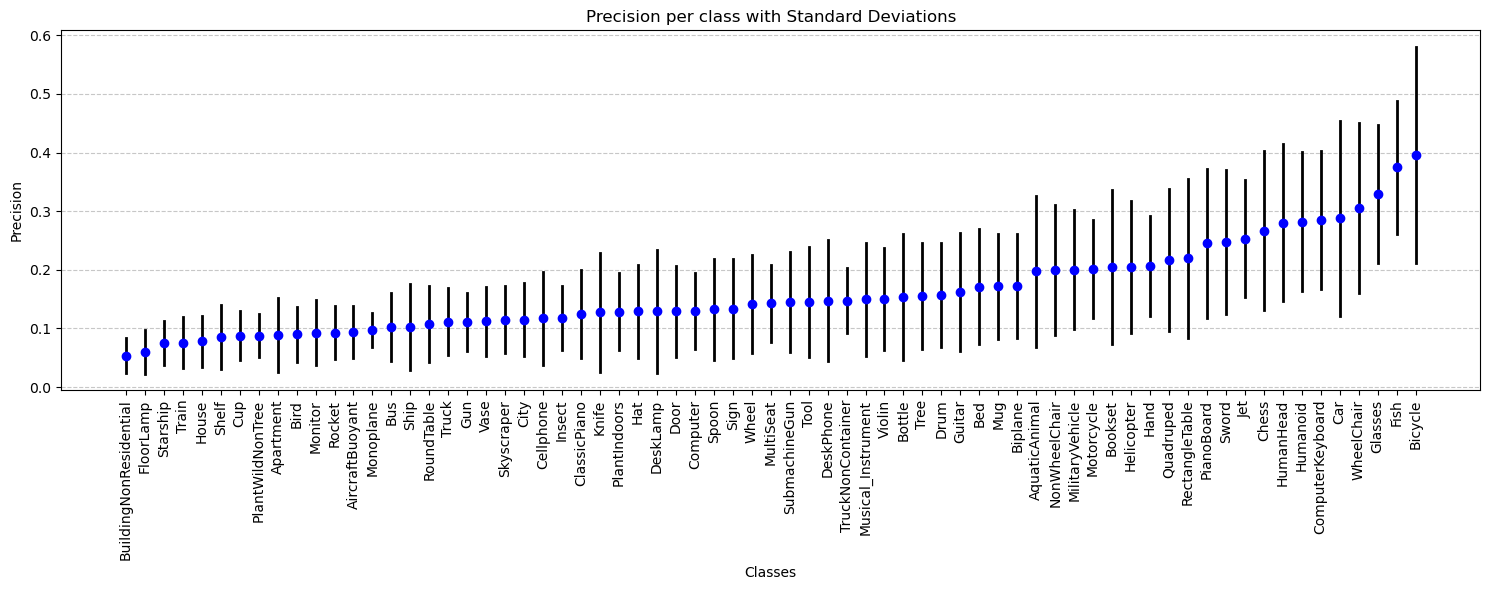

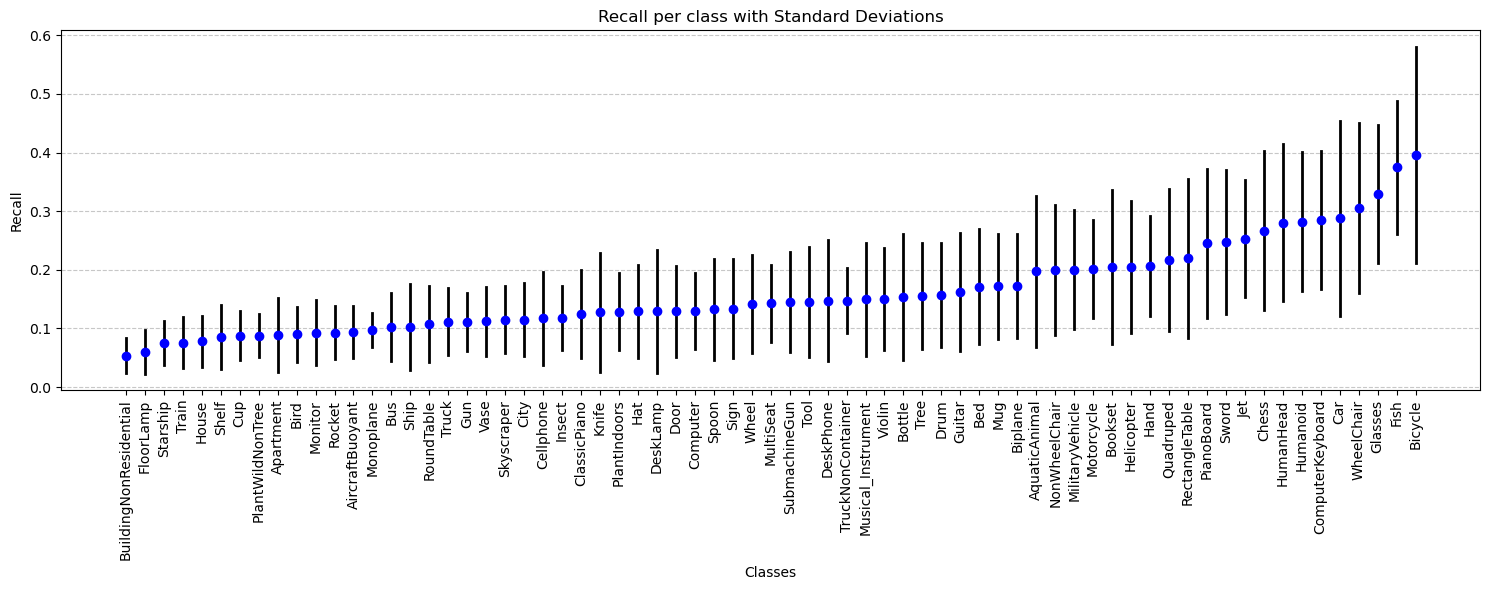

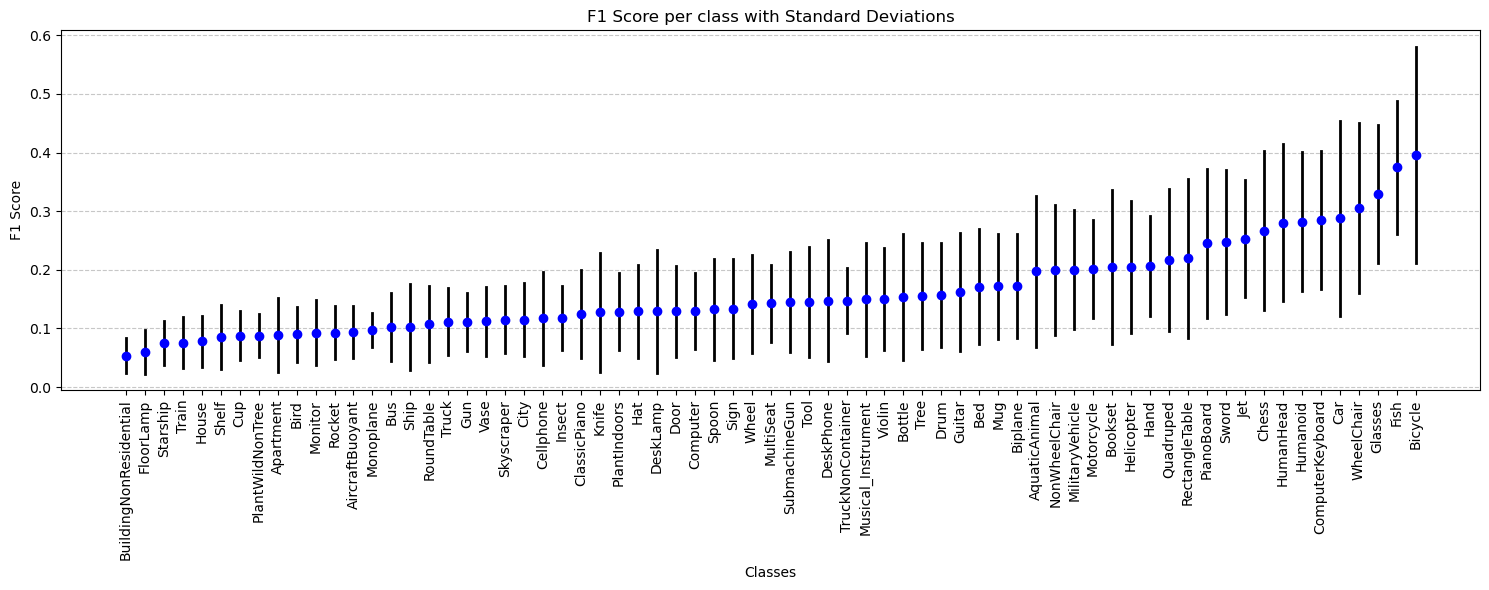

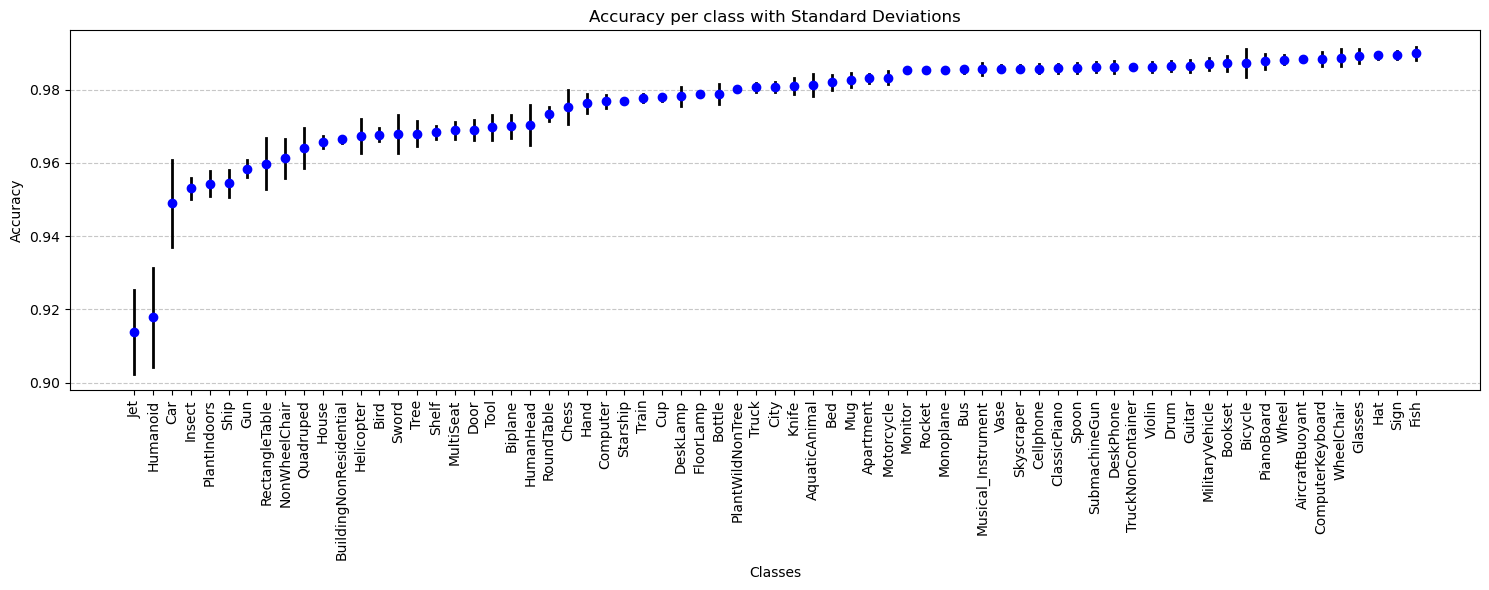

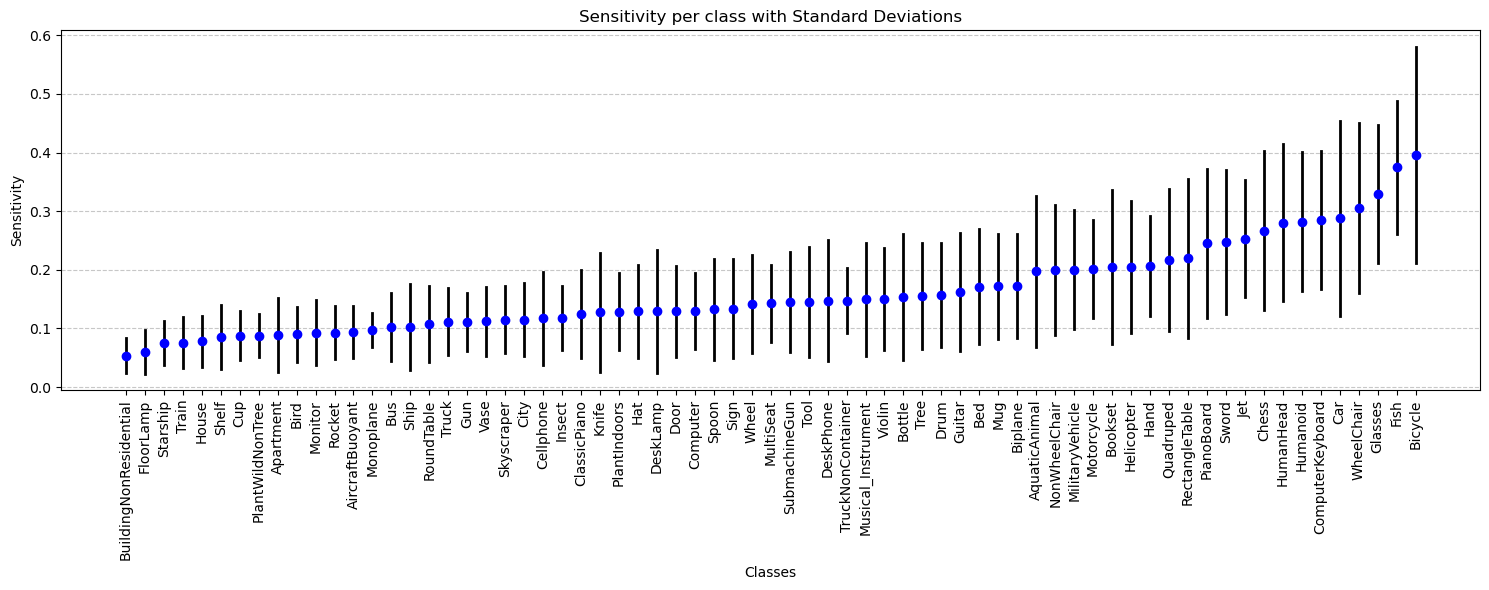

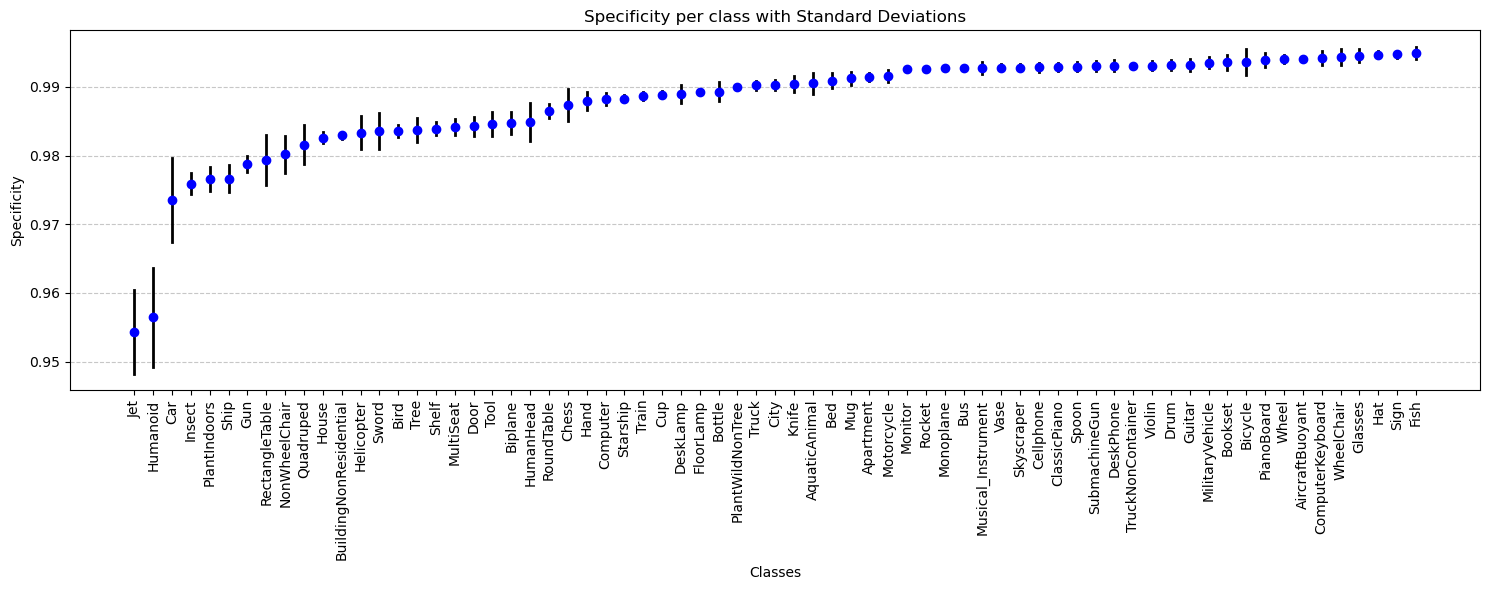

DataFrame Dataset From part 5


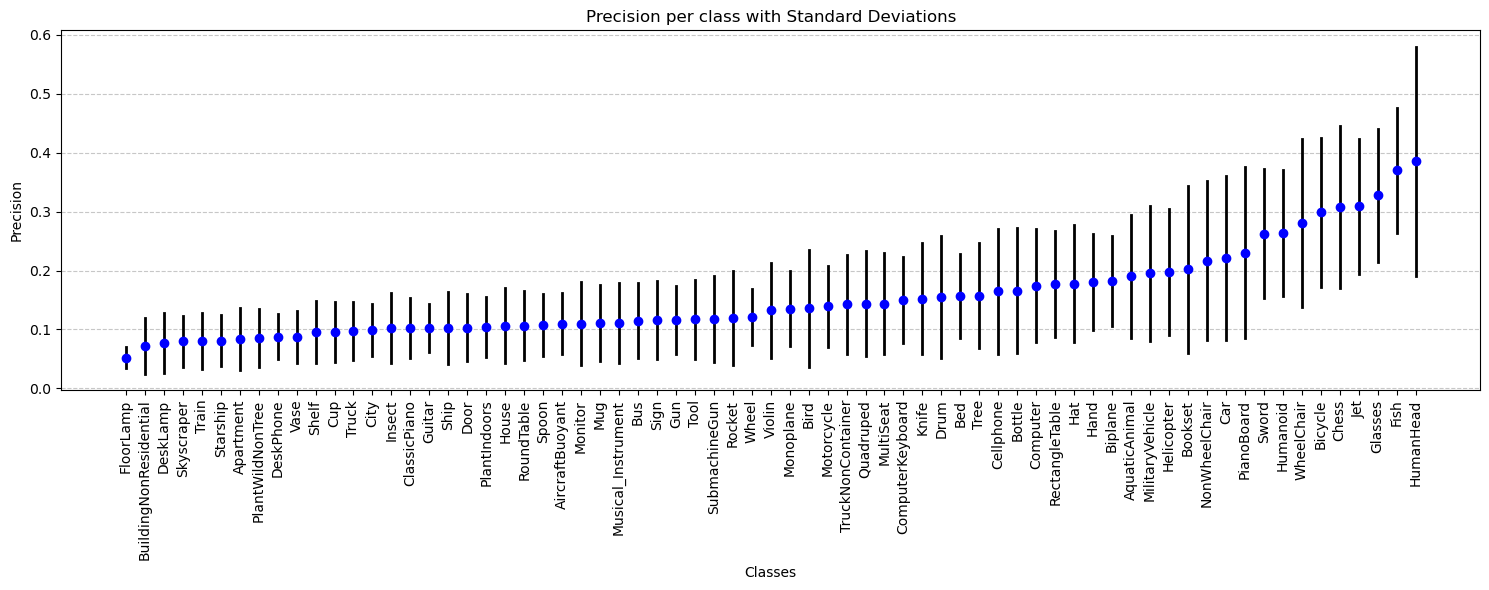

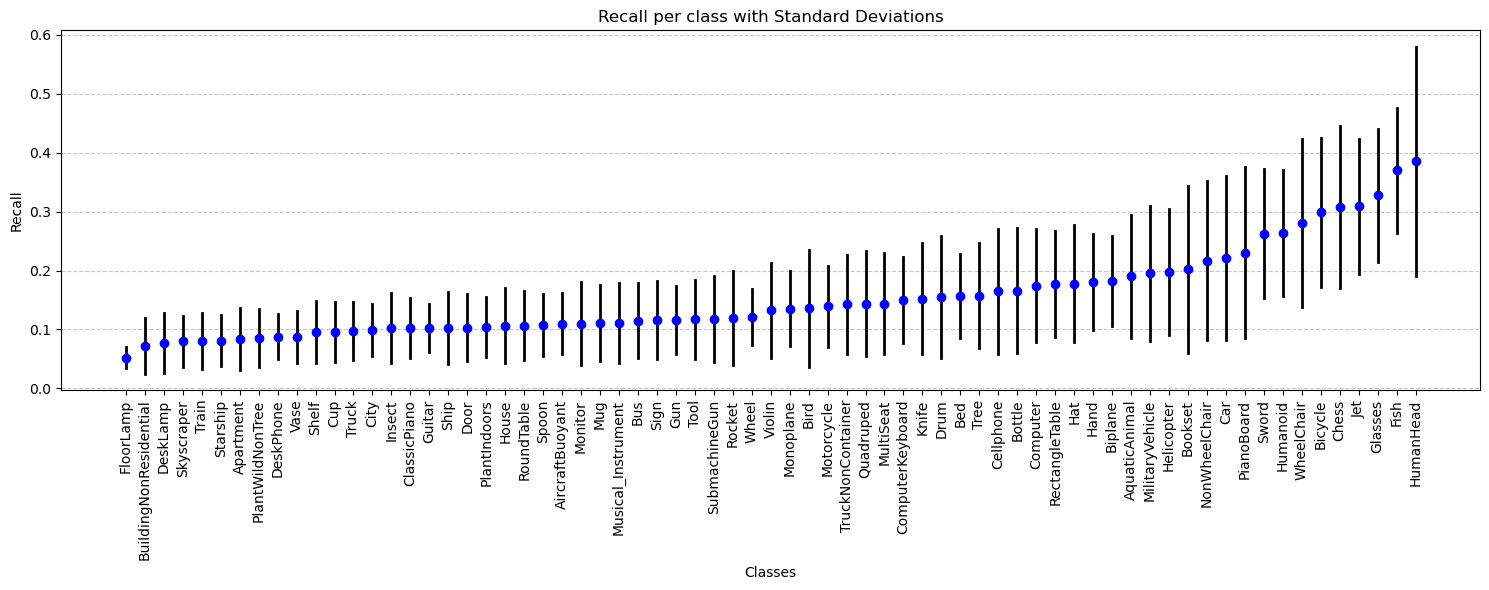

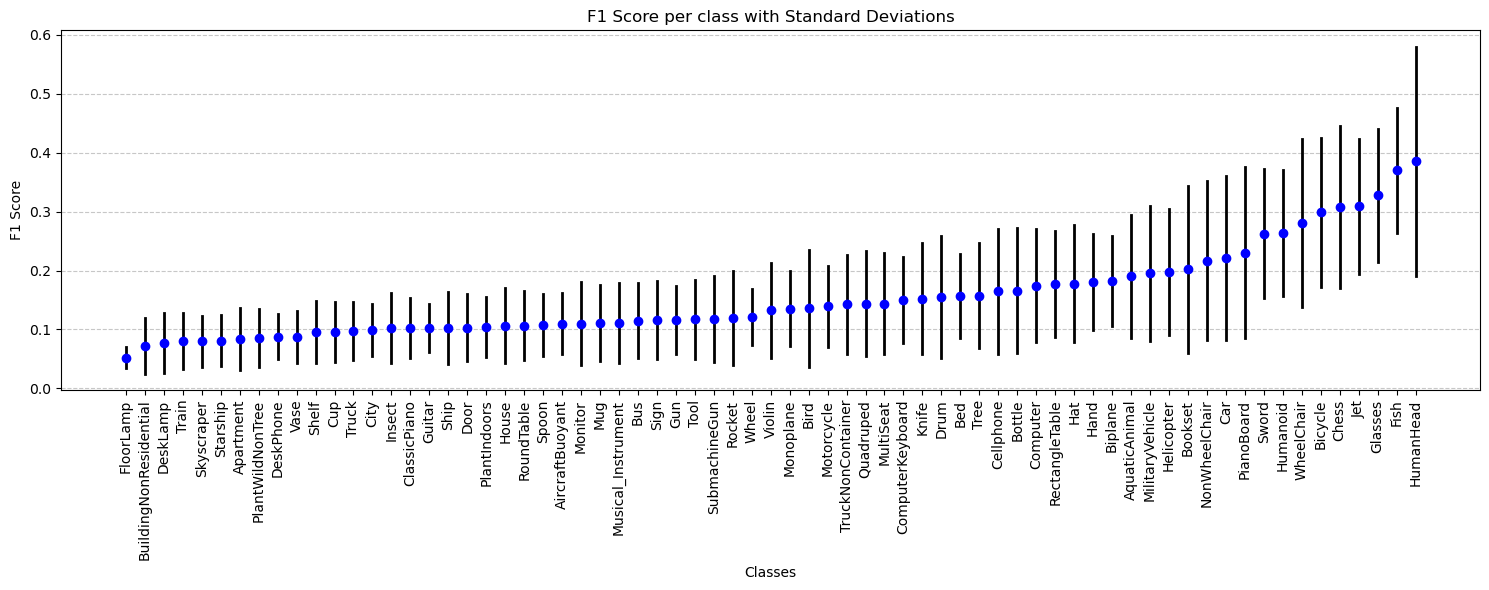

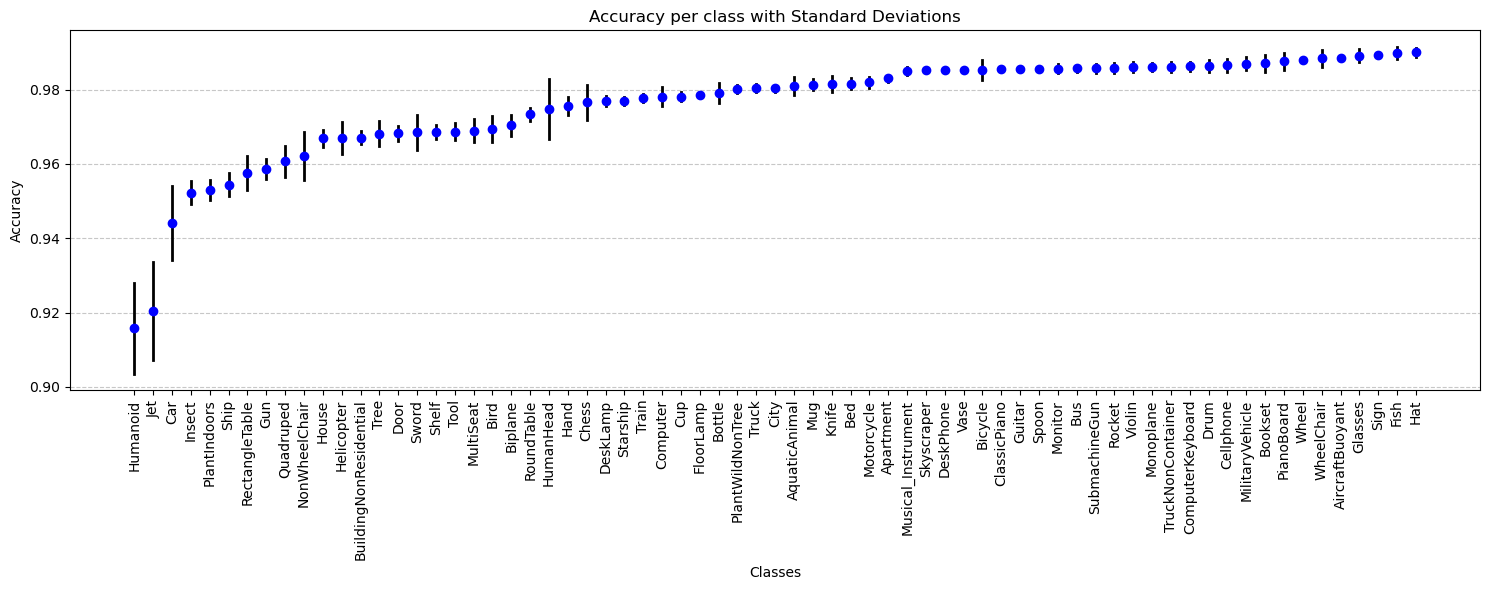

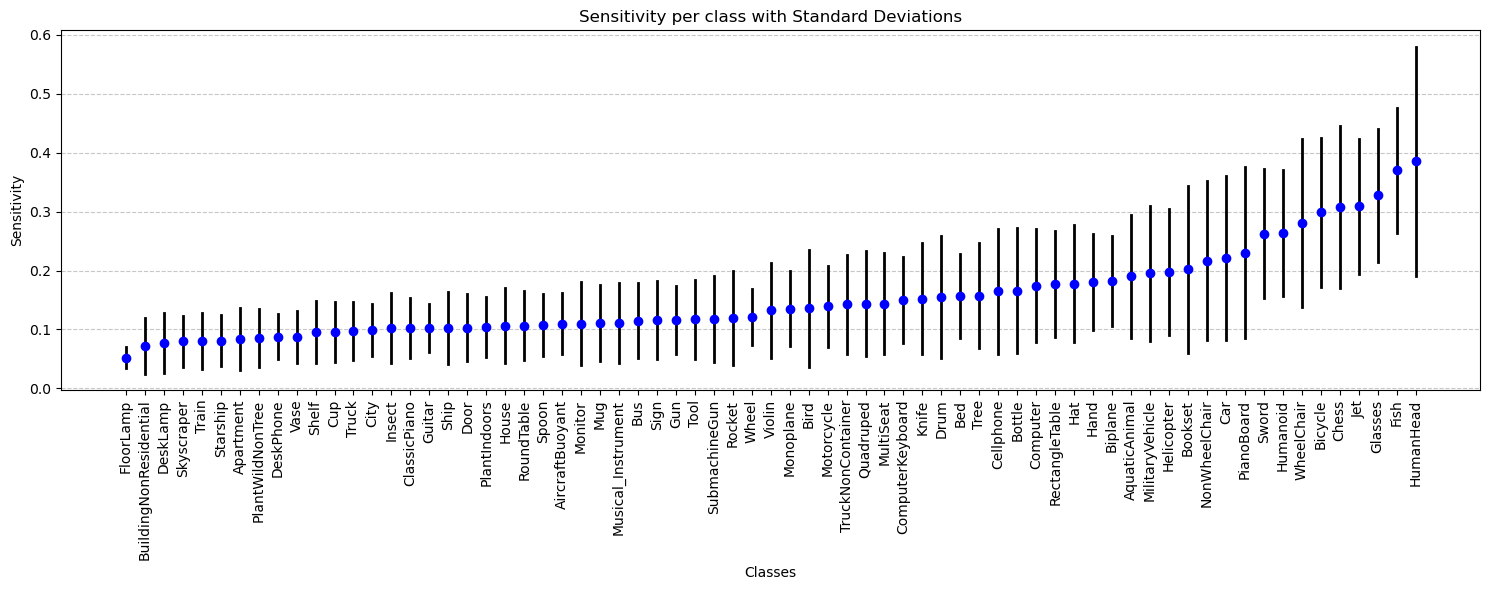

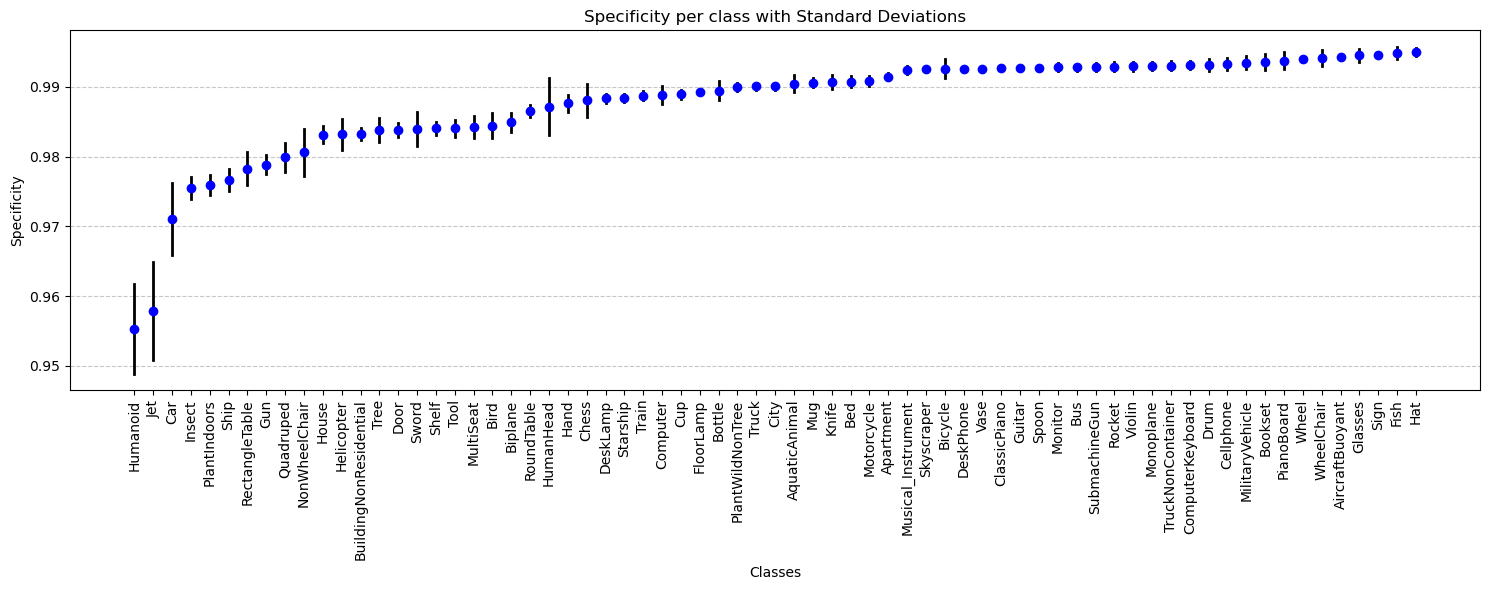

DataFrame Dataset From bonus part 4


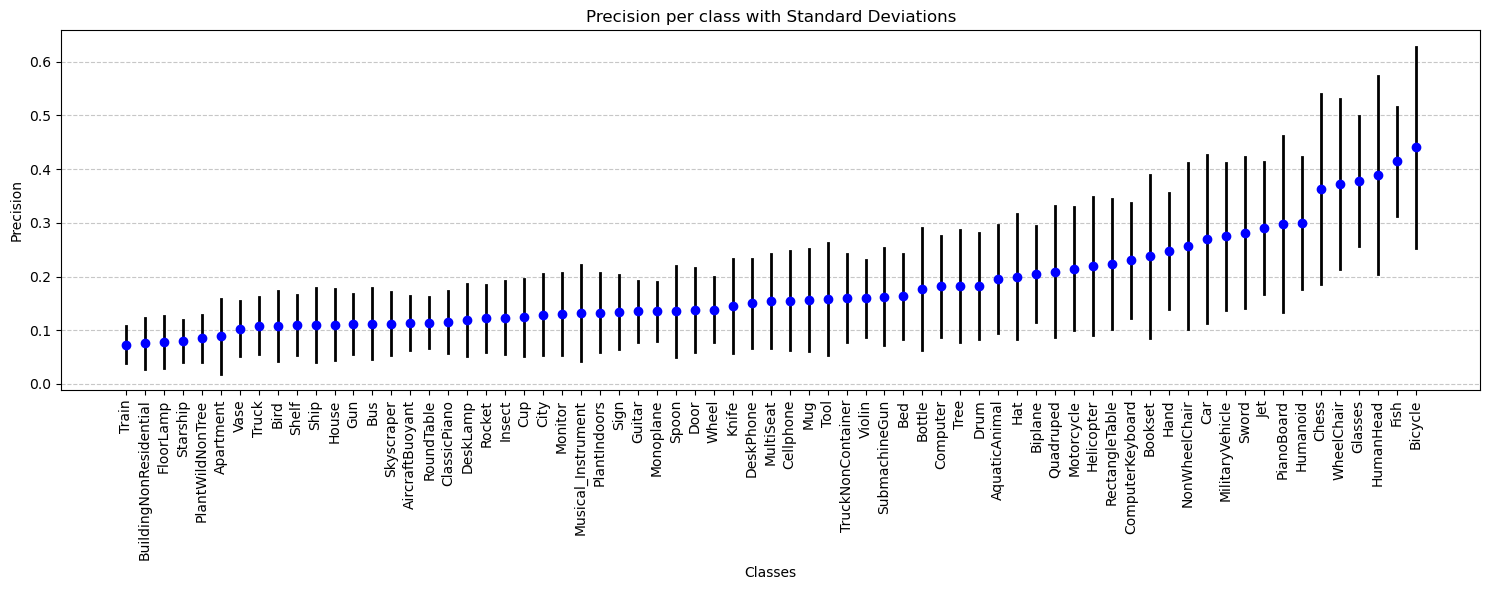

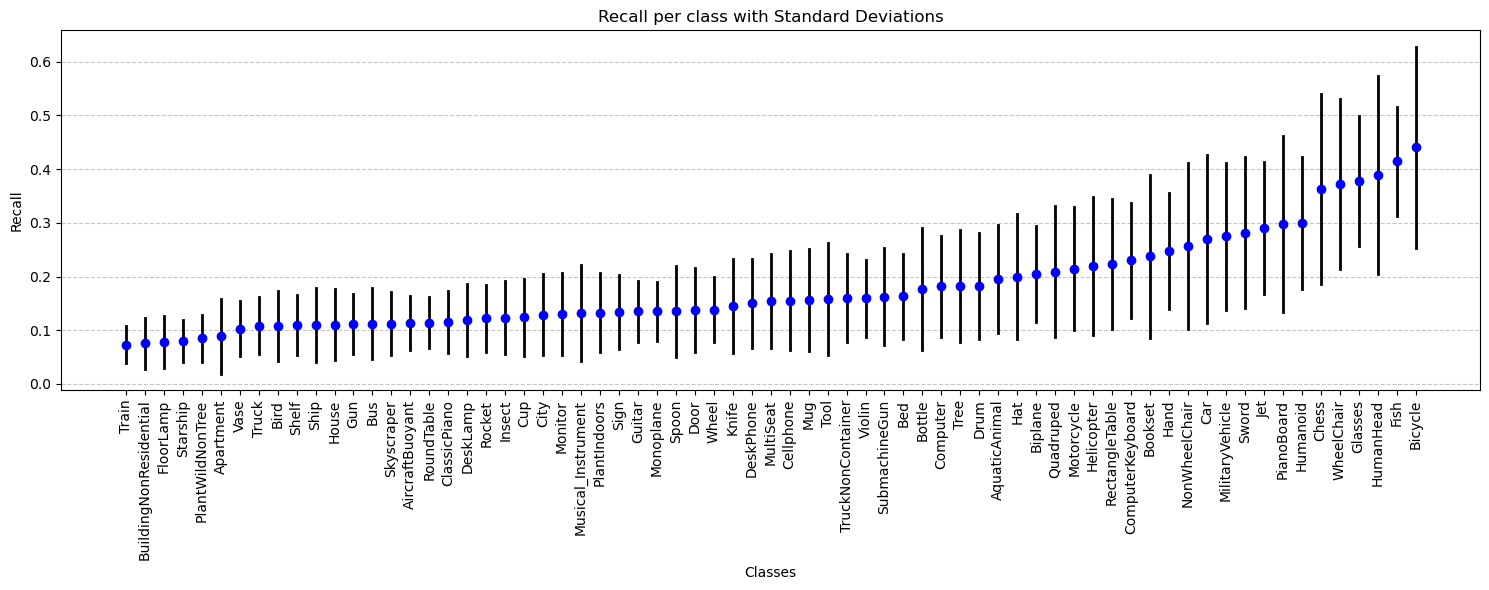

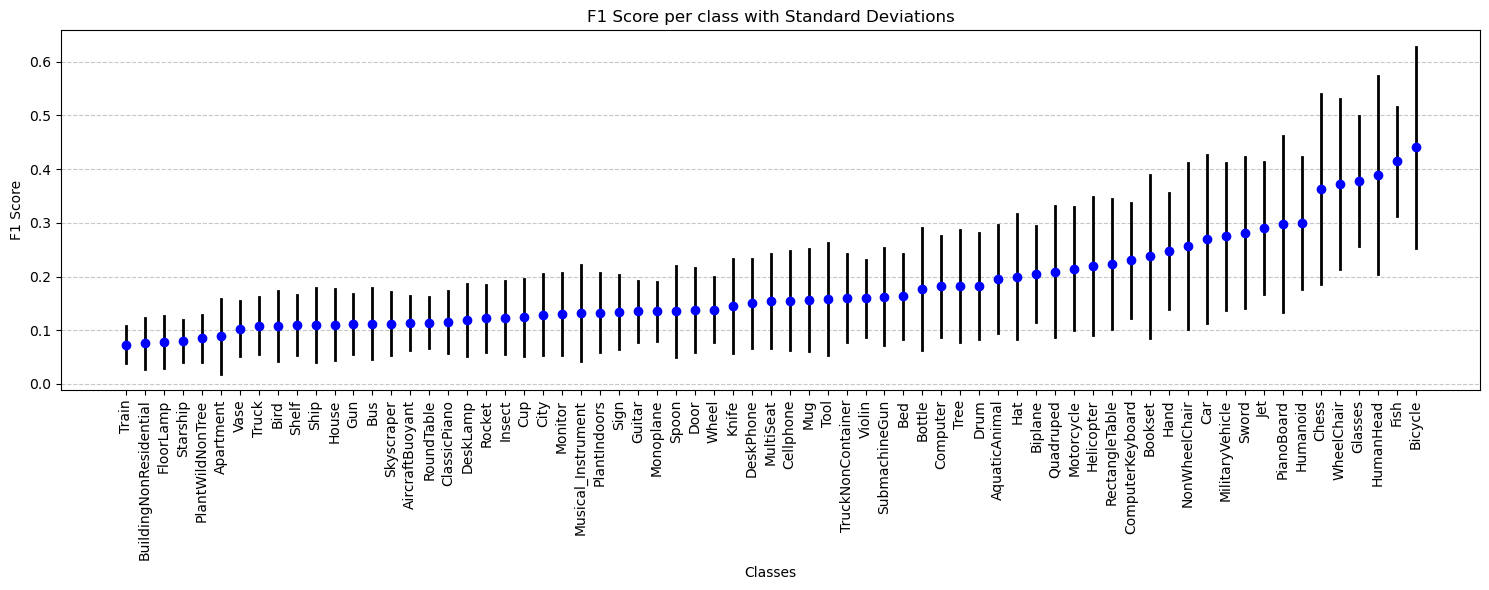

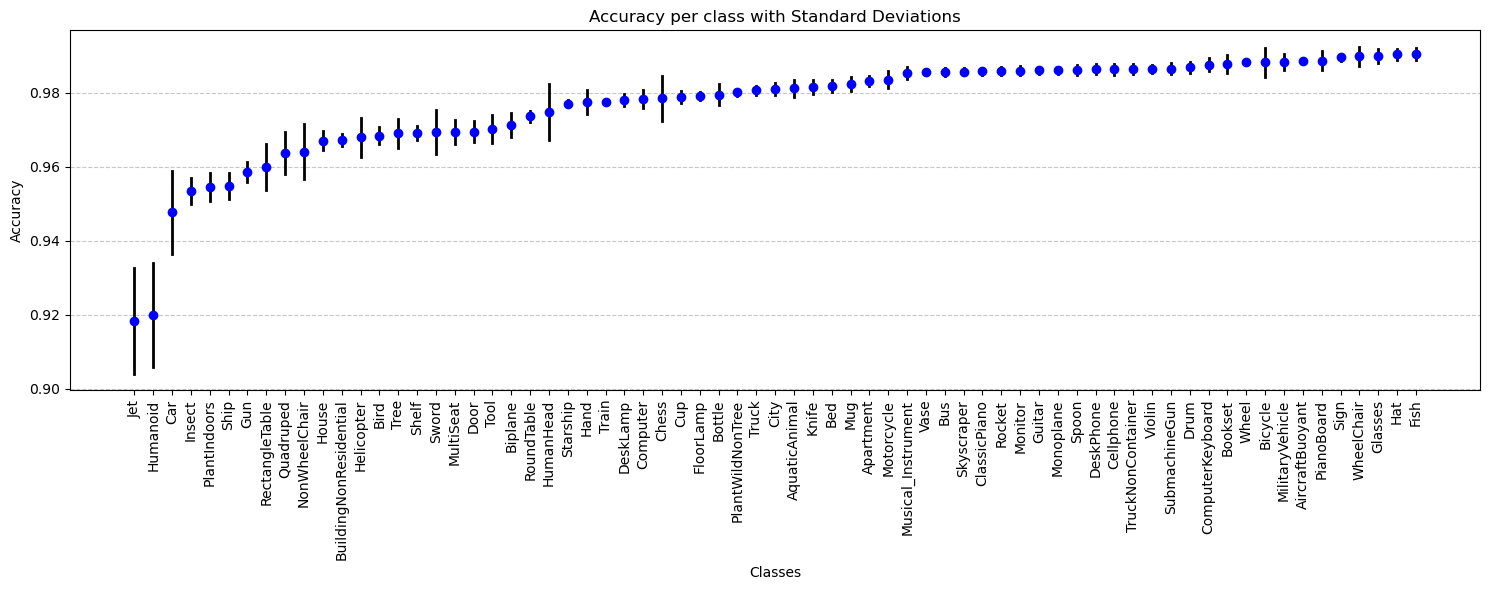

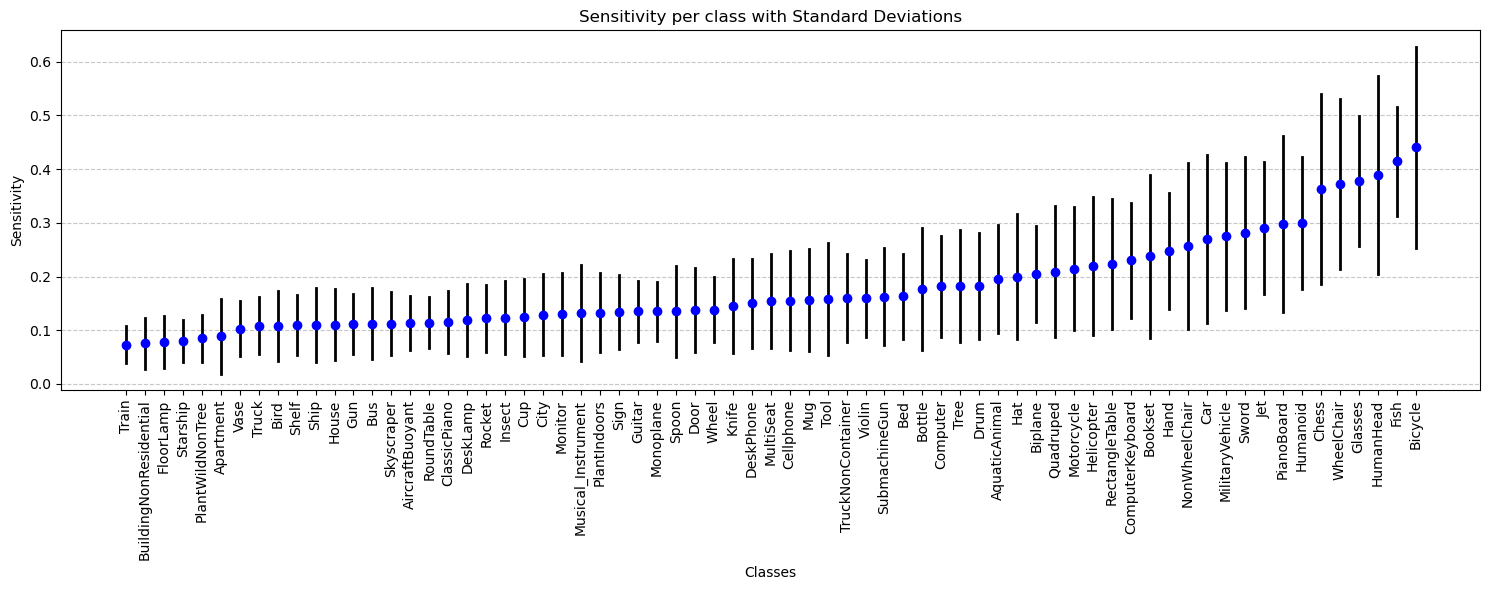

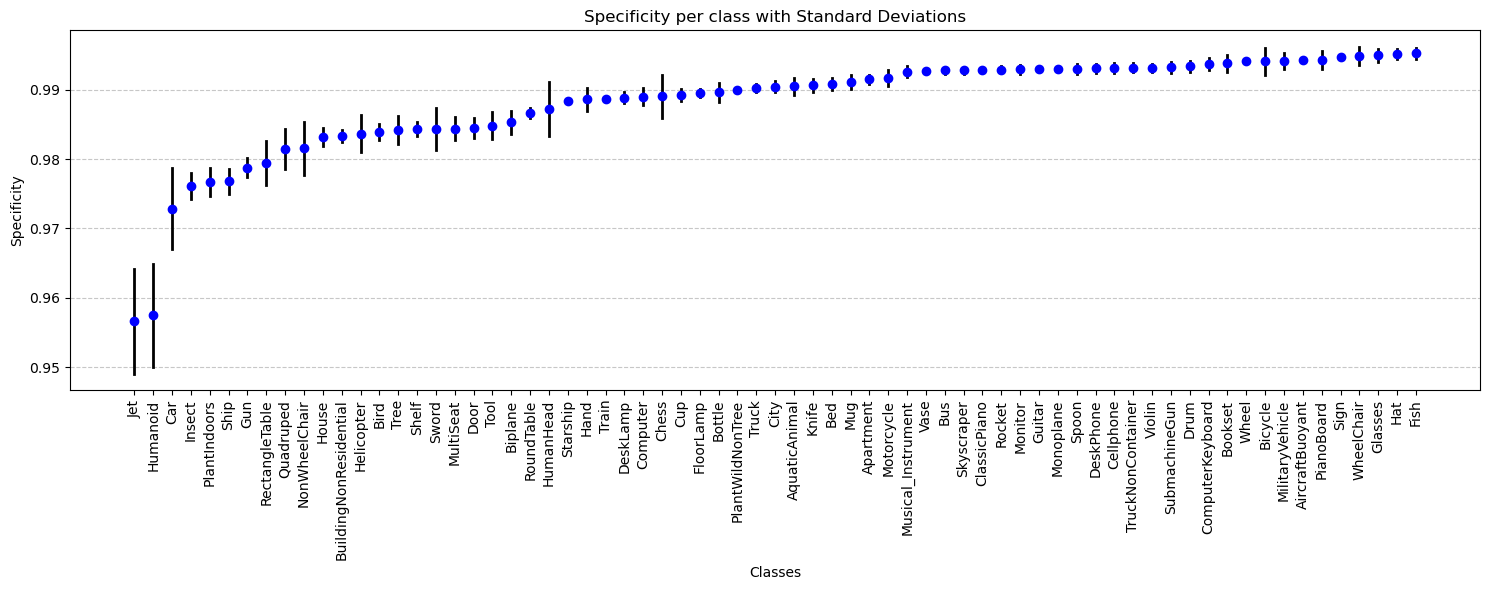

In [409]:
# Function to plot metrics as dots with vertical lines for std
def plot_perclass_metrics_with_std(data_dict, std_dict, title):
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    std_values = [std_dict[label] for label in labels]

    # Sort by values
    items = sorted(zip(labels, values, std_values), key=lambda x: x[1])
    labels, values, std_values = zip(*items)
    
    plt.figure(figsize=(15, 6))
    
    plt.scatter(labels, values, color='blue', zorder=5)
    
    # Plot vertical lines for standard deviations
    for i, (label, value, std_value) in enumerate(zip(labels, values, std_values)):
        plt.plot([label, label], [value - std_value, value + std_value], color='black', lw=2)
    
    plt.xlabel("Classes")
    plt.xticks(rotation=90)
    plt.ylabel(title)
    plt.title(f"{title} per class with Standard Deviations")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def calculate_metrics(df):
    precisions, recalls, f1_scores, accuracies, sensitivities, specificities = {}, {}, {}, {}, {}, {}
    database_size = len(df)
    
    for _, row in df.iterrows():
        query_class = row['Shape Class']
        y_pred = list(map(int, row['evaluated']))  # Convert the string list to an actual list of integers
        query_size = len(y_pred)
        
        # Calculate TP, FP, TN, and FN
        TP = sum(y_pred)                        # Correctly identified as the query class
        FP = query_size - TP                    # Incorrectly identified as the query class
        FN = query_size - TP                    # Belong to the query class but not returned
        TN = database_size - query_size - FP    # Correctly identified as not the query class

        # Compute performance metrics
        precision = TP / query_size if query_size > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        accuracy = (TP + TN) / database_size
        sensitivity = recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

        # Store the results in dictionaries
        append_to_dict(precisions, query_class, precision)
        append_to_dict(recalls, query_class, recall)
        append_to_dict(f1_scores, query_class, f1_score)
        append_to_dict(accuracies, query_class, accuracy)
        append_to_dict(sensitivities, query_class, sensitivity)
        append_to_dict(specificities, query_class, specificity)

    # Calculate per-class averages for each metric
    perclass_metrics = {
        'Precision': {label: stats.mean(values) for label, values in precisions.items()},
        'Recall': {label: stats.mean(values) for label, values in recalls.items()},
        'F1 Score': {label: stats.mean(values) for label, values in f1_scores.items()},
        'Accuracy': {label: stats.mean(values) for label, values in accuracies.items()},
        'Sensitivity': {label: stats.mean(values) for label, values in sensitivities.items()},
        'Specificity': {label: stats.mean(values) for label, values in specificities.items()},
    }
    
    # Calculate standard deviation per class
    std_dev_metrics = {
        'Precision': {label: np.std(values) for label, values in precisions.items()},
        'Recall': {label: np.std(values) for label, values in recalls.items()},
        'F1 Score': {label: np.std(values) for label, values in f1_scores.items()},
        'Accuracy': {label: np.std(values) for label, values in accuracies.items()},
        'Sensitivity': {label: np.std(values) for label, values in sensitivities.items()},
        'Specificity': {label: np.std(values) for label, values in specificities.items()},
    }

    # Plot per-class metrics with std
    for plot_type in perclass_metrics:
        plot_perclass_metrics_with_std(perclass_metrics[plot_type], std_dev_metrics[plot_type], plot_type)
    # Calculate overall averages for all classes
    overall_metrics = {metric: stats.mean(list(values.values())) for metric, values in perclass_metrics.items()}
    return overall_metrics

results = []
for d, d_name in [
    (merged_df_part_4, "Dataset From part 4"),
    (merged_df_part_5, "Dataset From part 5"),
    (merged_df_part_4_bonus, "Dataset From bonus part 4")
]:
    print('DataFrame', d_name)
    calculate_metrics(d)


In [417]:

def append_to_dict(_dict, label, value):
    if label not in _dict:
        _dict[label] = [value]
    else:
        _dict[label].append(value)

def plot_perclass_metrics_with_std(data_dict, std_dict, title):
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    std_values = [std_dict[label] for label in labels]

    items = sorted(zip(labels, values, std_values), key=lambda x: x[1])
    labels, values, std_values = zip(*items)
    
    plt.figure(figsize=(20, 6))
    plt.scatter(labels, values, color='blue', zorder=5)
    
    # Plot vertical lines for standard deviations
    for i, (label, value, std_value) in enumerate(zip(labels, values, std_values)):
        plt.plot([label, label], [value - std_value, value + std_value], color='black', lw=2)
    
    plt.xlabel("Classes")
    plt.xticks(rotation=90)
    plt.ylabel(title)
    plt.title(f"{title} per class with Standard Deviations")
    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.show()

# Modify the section where you calculate and plot the metrics
def calculate_metrics(df):
    # Initialize dictionaries to store metrics for each class
    precisions, recalls, f1_scores, accuracies, sensitivities, specificities = {}, {}, {}, {}, {}, {}
    database_size = len(df)
    
    for _, row in df.iterrows():
        query_class = row['Shape Class']
        y_pred = list(map(int, row['evaluated']))  # Convert the string list to an actual list of integers
        query_size = len(y_pred)
        
        # Calculate TP, FP, TN, and FN
        TP = sum(y_pred)                        # Correctly identified as the query class
        FP = query_size - TP                    # Incorrectly identified as the query class
        FN = query_size - TP                    # Belong to the query class but not returned
        TN = database_size - query_size - FP    # Correctly identified as not the query class

        # Compute performance metrics
        precision = TP / query_size if query_size > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        accuracy = (TP + TN) / database_size
        sensitivity = recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

        # Store the results in dictionaries
        append_to_dict(precisions, query_class, precision)
        append_to_dict(recalls, query_class, recall)
        append_to_dict(f1_scores, query_class, f1_score)
        append_to_dict(accuracies, query_class, accuracy)
        append_to_dict(sensitivities, query_class, sensitivity)
        append_to_dict(specificities, query_class, specificity)

    # Calculate per-class averages for each metric
    perclass_metrics = {
        'Precision': {label: stats.mean(values) for label, values in precisions.items()},
        'Recall': {label: stats.mean(values) for label, values in recalls.items()},
        'F1 Score': {label: stats.mean(values) for label, values in f1_scores.items()},
        'Accuracy': {label: stats.mean(values) for label, values in accuracies.items()},
        'Sensitivity': {label: stats.mean(values) for label, values in sensitivities.items()},
        'Specificity': {label: stats.mean(values) for label, values in specificities.items()},
    }
    
    # Calculate standard deviation per class
    std_dev_metrics = {
        'Precision': {label: np.std(values) for label, values in precisions.items()},
        'Recall': {label: np.std(values) for label, values in recalls.items()},
        'F1 Score': {label: np.std(values) for label, values in f1_scores.items()},
        'Accuracy': {label: np.std(values) for label, values in accuracies.items()},
        'Sensitivity': {label: np.std(values) for label, values in sensitivities.items()},
        'Specificity': {label: np.std(values) for label, values in specificities.items()},
    }
    
    return perclass_metrics, std_dev_metrics

def compare_overall_metrics(results_dicts):
    # Create a list to hold all the overall metrics
    all_overall_metrics = []
    
    # Iterate over each model and calculate the overall metrics
    for model_name, (perclass_metrics, _) in results_dicts.items():
        # Calculate the overall metrics by averaging per-class metrics
        overall_metrics = {metric: stats.mean(list(values.values())) for metric, values in perclass_metrics.items()}
        all_overall_metrics.append({model_name: overall_metrics})
    
    # Convert to DataFrame
    comparison_df = pd.DataFrame()
    
    # Add overall metrics for each model as a row in the DataFrame
    for result in all_overall_metrics:
        for model_name, metrics in result.items():
            for metric, value in metrics.items():
                comparison_df.loc[model_name, metric] = value

    return comparison_df

# Example usage
results_dicts = {}

for d, d_name in [
    (merged_df_part_4, "Model 1"),
    (merged_df_part_5, "Model 2"),
    (merged_df_part_4_bonus, "Model 3")
]:
    print('Processing', d_name)
    perclass_metrics, std_dev_metrics = calculate_metrics(d)
    results_dicts[d_name] = (perclass_metrics, std_dev_metrics)

# Compare the models and create a table with overall metrics
overall_comparison_table = compare_overall_metrics(results_dicts)
overall_comparison_table = pd.DataFrame(overall_comparison_table)
overall_comparison_table

Processing Model 1
Processing Model 2
Processing Model 3


Precision    Recall  F1 Score  Accuracy  Sensitivity  Specificity
Model 1   0.161663  0.161663  0.161663  0.976049     0.161663     0.987773
Model 2   0.153608  0.153608  0.153608  0.975902     0.153608     0.987699
Model 3   0.180180  0.180180  0.180180  0.976606     0.180180     0.988057

Model 1   Precision
 best  Bicycle with  0.39644970414201186
 worst  BuildingNonResidential with  0.05371900826446281
Model 2   Precision
 best  HumanHead with  0.38523644752018454
 worst  FloorLamp with  0.052295918367346934
Model 3   Precision
 best  Bicycle with  0.4408284023668639
 worst  Train with  0.07333333333333333


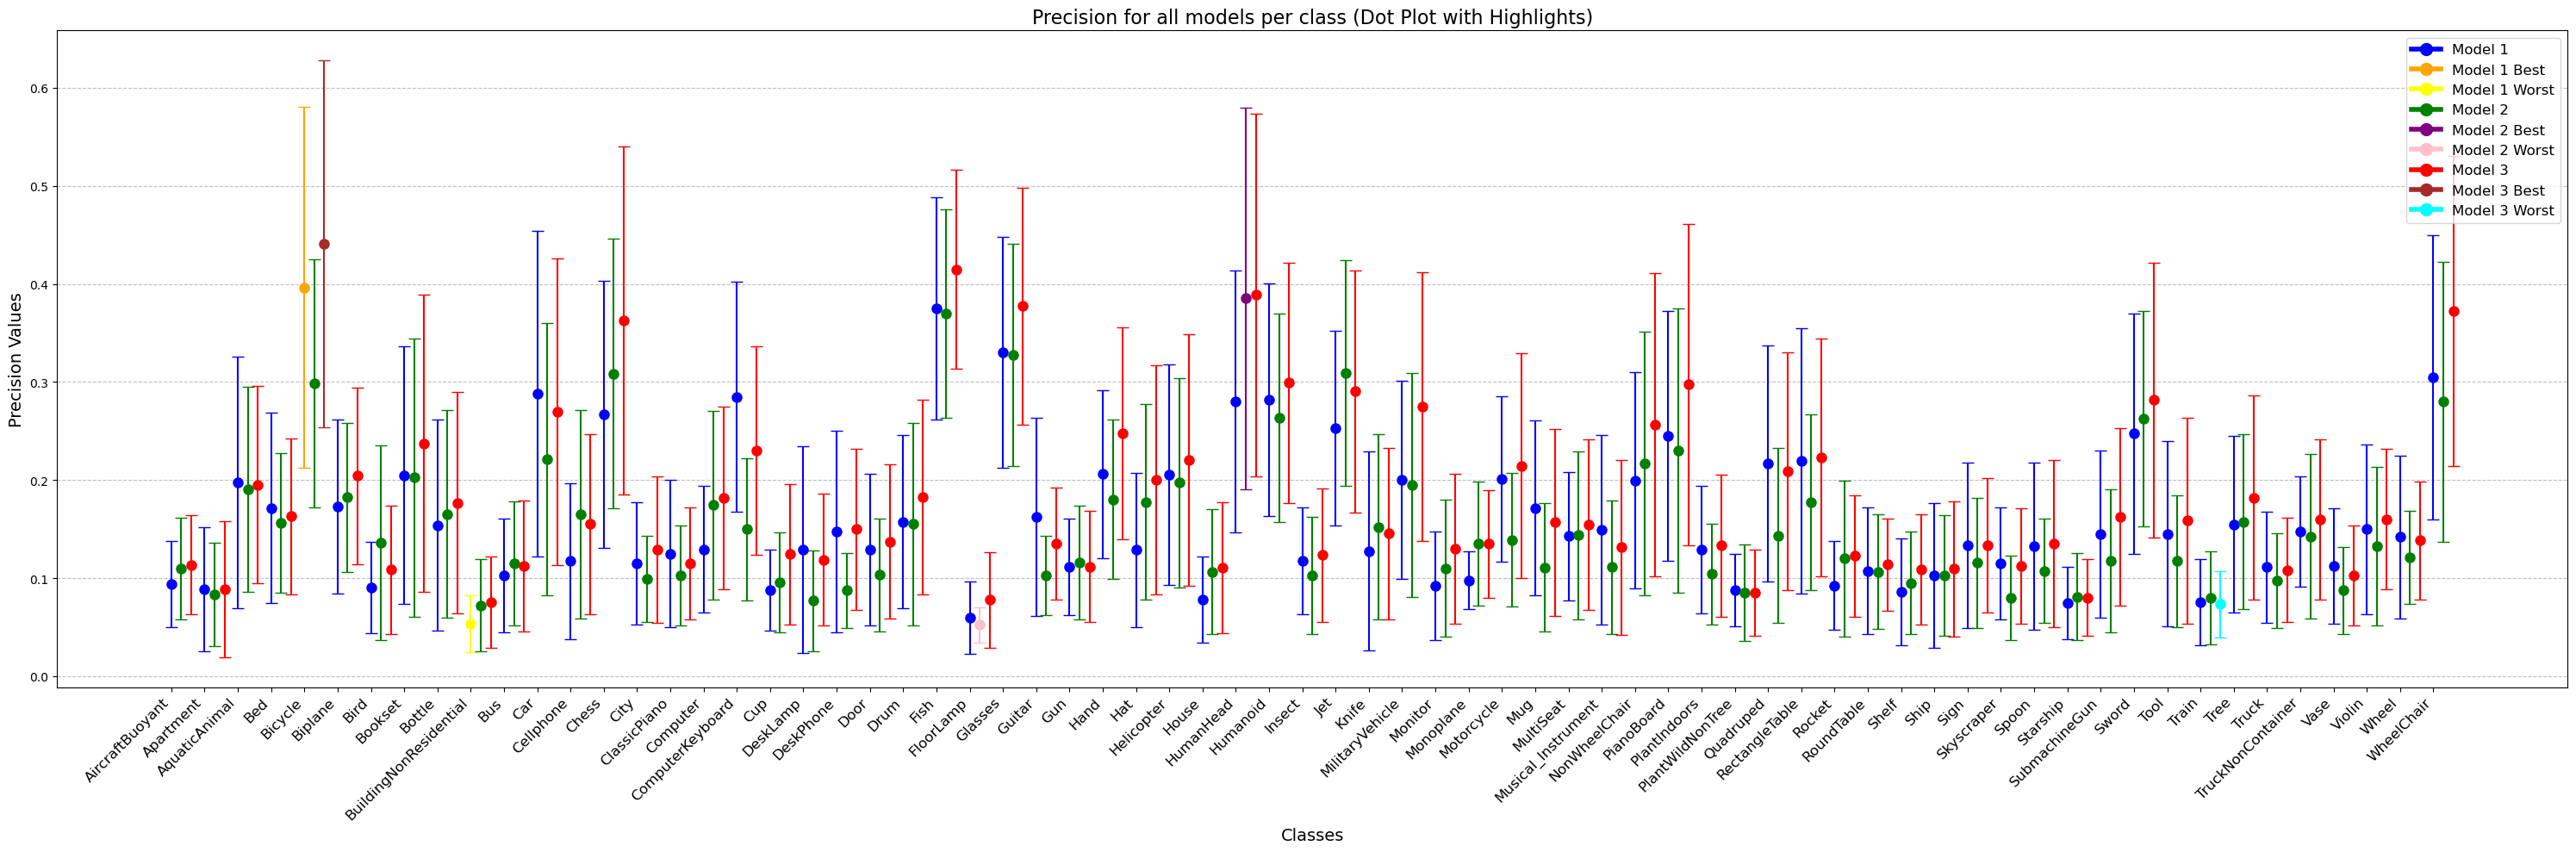

Model 1   Recall
 best  Bicycle with  0.39644970414201186
 worst  BuildingNonResidential with  0.05371900826446281
Model 2   Recall
 best  HumanHead with  0.38523644752018454
 worst  FloorLamp with  0.052295918367346934
Model 3   Recall
 best  Bicycle with  0.4408284023668639
 worst  Train with  0.07333333333333333


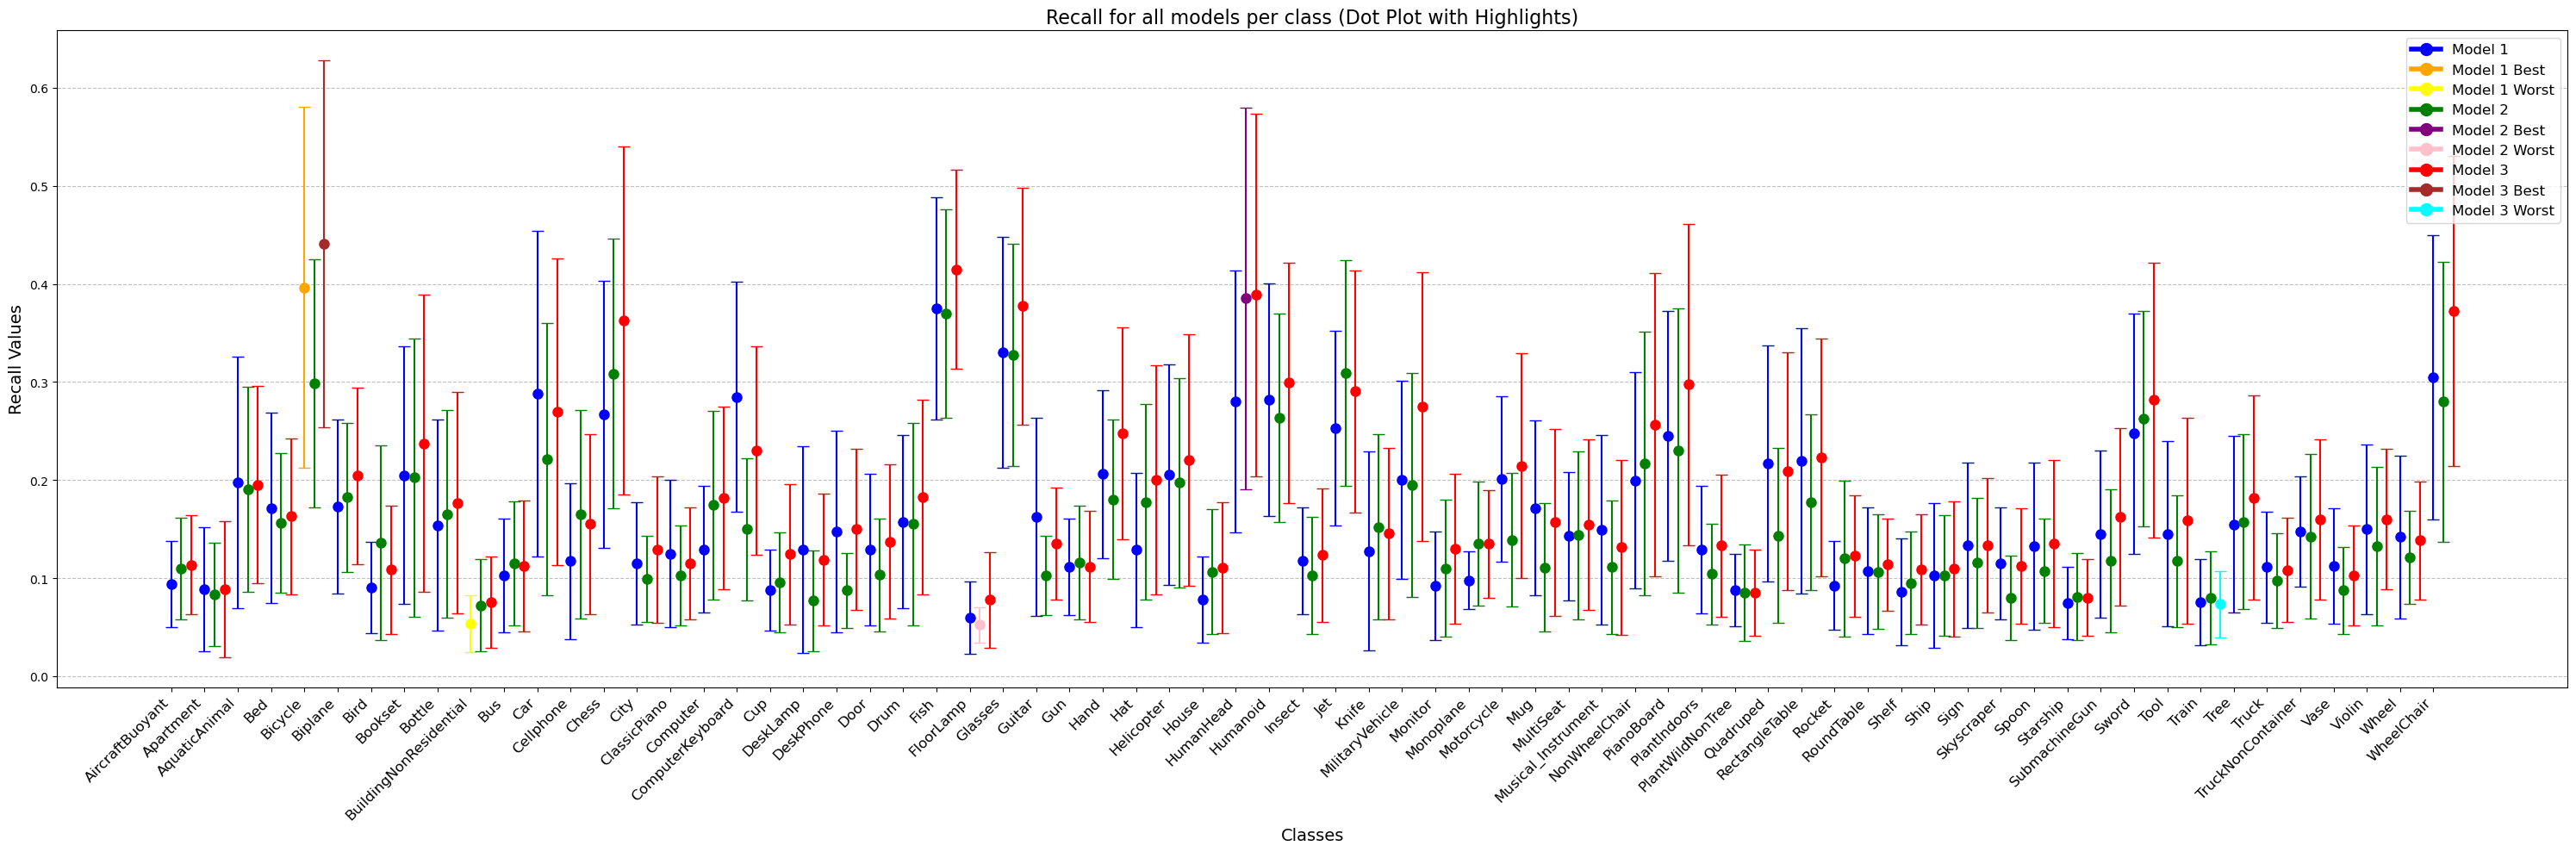

Model 1   F1 Score
 best  Bicycle with  0.39644970414201186
 worst  BuildingNonResidential with  0.05371900826446281
Model 2   F1 Score
 best  HumanHead with  0.38523644752018454
 worst  FloorLamp with  0.052295918367346934
Model 3   F1 Score
 best  Bicycle with  0.4408284023668639
 worst  Train with  0.07333333333333333


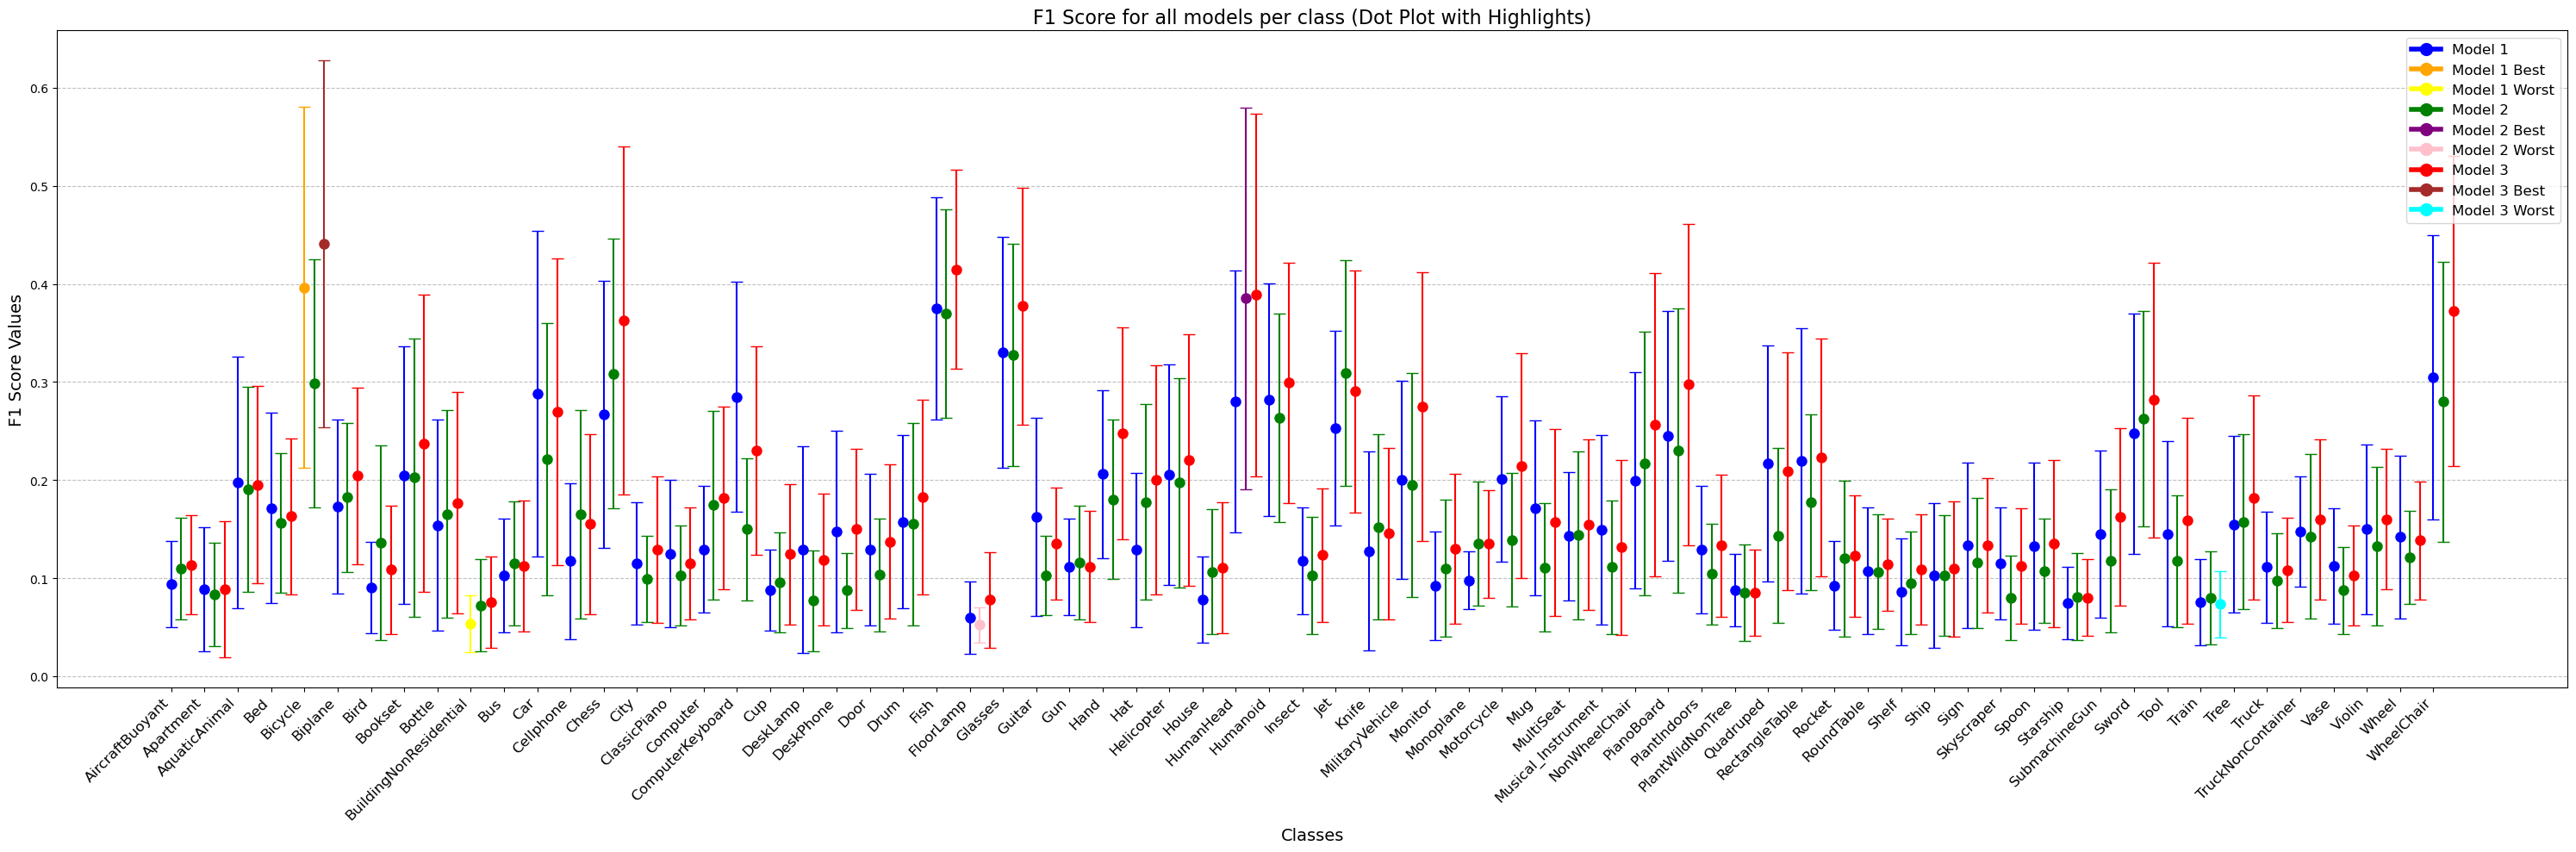

Model 1   Accuracy
 best  Fish with  0.9899315344341523
 worst  Jet with  0.913949119748556
Model 2   Accuracy
 best  Hat with  0.9900657806416969
 worst  Humanoid with  0.9157652317448792
Model 3   Accuracy
 best  Fish with  0.9905759162303664
 worst  Jet with  0.9182637740833471


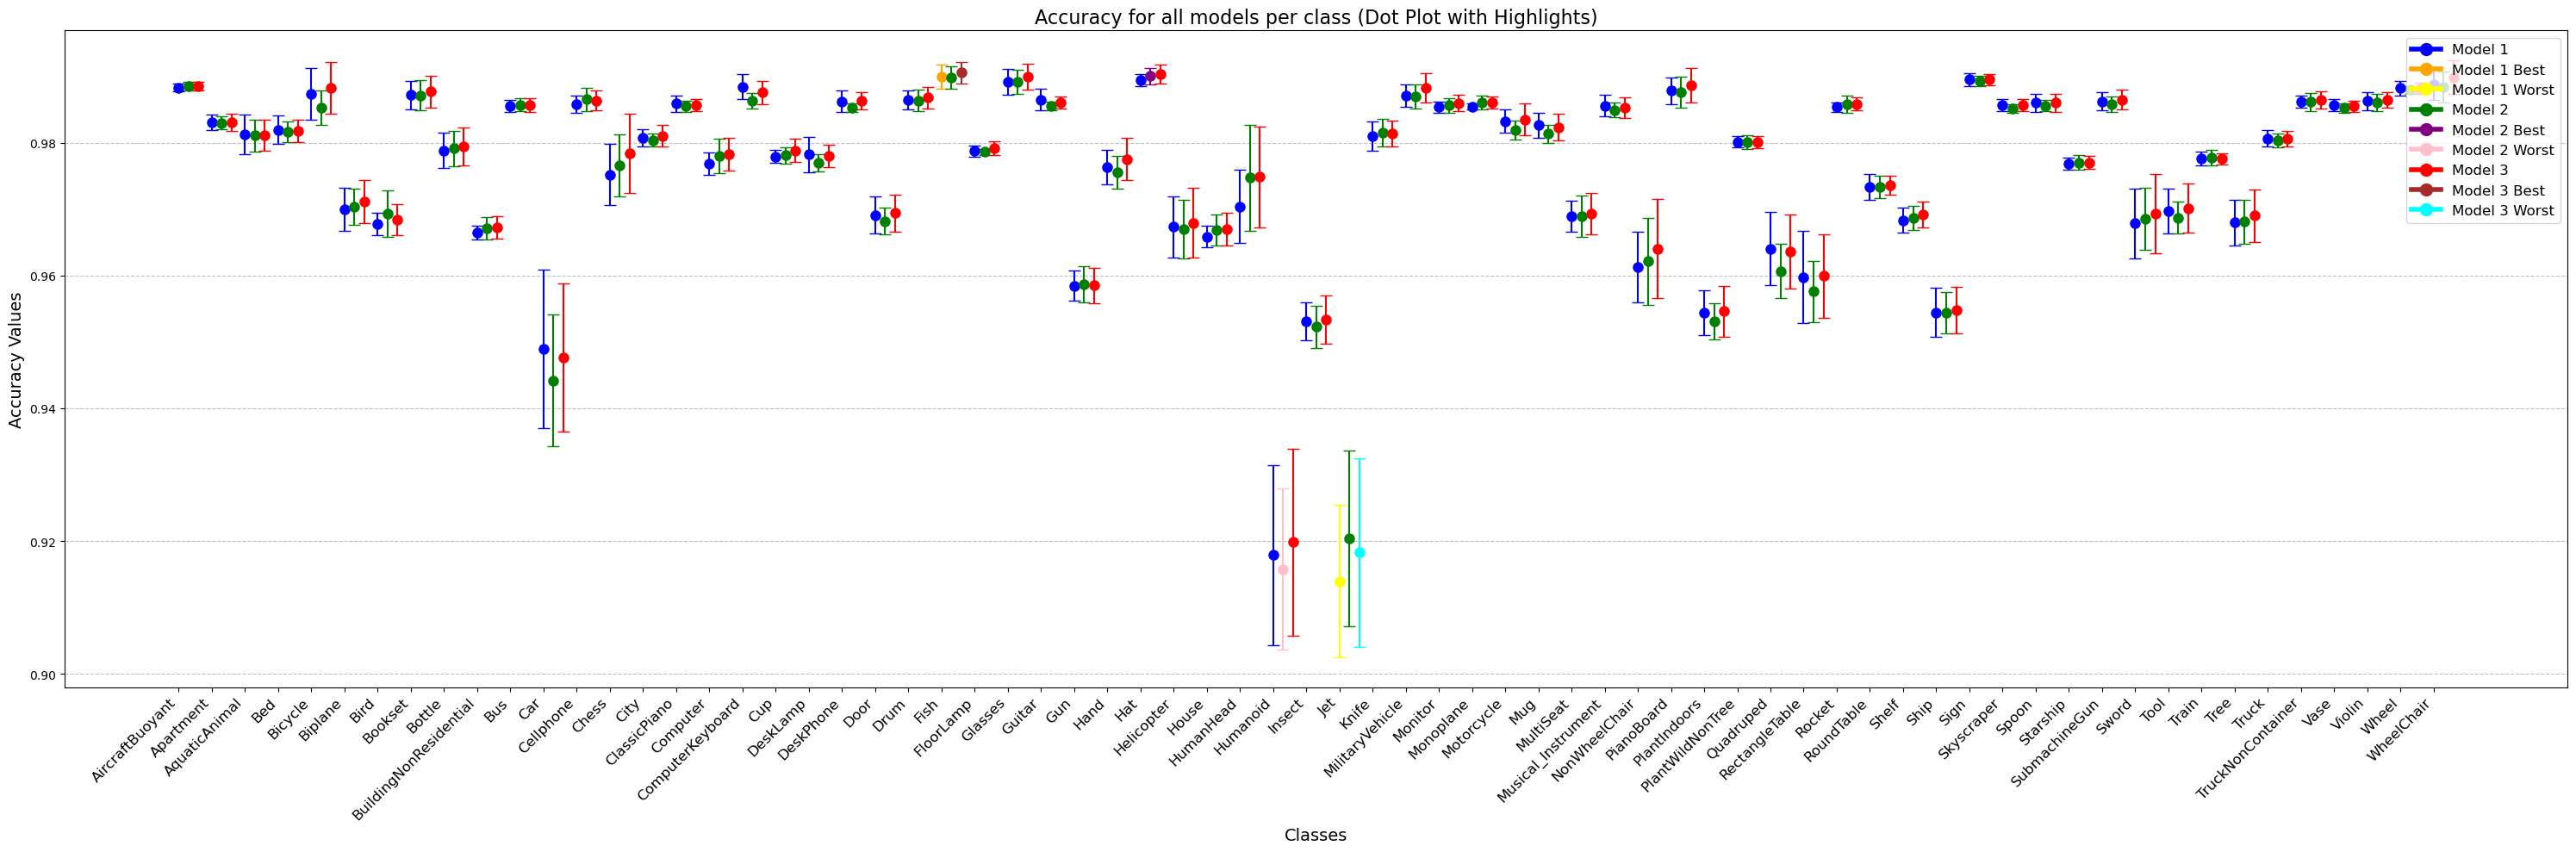

Model 1   Sensitivity
 best  Bicycle with  0.39644970414201186
 worst  BuildingNonResidential with  0.05371900826446281
Model 2   Sensitivity
 best  HumanHead with  0.38523644752018454
 worst  FloorLamp with  0.052295918367346934
Model 3   Sensitivity
 best  Bicycle with  0.4408284023668639
 worst  Train with  0.07333333333333333


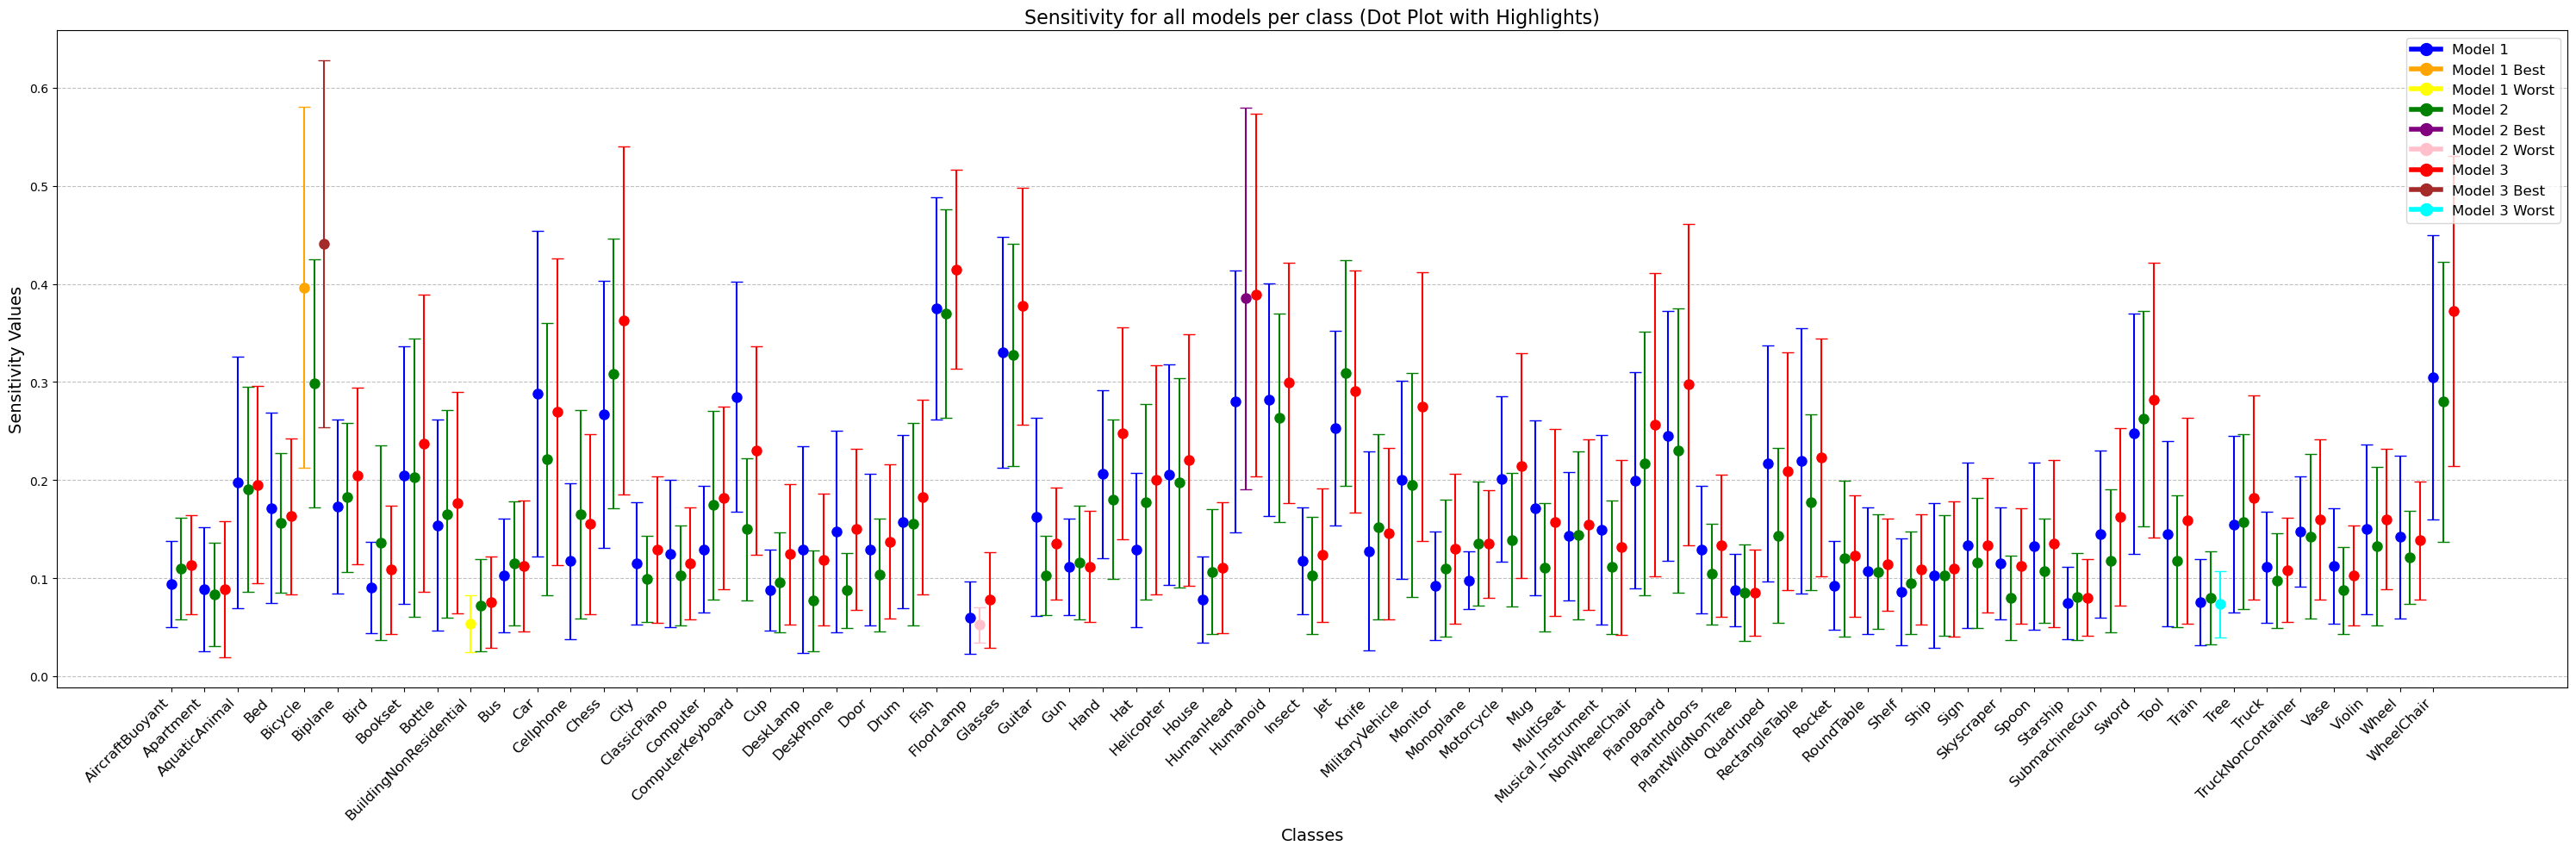

Model 1   Specificity
 best  Fish with  0.9949248883475437
 worst  Jet with  0.9543452274221506
Model 2   Specificity
 best  Hat with  0.9950027012425716
 worst  Humanoid with  0.9553278663867012
Model 3   Specificity
 best  Fish with  0.9952496954933009
 worst  Jet with  0.9566343912497759


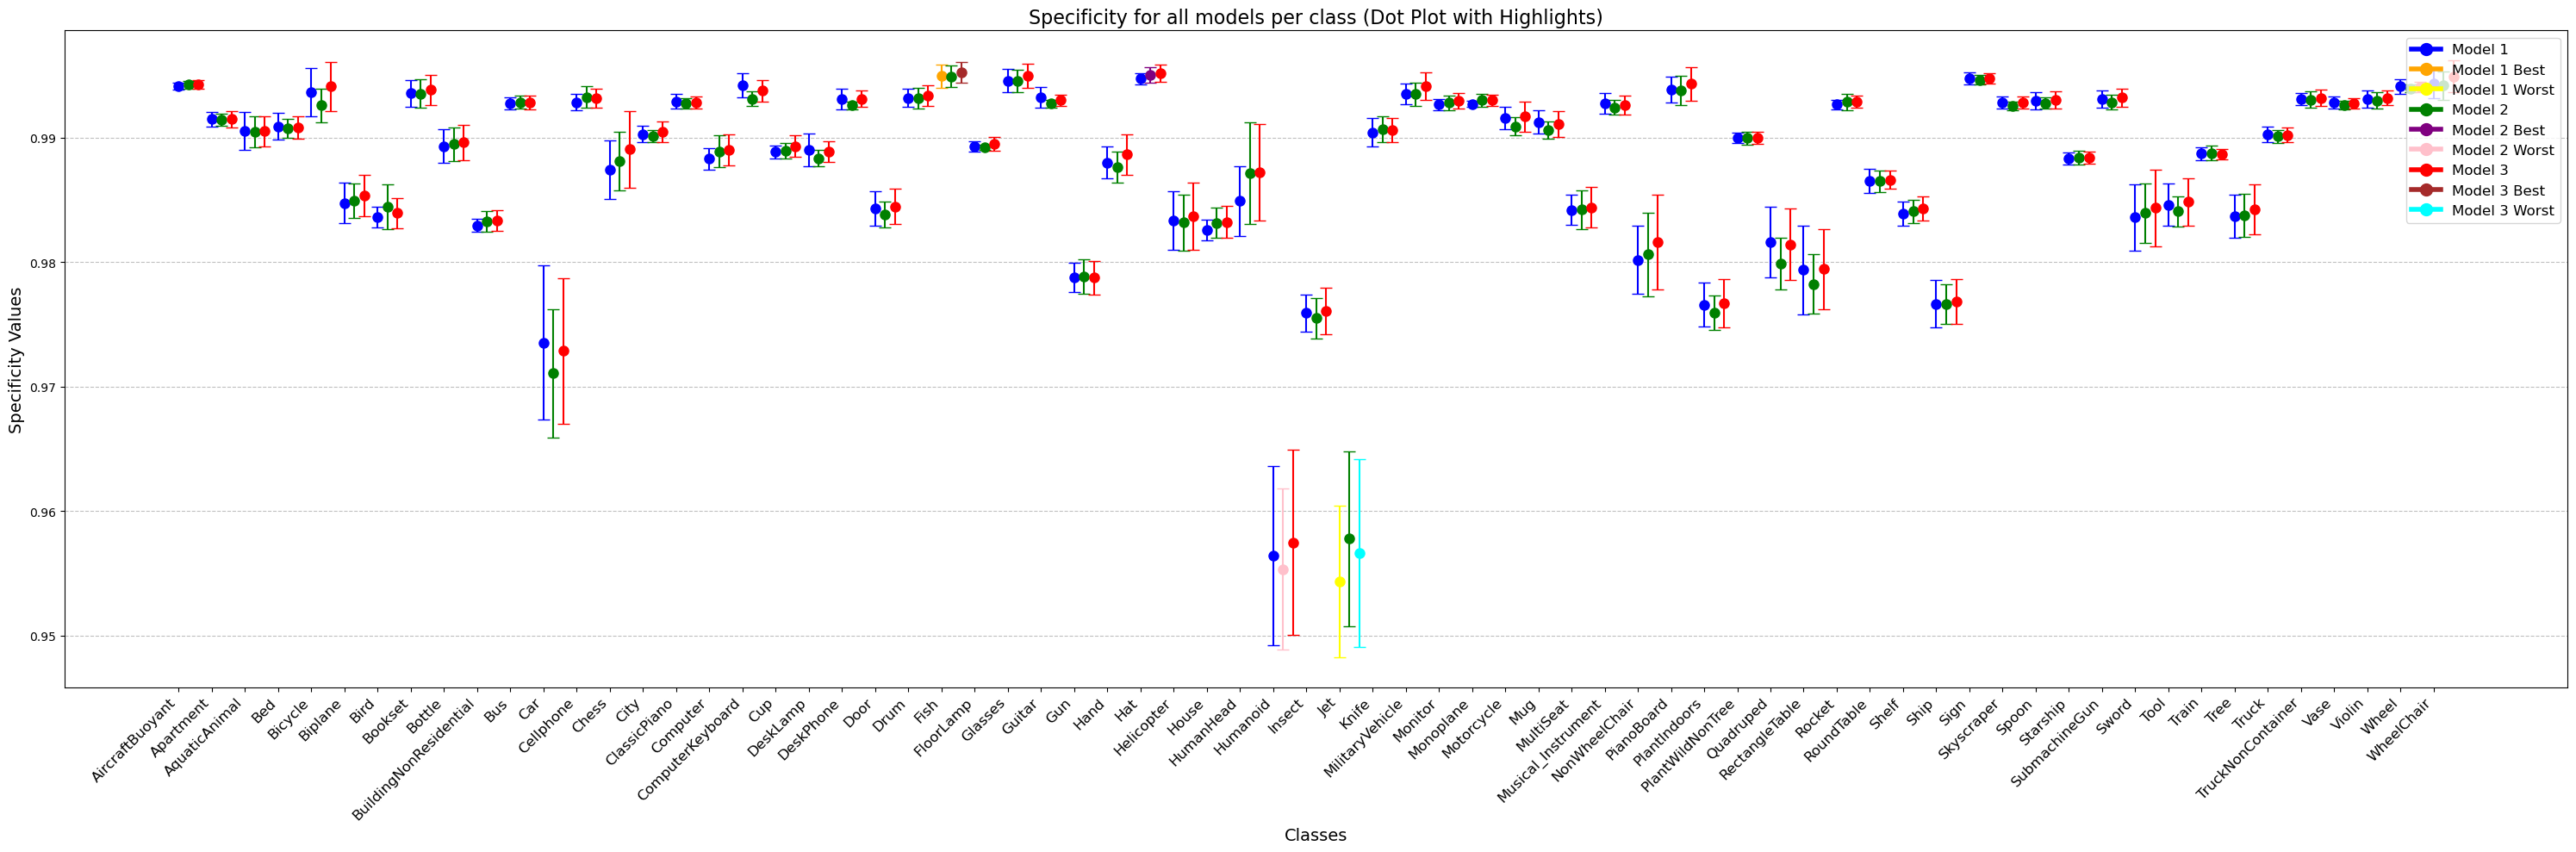

In [488]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import mean

# Helper function to append values to dictionary lists
def append_to_dict(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = []
    dictionary[key].append(value)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np

# Function to plot metrics for all models (datasets) in a spacious dot plot with best/worst highlights
def plot_metric_dots_for_all_models_highlighted(perclass_metrics, std_dev_metrics, models, metric_name):
    num_classes = len(next(iter(perclass_metrics.values()))[metric_name])  # Assuming all models have the same classes
    class_labels = list(next(iter(perclass_metrics.values()))[metric_name].keys())
    
    # Define colors for each model and specific colors for best/worst points
    main_colors = ['blue', 'green', 'red']
    best_colors = ['orange', 'purple', 'brown']
    worst_colors = ['yellow', 'pink', 'aqua']
    
    # Create a figure for the metric with increased width
    plt.figure(figsize=(30, 10))

    # Increase spacing between class groups and within dots of each class
    indices = np.arange(num_classes) * 4  # Increased spacing between class groups

    # Plot dots for each model in the same class group, with color highlights
    for i, model_name in enumerate(models.keys()):
        data_dict = perclass_metrics[model_name][metric_name]
        std_dict = std_dev_metrics[model_name][metric_name]
        
        # Extract values and standard deviations
        values = [data_dict[label] for label in class_labels]
        std_values = [std_dict[label] for label in class_labels]
        
        # Find indices of the best and worst scores for highlighting
        max_index = np.argmax(values)
        min_index = np.argmin(values)
        print(model_name," ",metric_name)
        print(" best ",class_labels[max_index], "with ", values[max_index])
        print(" worst ",class_labels[min_index], "with ", values[min_index])
        # Plot dots with error bars, color-coding best and worst points
        for j, (val, std) in enumerate(zip(values, std_values)):
            # Choose color based on best, worst, or main color for the model
            if j == max_index:
                color = best_colors[i]
            elif j == min_index:
                color = worst_colors[i]
            else:
                color = main_colors[i]
            
            # Scatter plot the point with error bars and a wider offset for more spacing between dots within a class
            plt.errorbar(indices[j] + i * 1.2, val, yerr=std, fmt='o', color=color, capsize=5, markersize=8)  # Increased offset to `1.2`

    # Set labels and title with larger font sizes for readability
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel(f"{metric_name} Values", fontsize=14)
    plt.title(f"{metric_name} for all models per class (Dot Plot with Highlights)", fontsize=16)

    # Custom legend to explain color-coding for best/worst points
    custom_legend = [
        plt.Line2D([0], [0], marker='o', color=main_colors[0], lw=4, markerfacecolor=main_colors[0], markersize=10, label="Model 1"),
        plt.Line2D([0], [0], marker='o', color=best_colors[0], lw=4, markerfacecolor=best_colors[0], markersize=10, label="Model 1 Best"),
        plt.Line2D([0], [0], marker='o', color=worst_colors[0], lw=4, markerfacecolor=worst_colors[0], markersize=10, label="Model 1 Worst"),
        plt.Line2D([0], [0], marker='o', color=main_colors[1], lw=4, markerfacecolor=main_colors[1], markersize=10, label="Model 2"),
        plt.Line2D([0], [0], marker='o', color=best_colors[1], lw=4, markerfacecolor=best_colors[1], markersize=10, label="Model 2 Best"),
        plt.Line2D([0], [0], marker='o', color=worst_colors[1], lw=4, markerfacecolor=worst_colors[1], markersize=10, label="Model 2 Worst"),
        plt.Line2D([0], [0], marker='o', color=main_colors[2], lw=4, markerfacecolor=main_colors[2], markersize=10, label="Model 3"),
        plt.Line2D([0], [0], marker='o', color=best_colors[2], lw=4, markerfacecolor=best_colors[2], markersize=10, label="Model 3 Best"),
        plt.Line2D([0], [0], marker='o', color=worst_colors[2], lw=4, markerfacecolor=worst_colors[2], markersize=10, label="Model 3 Worst")
    ]
    plt.legend(handles=custom_legend, loc='upper right', fontsize=12)
    
    # Set x-ticks with more space between them and rotate labels for clarity
    plt.xticks(indices, class_labels, rotation=45, ha='right', fontsize=12)
    
    # Add grid lines for y-axis for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.8)
    
    # Adjust margins to reduce space on the left and right edges
    plt.subplots_adjust(left=0.05, right=0.95)

    # Adjust layout to fit elements
    plt.tight_layout()
    
    # Show the plot
    plt.show()


# Main function to calculate and plot metrics for each model
def calculate_metrics_for_models(models):
    # Initialize dictionaries to store metrics for each model
    perclass_metrics = {model_name: {metric: {} for metric in ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity']} for model_name in models.keys()}
    std_dev_metrics = {model_name: {metric: {} for metric in ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity']} for model_name in models.keys()}
    
    # Iterate through each model (dataset)
    for model_name, df in models.items():
        precisions, recalls, f1_scores, accuracies, sensitivities, specificities = {}, {}, {}, {}, {}, {}
        database_size = len(df)

        # Calculate per-class metrics for each model
        for _, row in df.iterrows():
            query_class = row['Shape Class']
            y_pred = list(map(int, row['evaluated']))  # Convert the string list to an actual list of integers
            query_size = len(y_pred)

            # Calculate TP, FP, TN, and FN
            TP = sum(y_pred)
            FP = query_size - TP
            FN = query_size - TP
            TN = database_size - query_size - FP

            # Compute performance metrics
            precision = TP / query_size if query_size > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            accuracy = (TP + TN) / database_size
            sensitivity = recall
            specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
            f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

            # Store the results in dictionaries
            append_to_dict(precisions, query_class, precision)
            append_to_dict(recalls, query_class, recall)
            append_to_dict(f1_scores, query_class, f1_score)
            append_to_dict(accuracies, query_class, accuracy)
            append_to_dict(sensitivities, query_class, sensitivity)
            append_to_dict(specificities, query_class, specificity)

        # Calculate per-class averages for each metric
        perclass_metrics[model_name] = {
            'Precision': {label: mean(values) for label, values in precisions.items()},
            'Recall': {label: mean(values) for label, values in recalls.items()},
            'F1 Score': {label: mean(values) for label, values in f1_scores.items()},
            'Accuracy': {label: mean(values) for label, values in accuracies.items()},
            'Sensitivity': {label: mean(values) for label, values in sensitivities.items()},
            'Specificity': {label: mean(values) for label, values in specificities.items()},
        }

        # Calculate standard deviation per class
        std_dev_metrics[model_name] = {
            'Precision': {label: np.std(values) for label, values in precisions.items()},
            'Recall': {label: np.std(values) for label, values in recalls.items()},
            'F1 Score': {label: np.std(values) for label, values in f1_scores.items()},
            'Accuracy': {label: np.std(values) for label, values in accuracies.items()},
            'Sensitivity': {label: np.std(values) for label, values in sensitivities.items()},
            'Specificity': {label: np.std(values) for label, values in specificities.items()},
        }

    # Plot each metric for all models with highlighted best and worst scores
    for metric in ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity']:
        plot_metric_dots_for_all_models_highlighted(perclass_metrics, std_dev_metrics, models, metric)

    # Calculate overall averages for all classes in each model
    overall_metrics = {
        model_name: {metric: mean(list(values.values())) for metric, values in perclass_metrics[model_name].items()}
        for model_name in models.keys()
    }

    return overall_metrics

models = {
    "Model 1": merged_df_part_4,
    "Model 2": merged_df_part_5,
    "Model 3": merged_df_part_4_bonus
}

# Calculate metrics for each model and plot them
results = calculate_metrics_for_models(models)
